# Characterize C branchpoints and branchpoints missing a -2 T

In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)
        
primates = {}
with open('../anno/hg19.46way.phylop.primates.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in primates: primates[chrom] = {}
        primates[chrom][int(pos)] = float(score)

In [4]:
# file is result of bedtools intersect -loj
introns = {}
lengths = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, gene, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end, pos = int(bp), int(start), int(end), int(pos)
        gene = gene.split('.')[0]
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand, gene)
        
        lengths[(chrom, three)] = (end - pos
                                   if strand == '+' else
                                   pos - start)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)
print known.keys()[0]

37110
169182
('chr9', 137650088, '+', 'ENSG00000130635')


In [6]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y, chroms, coords, strands, genes = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand, gene = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c3 = np.array([primates[chrom][pos] if pos in primates[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
            c3 = c3[::-1]
        X += [np.hstack([onehot(seq), c1, c2, c3]).reshape(1, L, 7)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
        genes += [gene]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords),
            np.array(strands), np.array(genes))

(X_known, y_known,
 k_chroms, k_coords,
 k_strands, k_genes) = encode(known, phastcons, phylop)
(X_novel, y_novel, 
 n_chroms, n_coords,
 n_strands, n_genes) = encode(missing, phastcons, phylop)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 56808.0
(169182, 70, 7) (37110, 70, 7)


In [7]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [8]:
y_novel = model.predict(X_novel[:, :, :4]).reshape(-1, L)
p_known = model.predict(X_known[:, :, :4]).reshape(-1, L)

In [9]:
X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])
a_genes = np.hstack([n_genes, k_genes])

# Examples

Can actually see that many of the C branchpoints have C-rich PPT.
Also seemingly a lot of repeats?

Interestingly many of the no -2 T branchpoints have a TnA available.

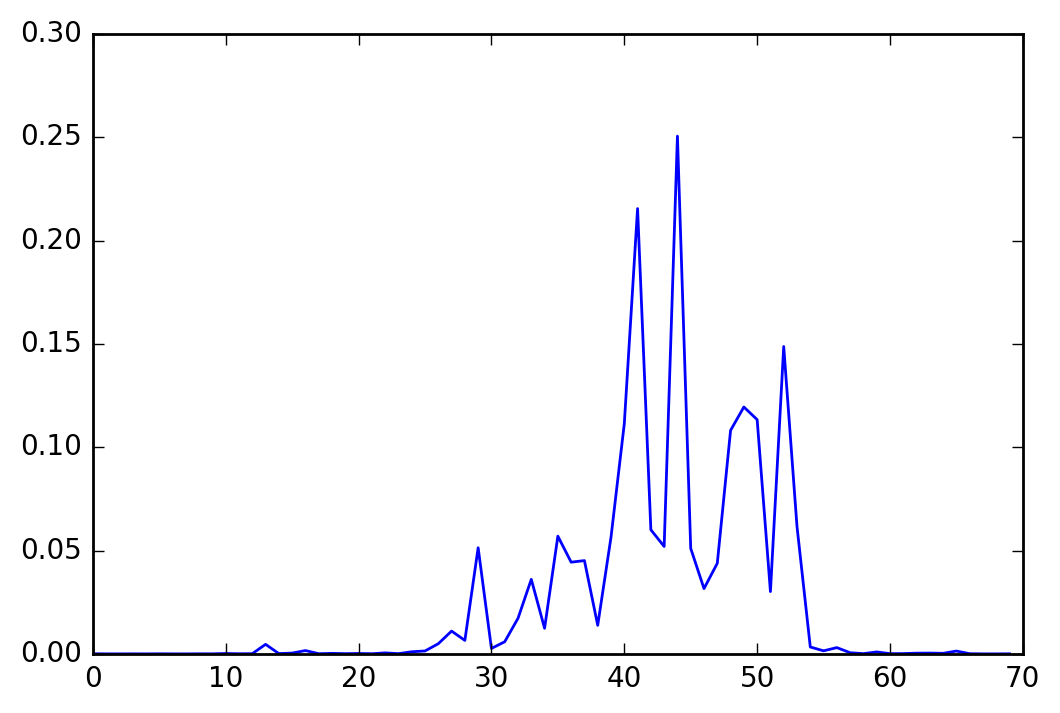

TTCGGGGTCGCCTAGCGGCGGGCGCGGCCAGGGCGCGCTGGCTTGTTTCGCTCGCTTTTGTTTTTAAAAG
____________________________________________B


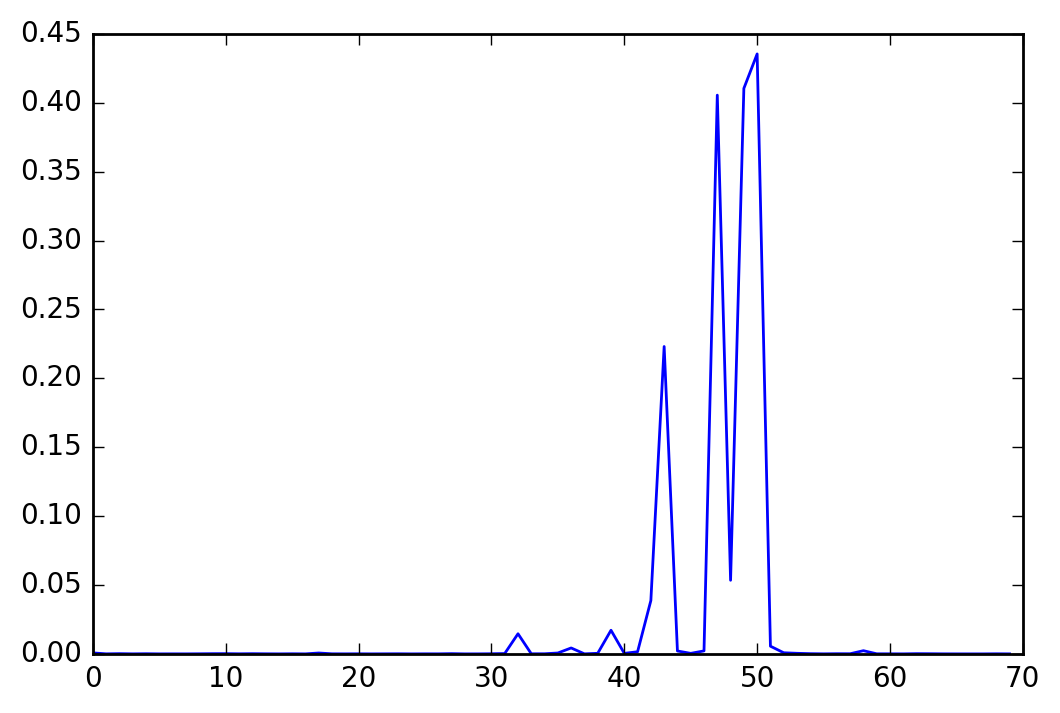

CGTGCCTCTGCTTTTCCTGTGGAAGGGACCTCAGGAAGCATTAATGCTGAGCGGTTGGACGTGTCCTTAG
__________________________________________________B


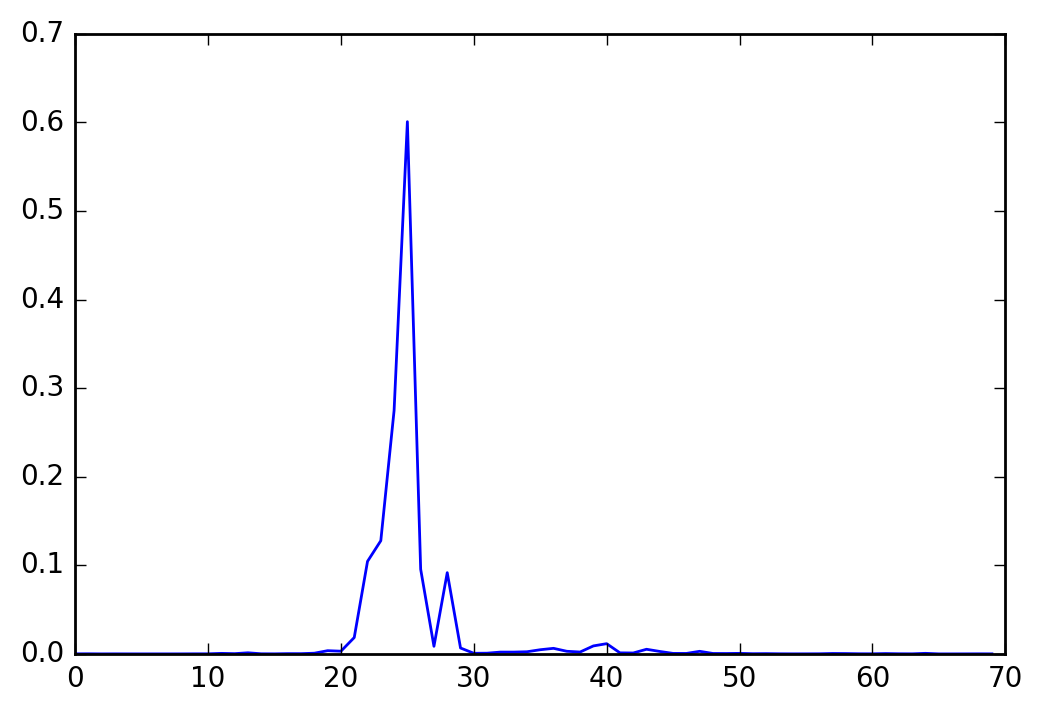

CAGAGGCTTCTCCGGTCGCCGCTGCGCCAGTTTTTTTTTGTTTGTTTGTTGTGTTTTCCCTGGCAAACAG
_________________________B


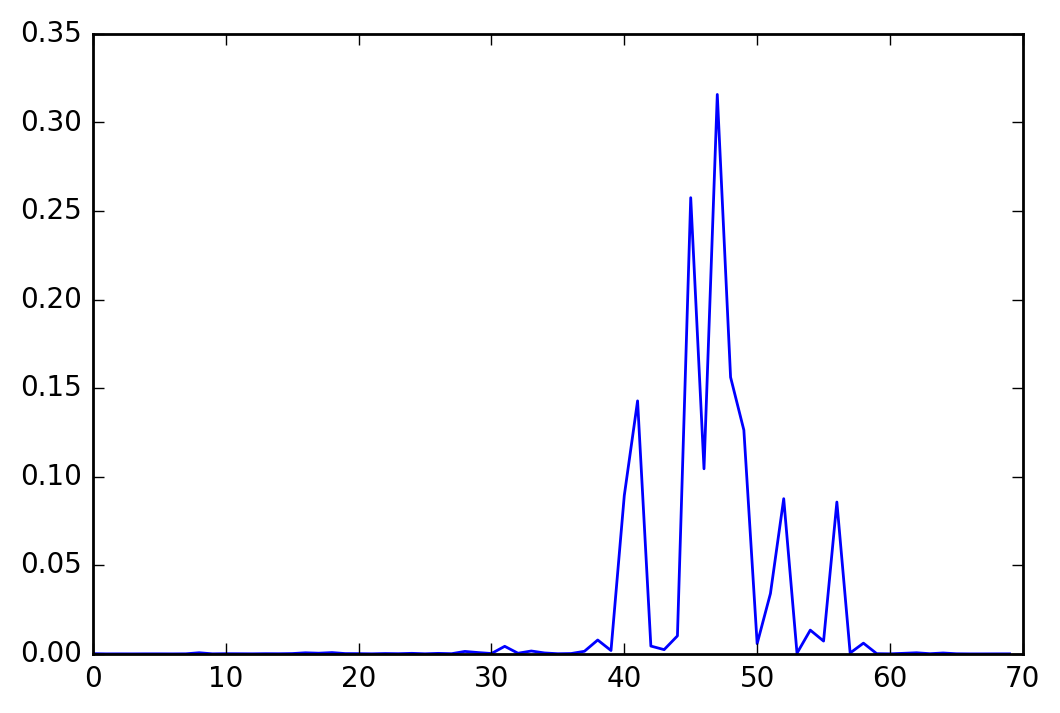

CCTGAGGCAGGGTCCTGGGGCCTGTGTGCCTCCACGCCATAATGCTGGCAGAACTGATATTTCTCTTTAG
_______________________________________________B


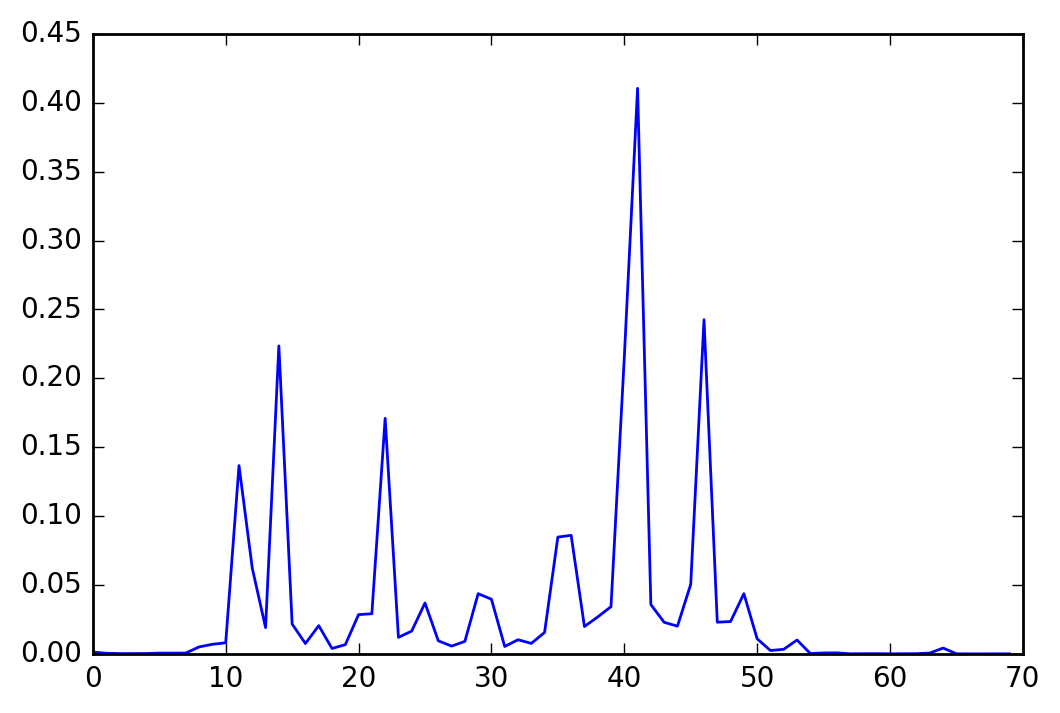

TCTTTCCTCCTCCTCCTGTTCTCTTCTTTGTCTTTGTCTTCGTCTTCTTTCTTCTTCTTTTTTTATTTAG
_________________________________________B


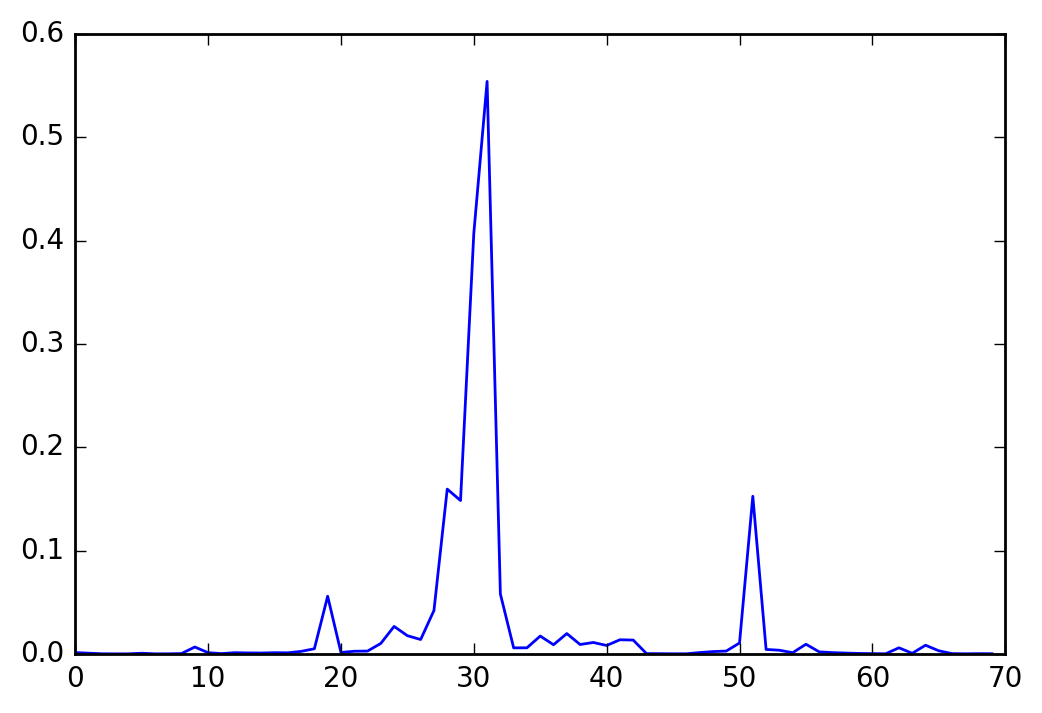

AATCCATCCACGCGGGGGGAGCTGGTGCTGCGCCCCCCCCCACCCCTCCCCATCCAGGCCCCATAAATAG
_______________________________B


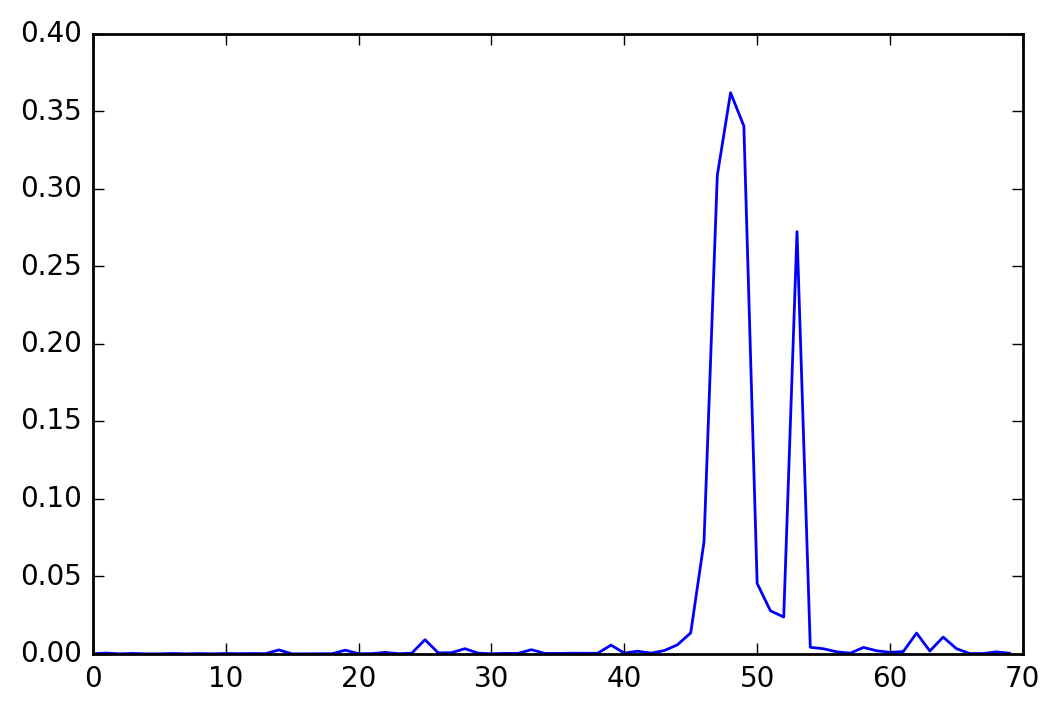

GGGTGTGGTGCGGGAGTGGGGTGGTAGGAGGCGAGGGGCAGGCTGGTGGCCGGAGCCTGGCTCTCCTCAG
________________________________________________B


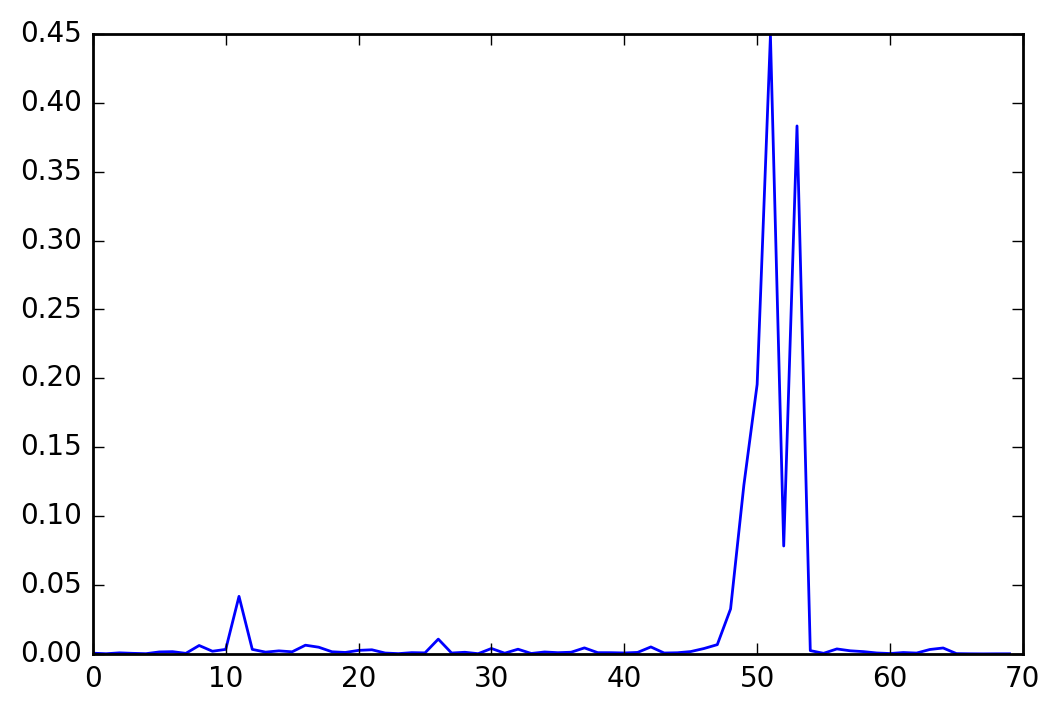

AGAAGAAGACGACCCTCGTGGGTTGGGGTGGGTGTGTCGTGGATGGTTCTGGCAGTGGCCTCTGTCCTAG
___________________________________________________B


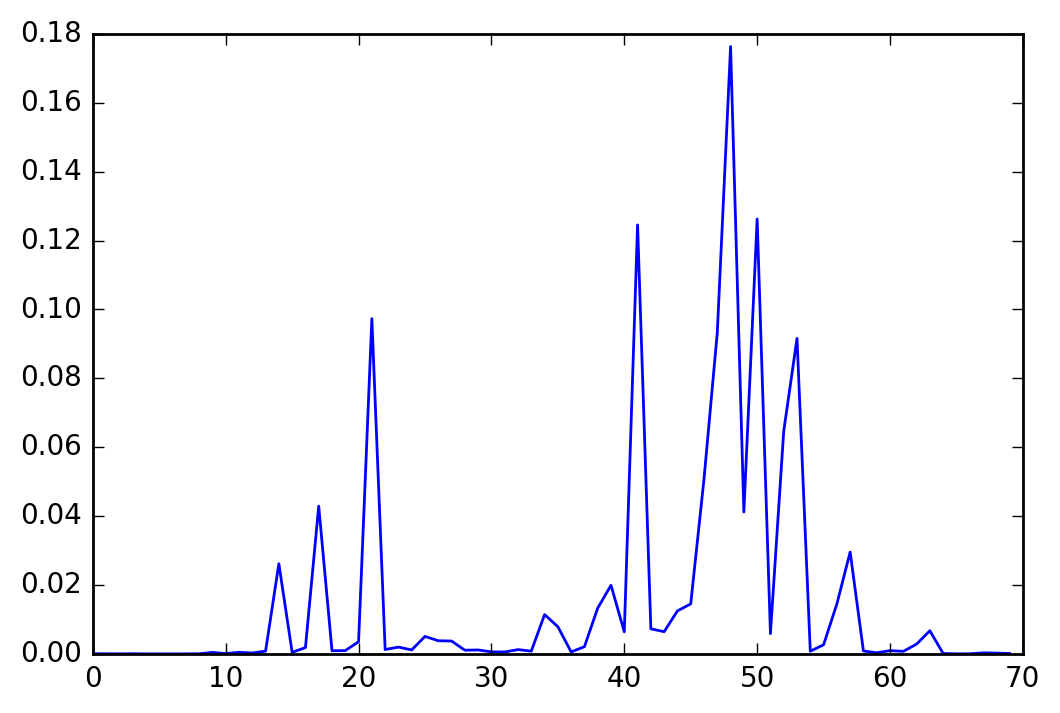

GGGATCCCCACGGCAGCACGCAGTCTGTCCCCGGAACCCCCAGTTTGGGCAGAACTCCCTCTGCTTGCAG
________________________________________________B


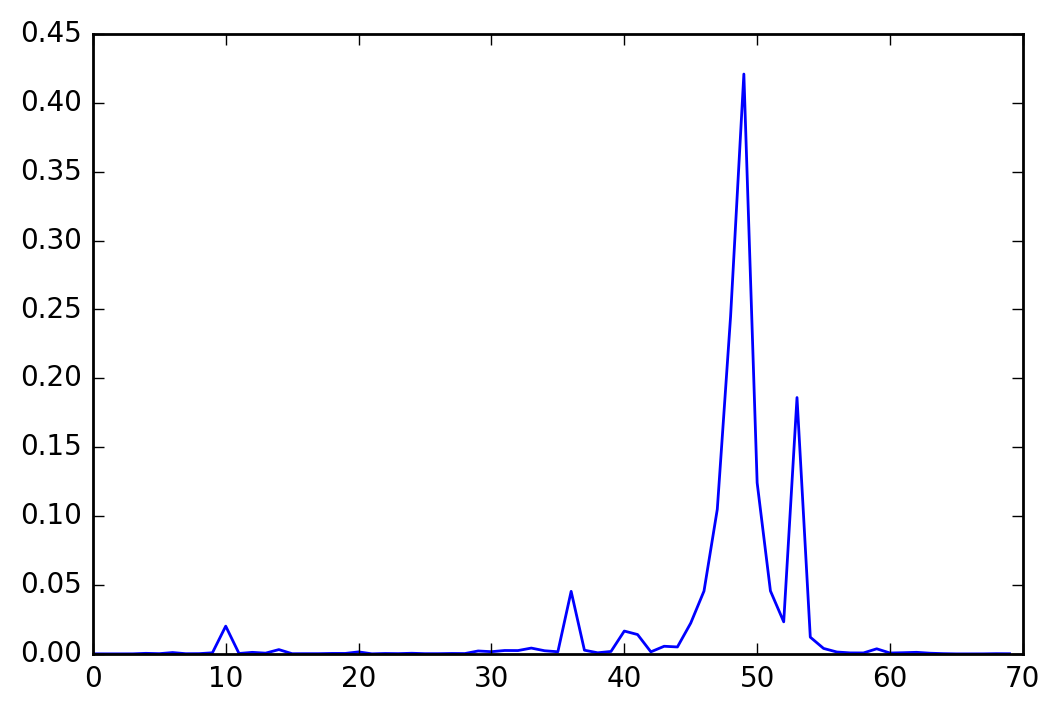

CTCCACATGCAGGGGGTGGGGCTGTCCCGGGTCCCCAGCTCCCCGCCTGGCCGAGCCTTCCGCCCTGCAG
_________________________________________________B


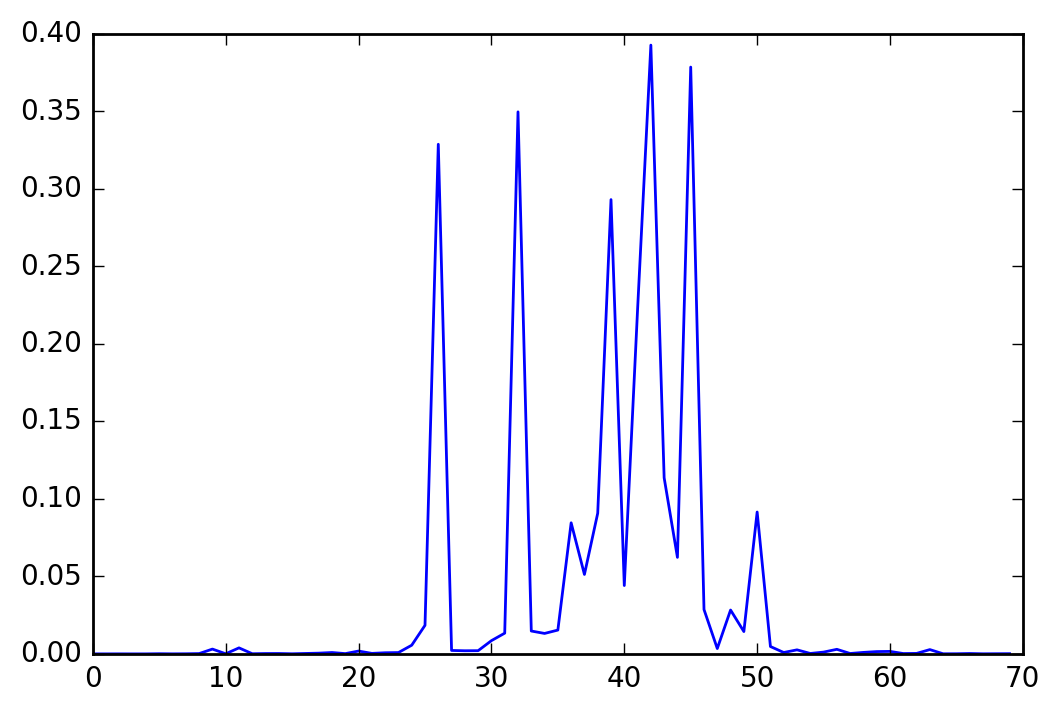

CTGGCAGGCACAGCGCTCTGTGTGGCAGCTGGAGTTCTGCTCGCCATCTGCCTCTTCTGGGCCATGATAG
__________________________________________B


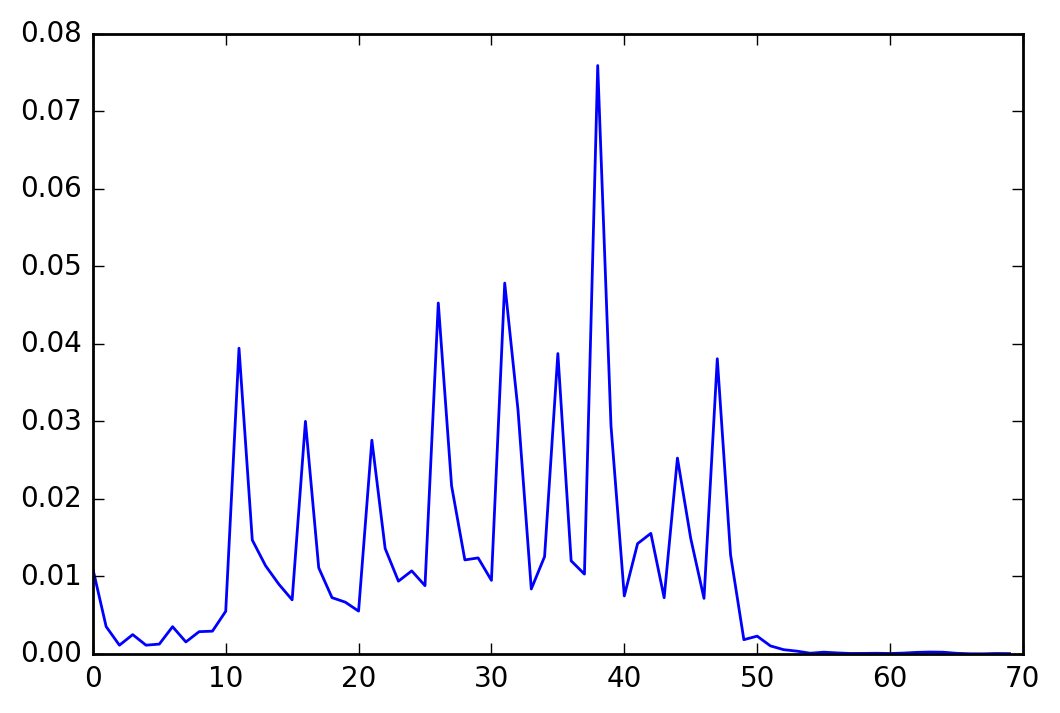

TTTTTTGTTTTGTTTTGTTTTGTTTTGTTTTGTTTTTTGTTTTTTTTGTTTTTTTGGTTTTTTTTTTCAG
______________________________________B


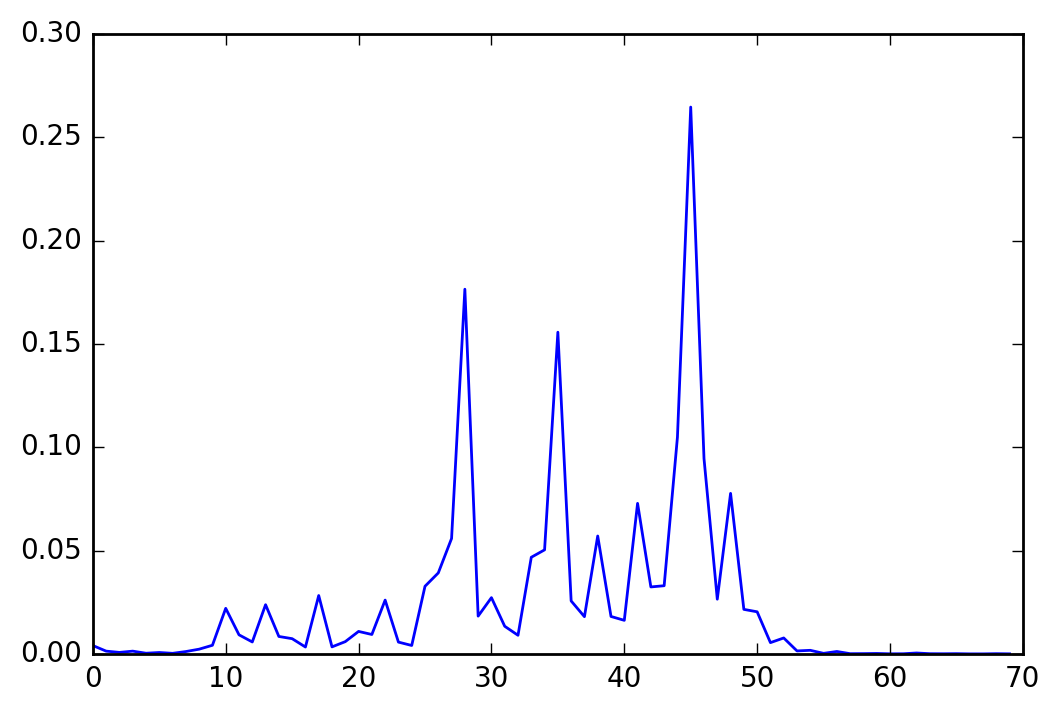

CTTCCTTTCTCTTTCTTTCTCTCTTGCTCTCTCTGTCTCTTGCTTGCTCTCTCTCTCTTTTTGTTCTTAG
_____________________________________________B


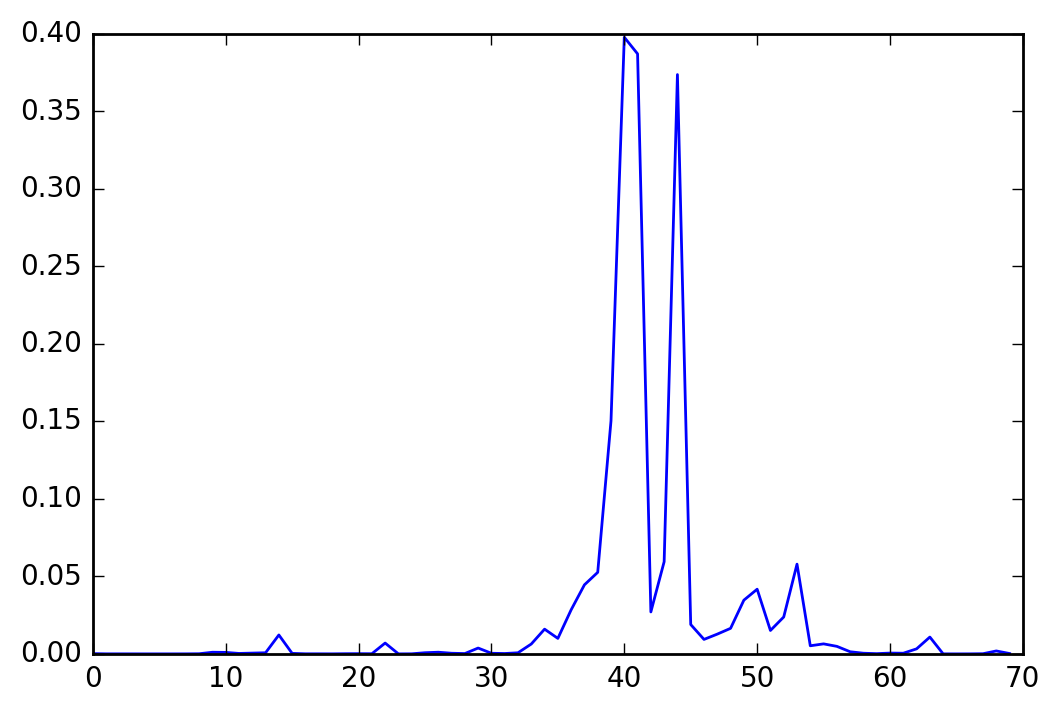

CTGGCTCTTCCTTGAGGCCTGCATTGGCCAGCTCCGCTGCGAGCACCCTGCTTGTGCCCTGTGACTGCAG
________________________________________B


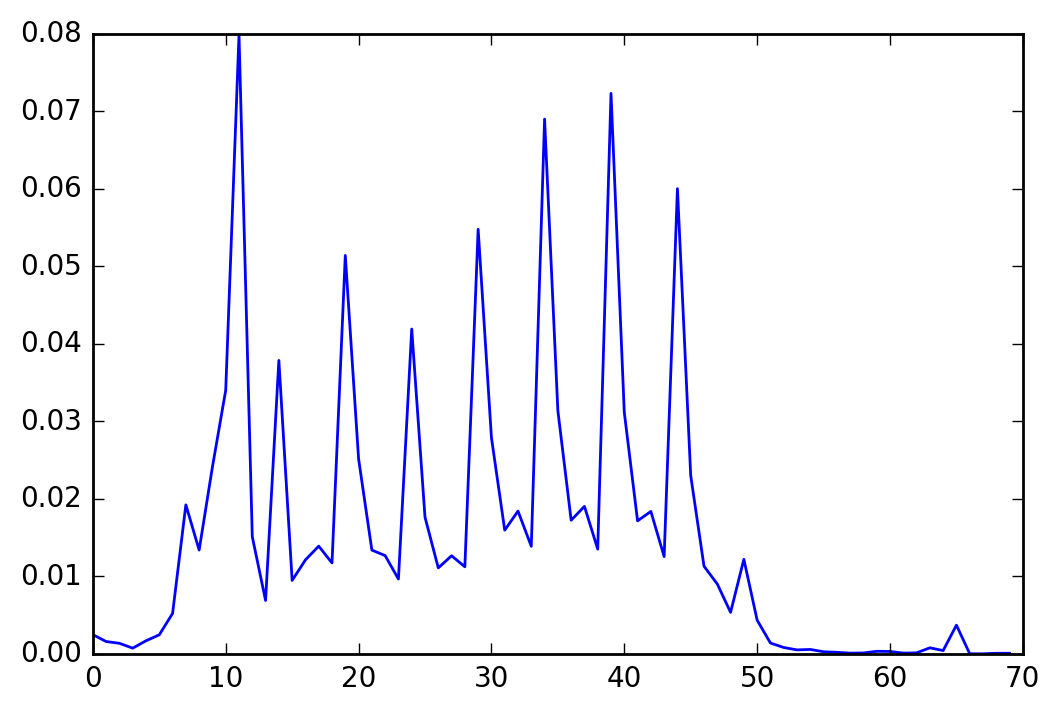

GGTTTTTCTCGGTTGTTTTGTTTTGTTTTGTTTTGTTTTGTTTTGTTTTGTTTTGTTTTGTCTCCATTAG
___________B


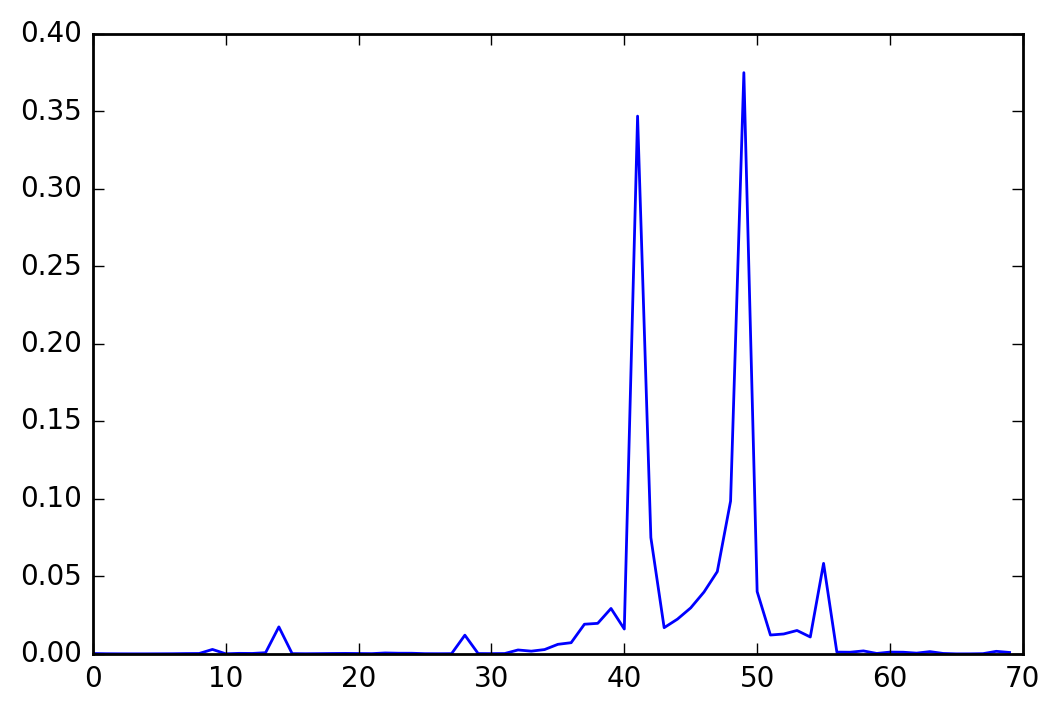

CTCTCGGGGATCCCATGTCCTTGGGCTCAGTTCCTGGGGCCAGTGCTGGGCTGCTCTCGTCCTGCTGCAG
_________________________________________________B


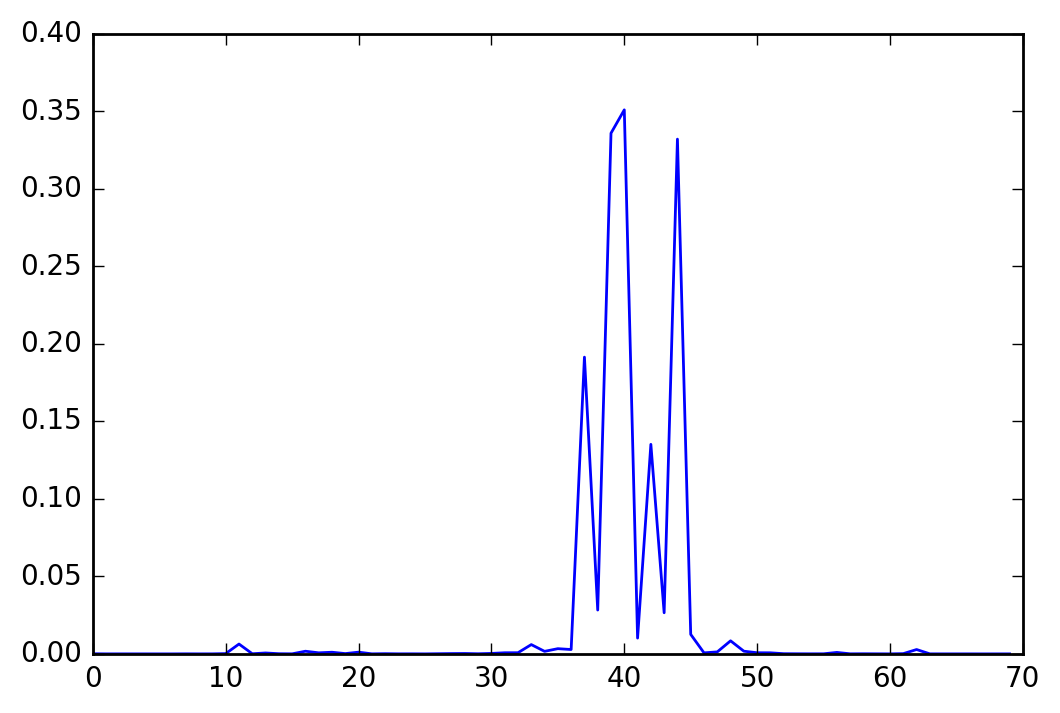

GGTCCCTCCTCATATCTGCCAGGGTCTGCTTCTCTGCTGAGCTGATTTCCCCCCTTCCCCTCATCTCTAG
________________________________________B


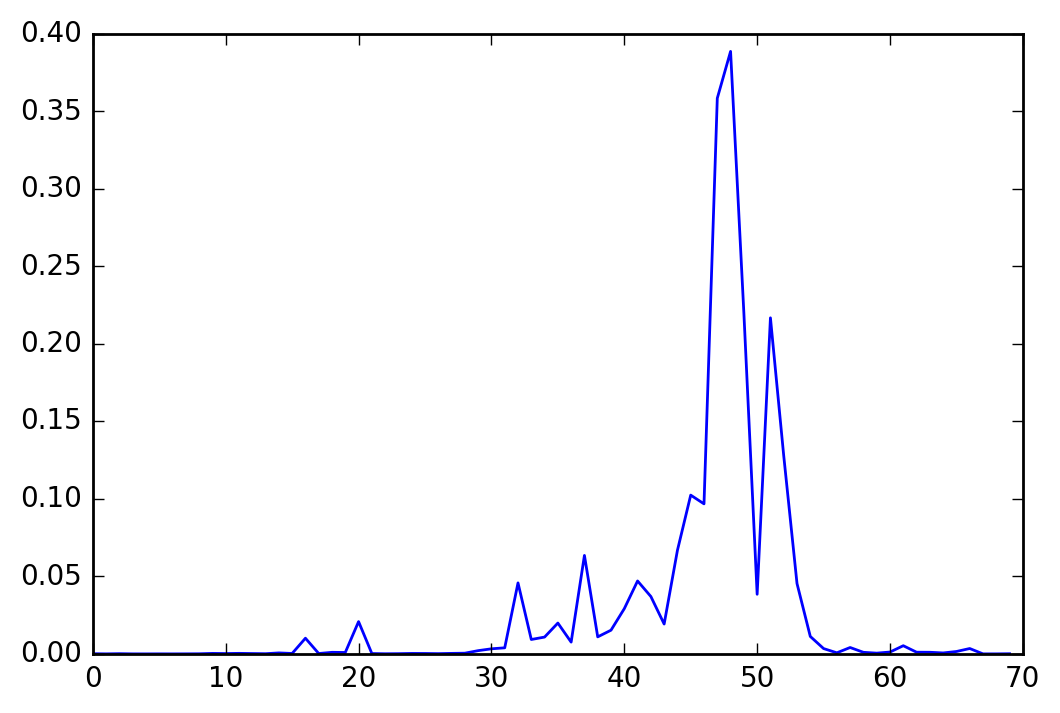

CGAGCTCTGGGCCTCCAGTGACCCGGCCGGCCAGCCGCCGGCCTGCTCGCTCGCCCTCCTTCCCTCACCG
________________________________________________B


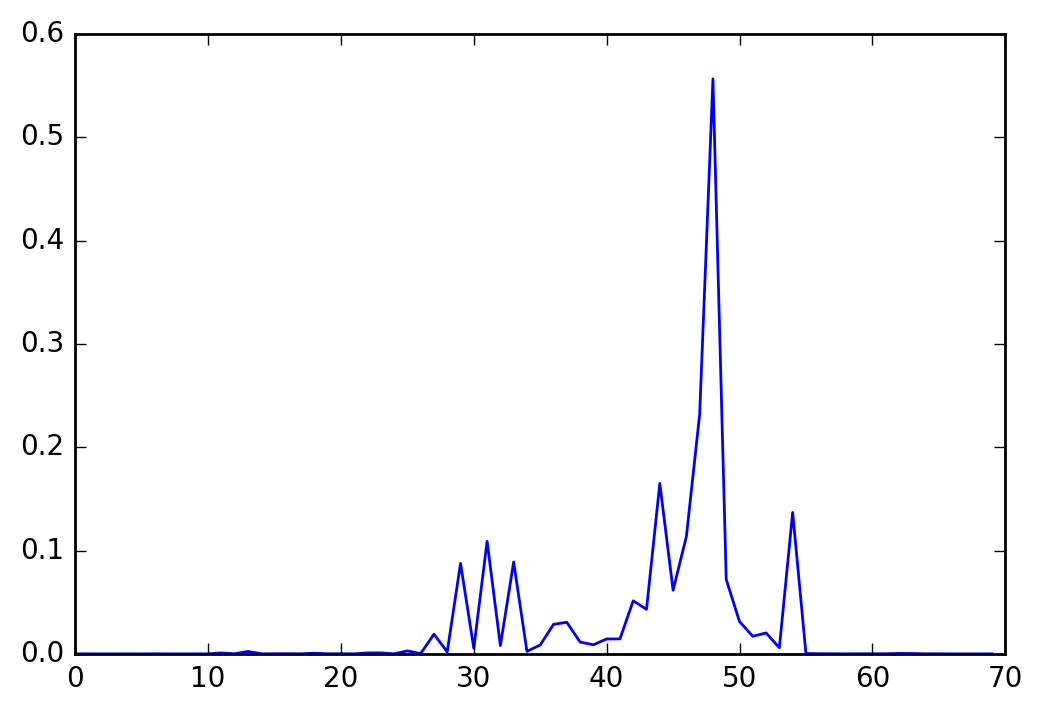

GAGGACAGCTCTGTGTGGAATGAACACAGACATAGGGCGGCTCTCTGCGCTGTCATGTTTTTCCTTCCAG
________________________________________________B


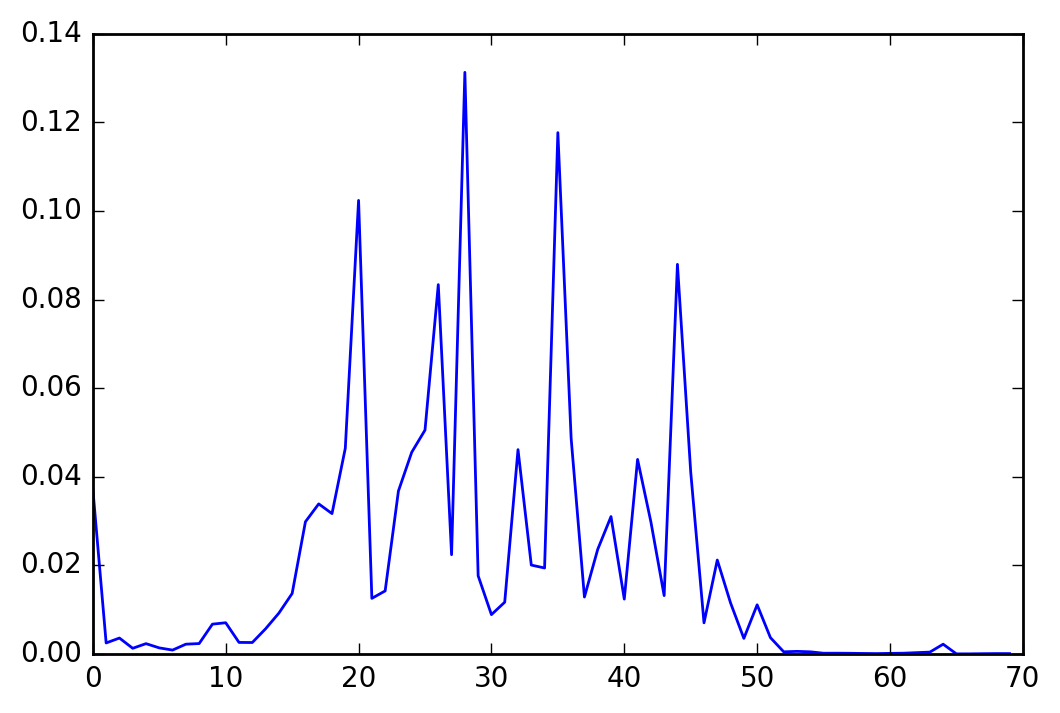

ATTCTTTGGGGTTTTTTCTTTTTGCTTTGTTTTTTGTTTTTTTTGTTTTTGTTTTTTTTTTTTCATGCAG
____________________________B
57


In [10]:
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp, 2]: continue
    total += 1
    if total > 20: continue
    plt.plot(target)
    plt.show()
    print ''.join(map(lambda x: bases[np.argmax(x)], seq[:, :4]))
    print '_'*bp + 'B'
print total

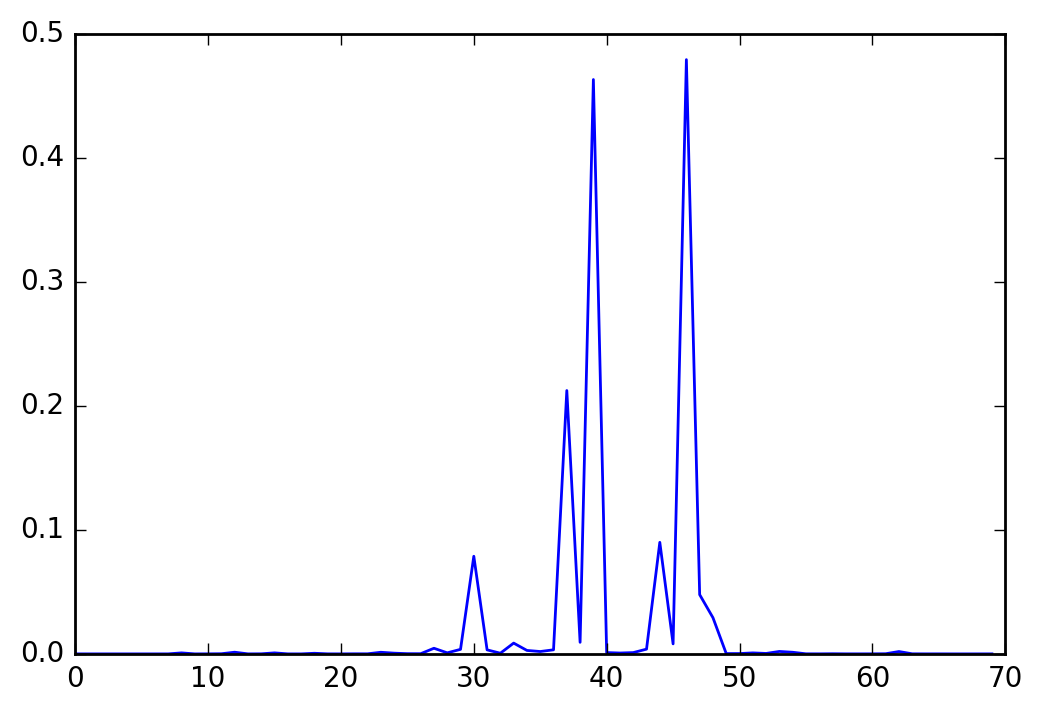

ACAGGTTAAGTAAGCATCAGTTCTGTTACTATTAGTTACATTCTATAAATTCTCCCTGTTTTATTTCTAG
______________________________________________B


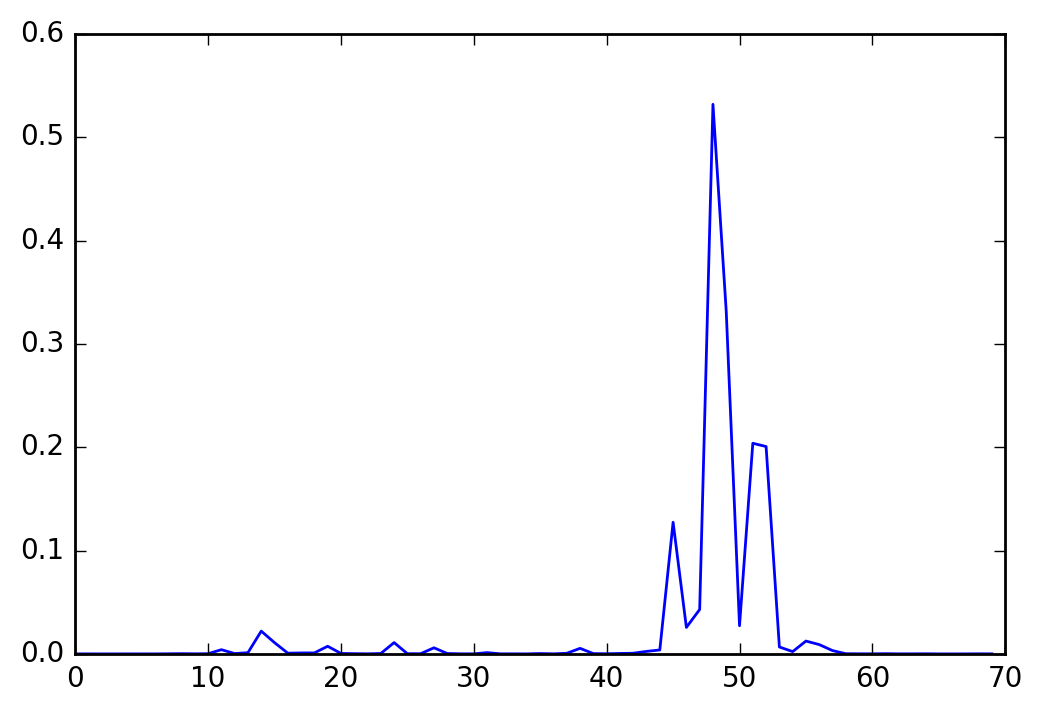

ATGCTGCAAGGATTACCCCACCCTATTACTTGGTTTGCATGGGGGACGAATAAGCTGTCTTTCTCTGCAG
________________________________________________B


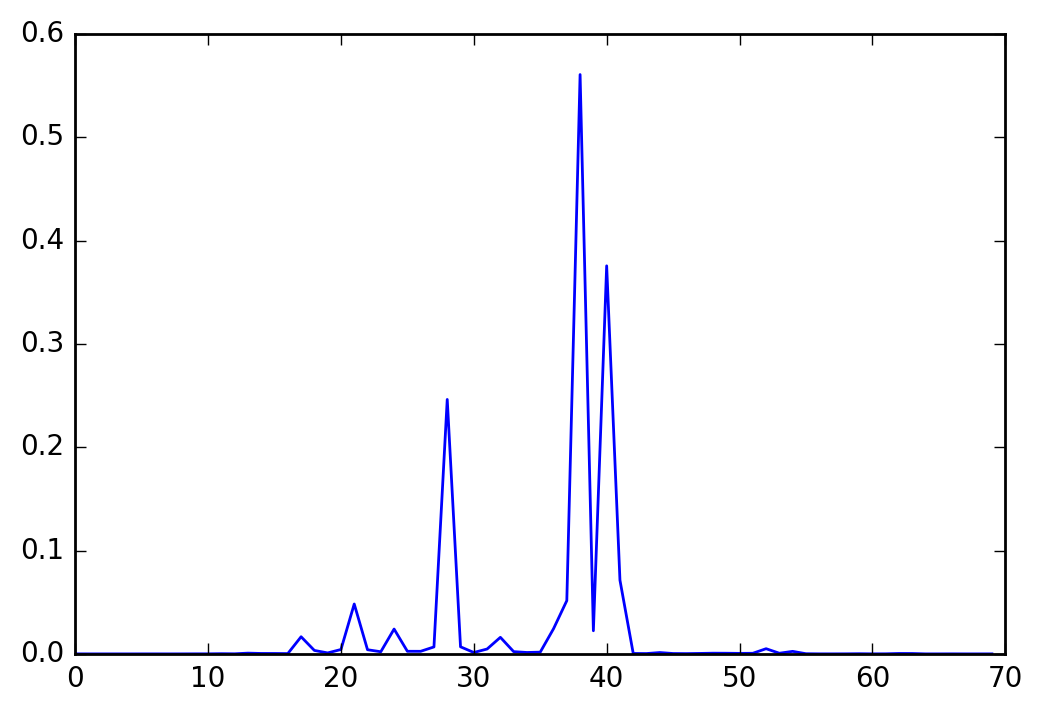

TCTCTTGTTGCTTTGTCAATGATGATTTACCTGTCTCCACAATTGTTTTCTTCCACCTTCCTTTTGAAAG
______________________________________B


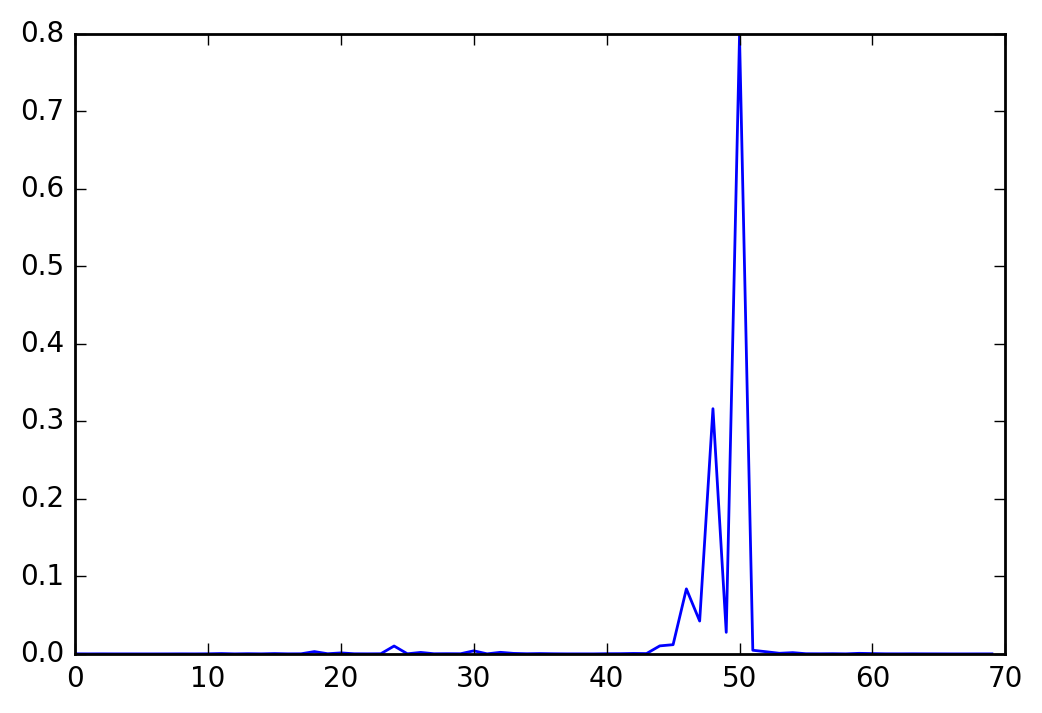

GGCCCCTCGCTCTCCTGCACATGCAGCCCCACTGTGGCCCCGTCTGCTACAGCCCCTCTCCCTTTGTTAG
__________________________________________________B


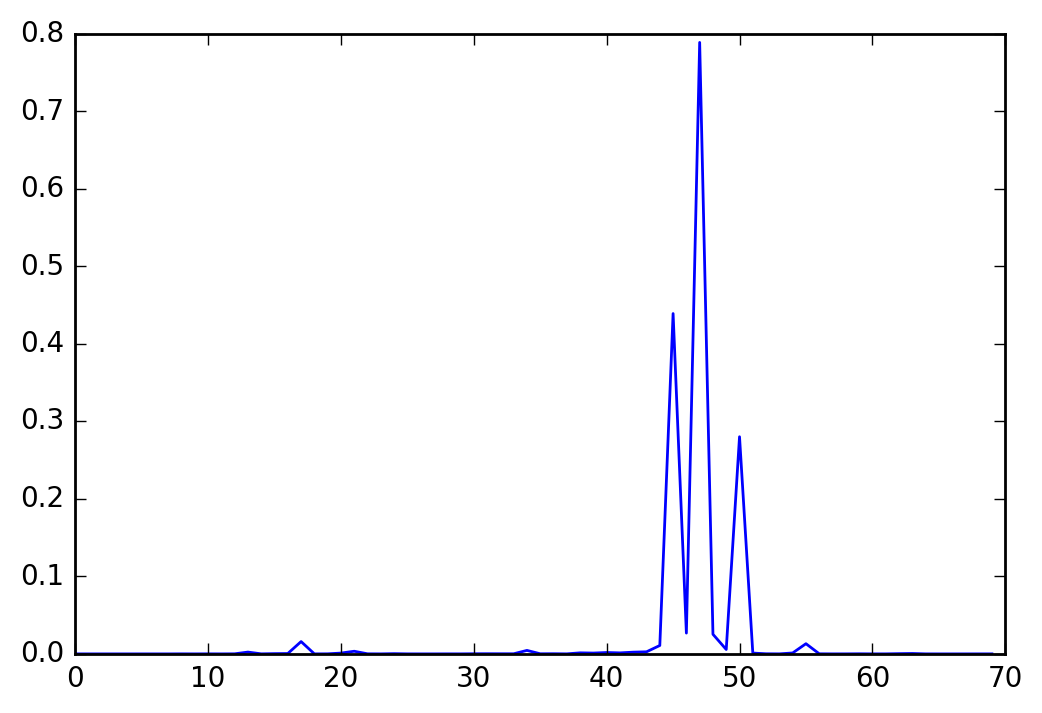

GTTGGATTTGTCTATTAAGTAACGGGTTTTTCTCAGGCTGTTTTTATAGCATGCTATTTTCTCCCTGCAG
_______________________________________________B


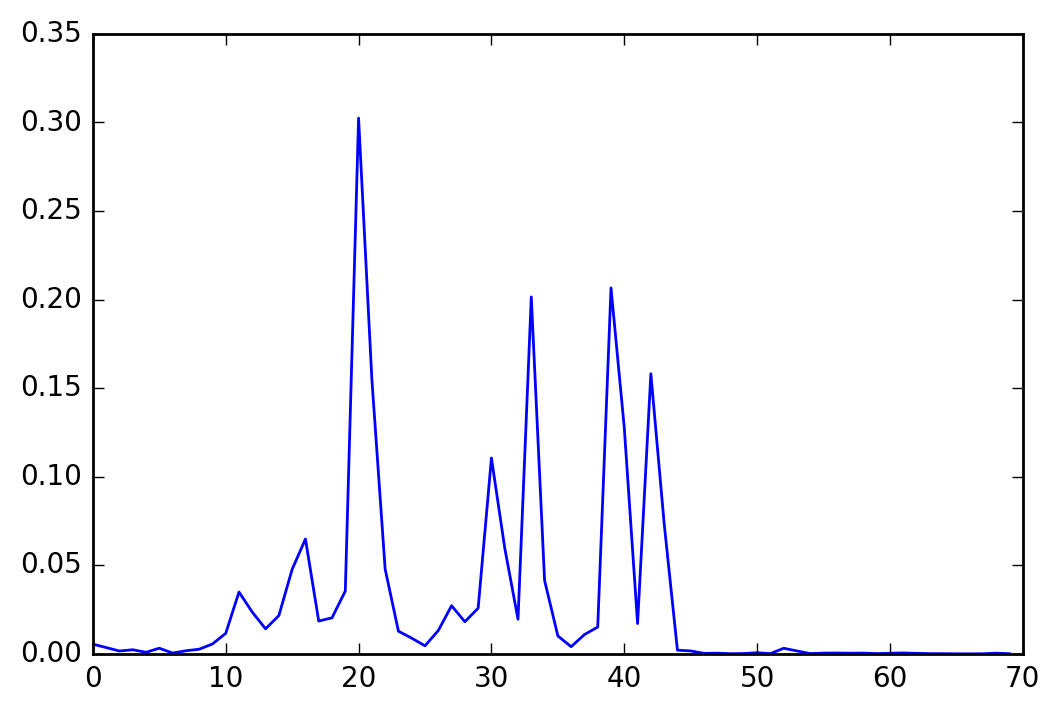

GTCTCCCTGTCCCTGCGTCTCCCGTCTGTGCCTCCCTCTCCTCCCCGTCTCTCCCGGCCCGGGCGCTCAG
____________________B


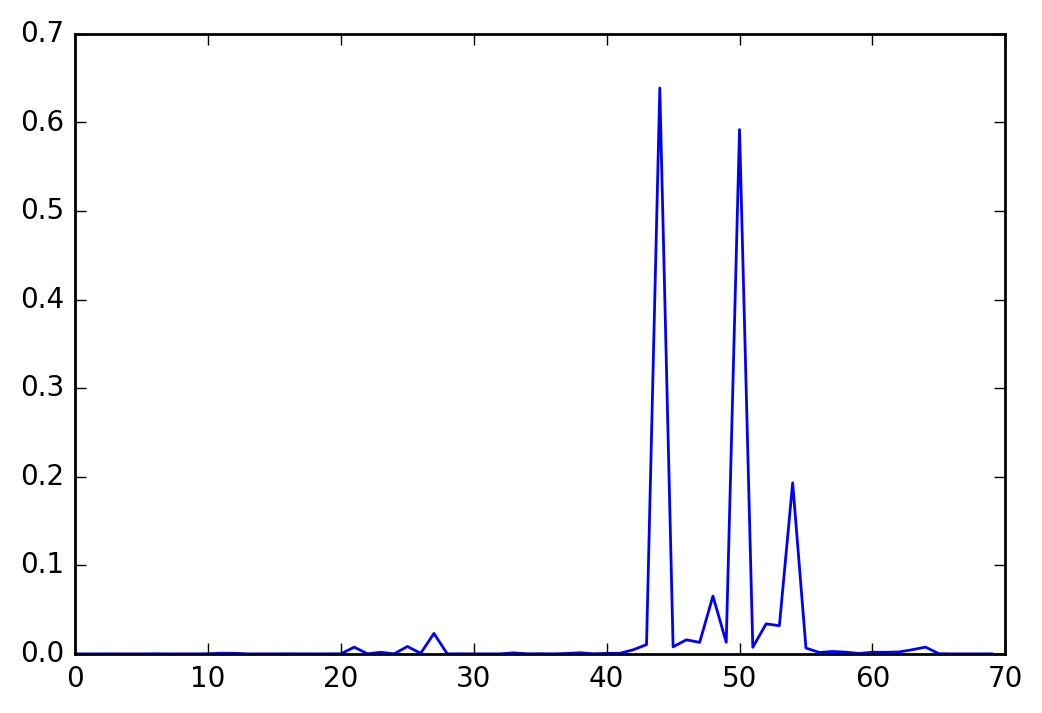

GCCACCACGGGAGGTGGGCTTACACTGAGACCCAGACAGGTGGGACCTGCAGCCACTGCTGCTCCCCTAG
____________________________________________B


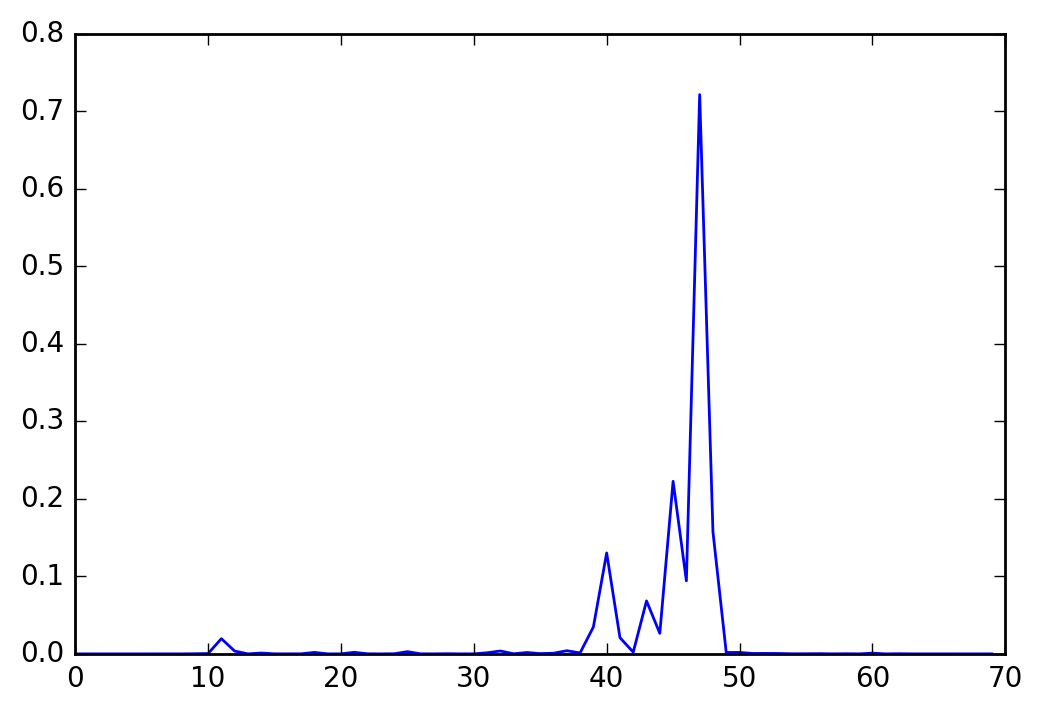

CAGCCCATCTTAAGAGCCATTATCCATTTTTAATACTCTAAAGATACAAGTGTGTTCTGTATATTTCTAG
_______________________________________________B


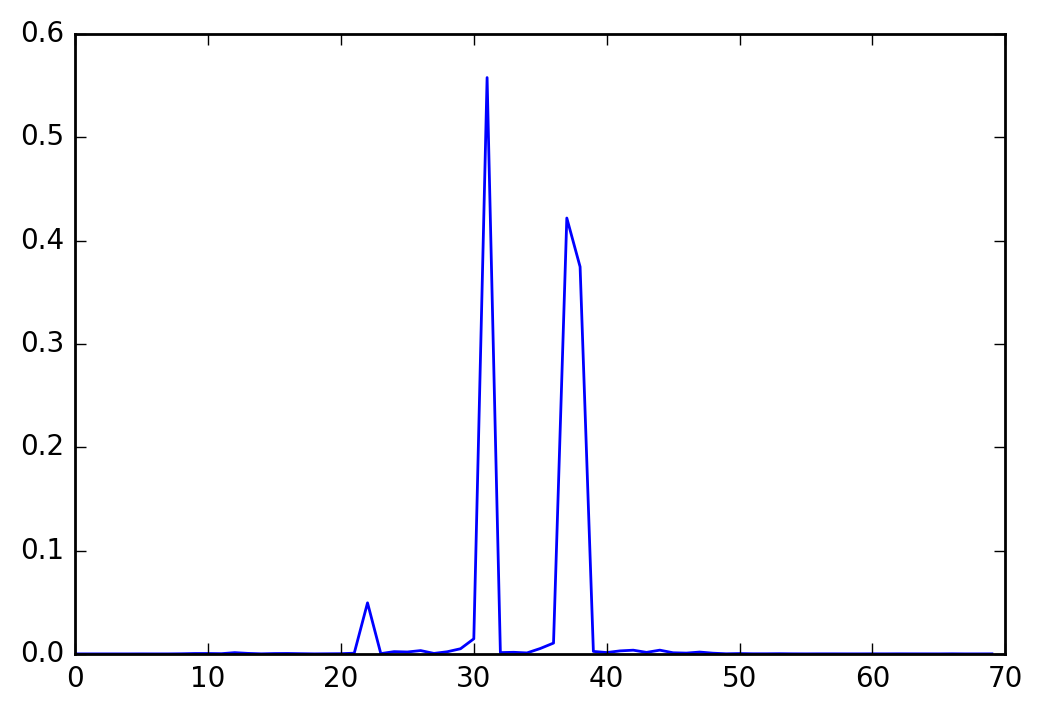

TAAATATTAAACATGAAATTTTATTGTTTGCATTTTGAATTTTTTTTGTTTTTGTTTTTTTTTCTTATAG
_______________________________B


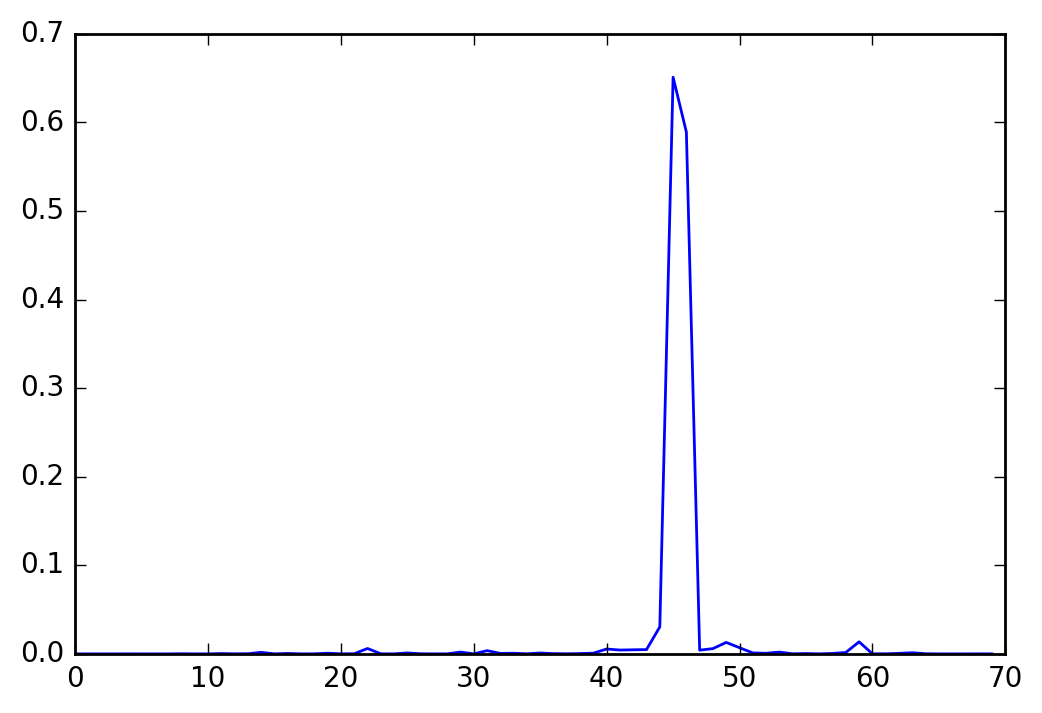

TTTTGGTCATTTGCATGGTGGTAGTCGTTACTGTGAATGGGGTCCAAGGGCTTTTTCTTACTTTCCTCAG
_____________________________________________B


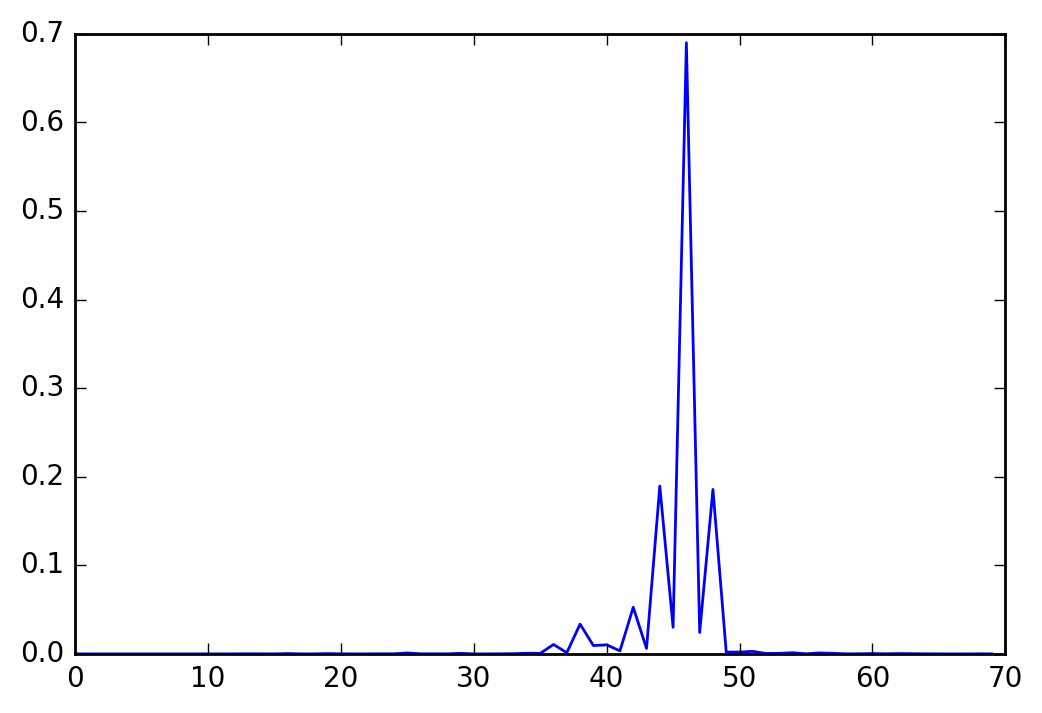

GGATGGGGACTCTGGGAGCAATGCCAGGGAGTCCCCACACCTCTAGACATGTCTCTGGTTGTGCTTTCAG
______________________________________________B


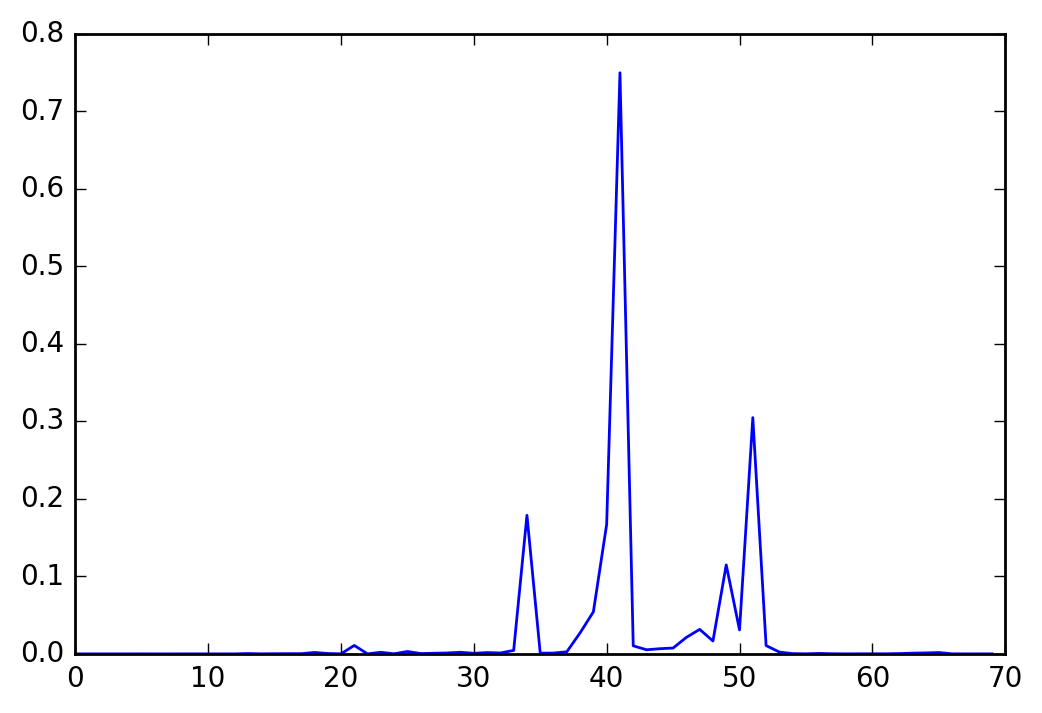

CTGGAGGCAGGTCAGGGGAAGAGTGTGTGGCTGCATGGCCCACGGGGGCTGCCCTTGGTTTTCTGCCCAG
_________________________________________B


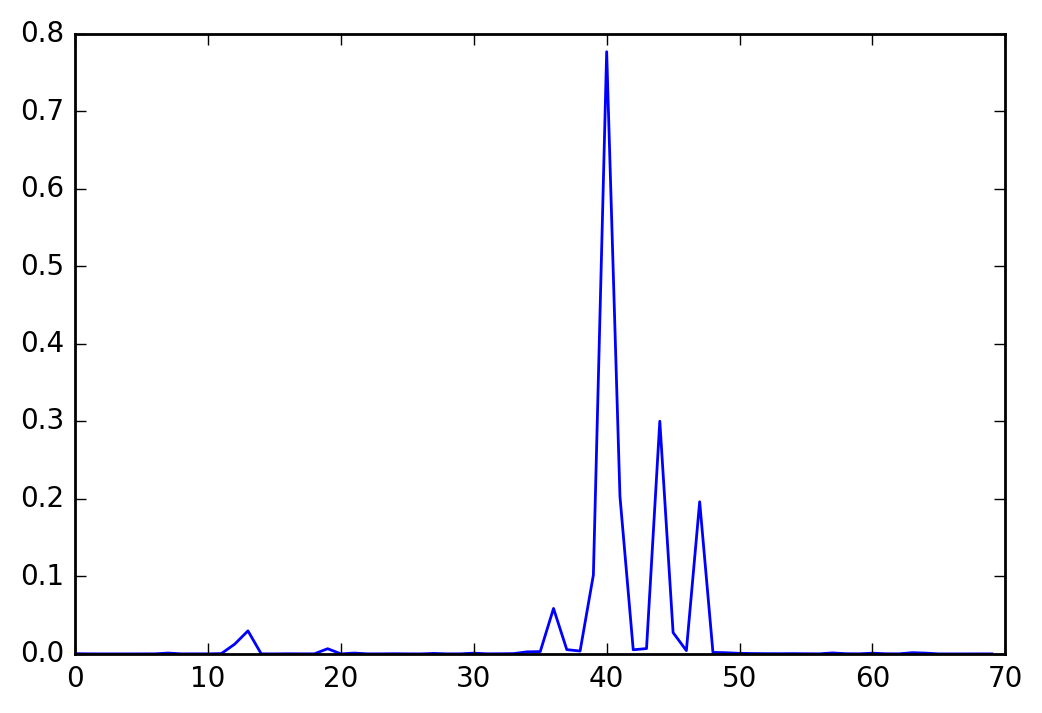

ATGCTGGATTTTAATTTTTATTGTGGTTGTACTTGGATGCAAGGAATATGTTTTGTTCCTCCCAATTTAG
________________________________________B


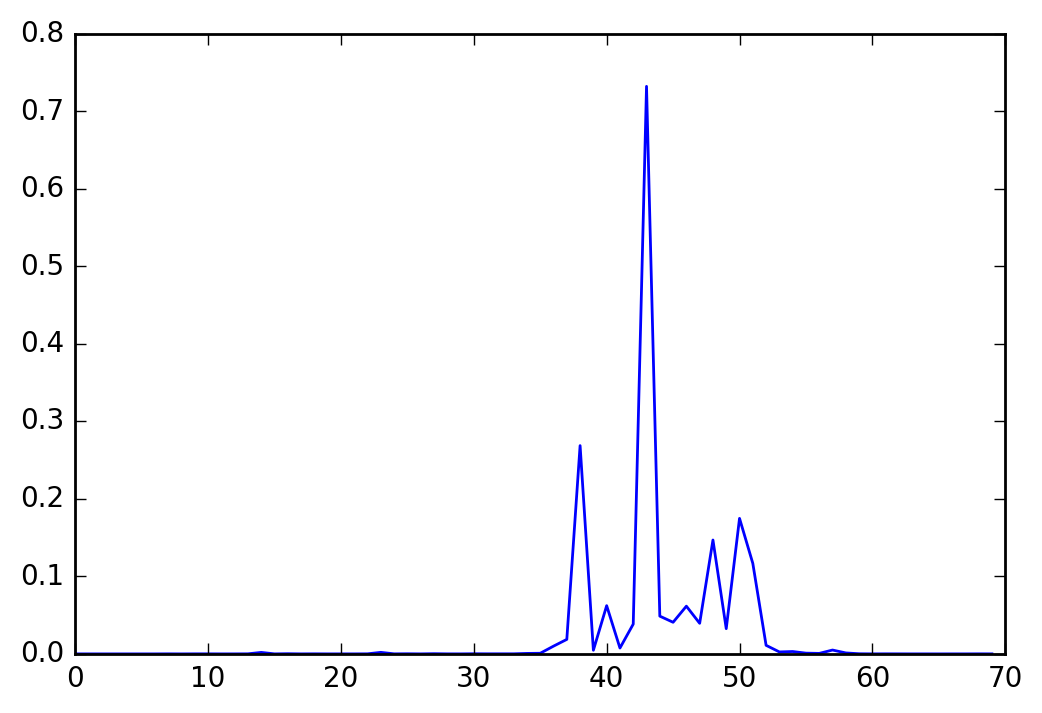

ATGCTTCAGAATTCAGAGGGTTCAGGGAATGGTTTCGGATAGTAGGCTCTCCCTGCTCCCTTCTCTACAG
___________________________________________B


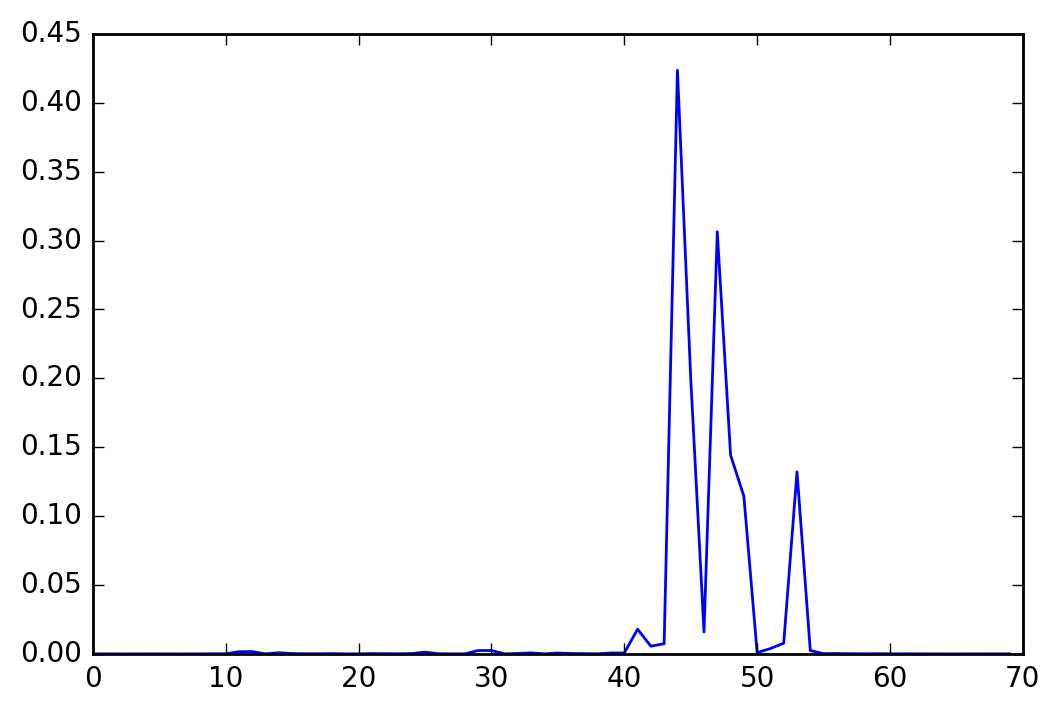

AACCAACTTCCAATACCCTTTGGCCATTTAATTGTTGTTTCTGTAACAAACTTAGTTTTGTGTTTTACAG
____________________________________________B


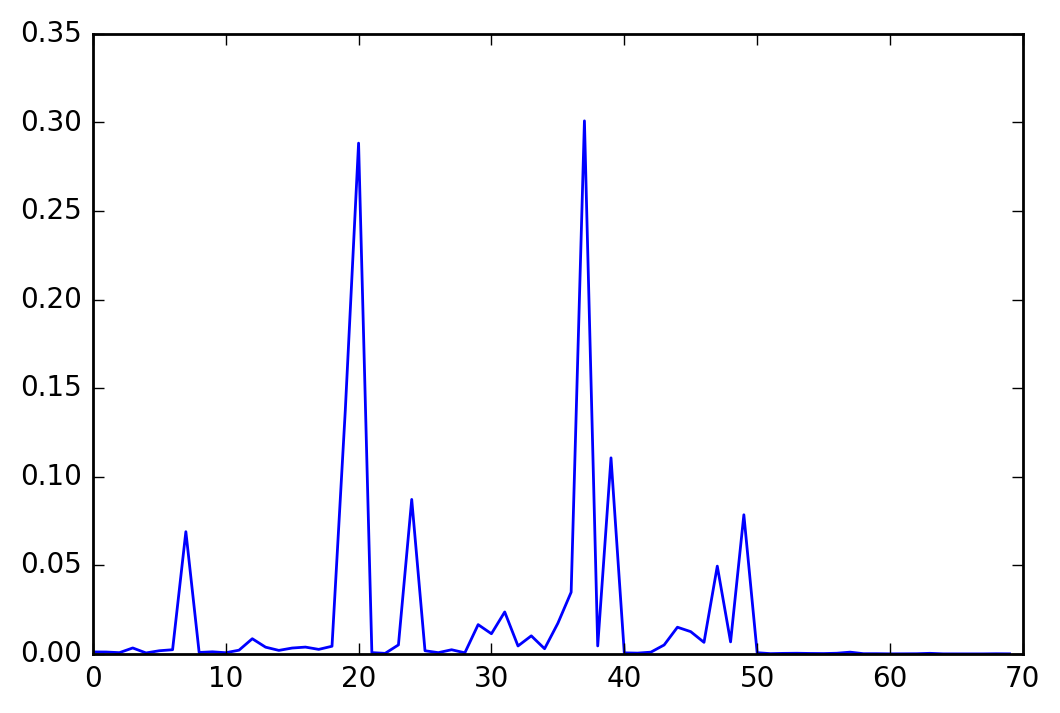

AATACTCACTTTGTTTTTTAATCTATGTCTGTCCCCGACATTTTCCTCCATGTGTTGCCCCGGATTTCAG
_____________________________________B


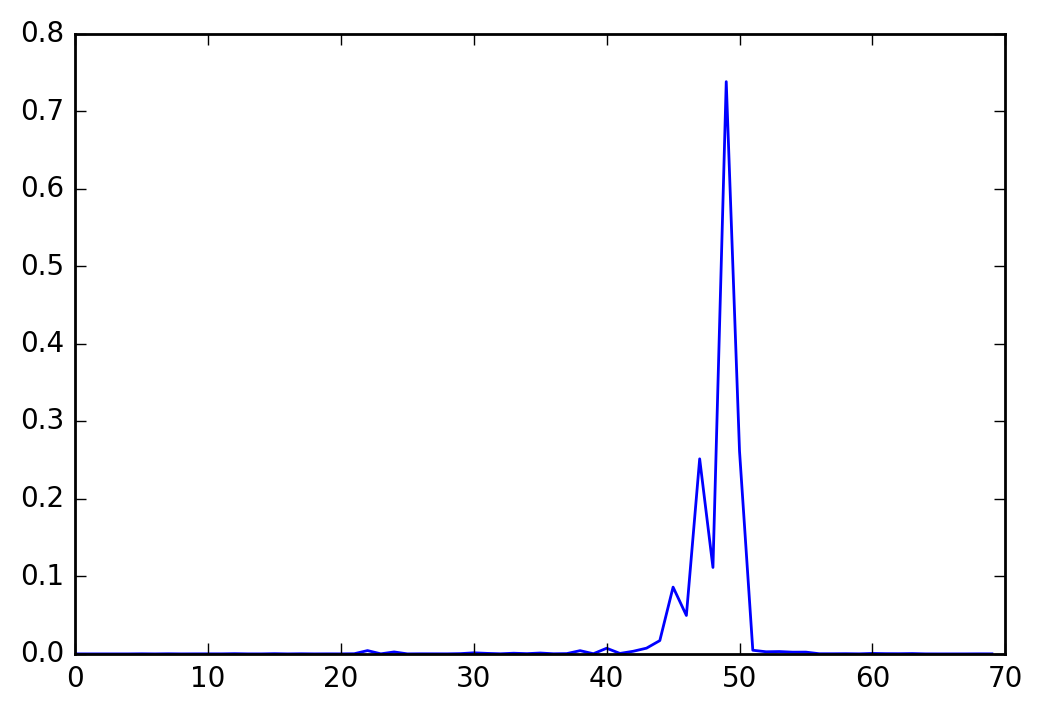

CCCCTGGTGTGGGGCAGGGTGCACAGTGCTGCTGGCGCAGACCCTCTCCAAGTCCCCTCTGTCCCTGCAG
_________________________________________________B


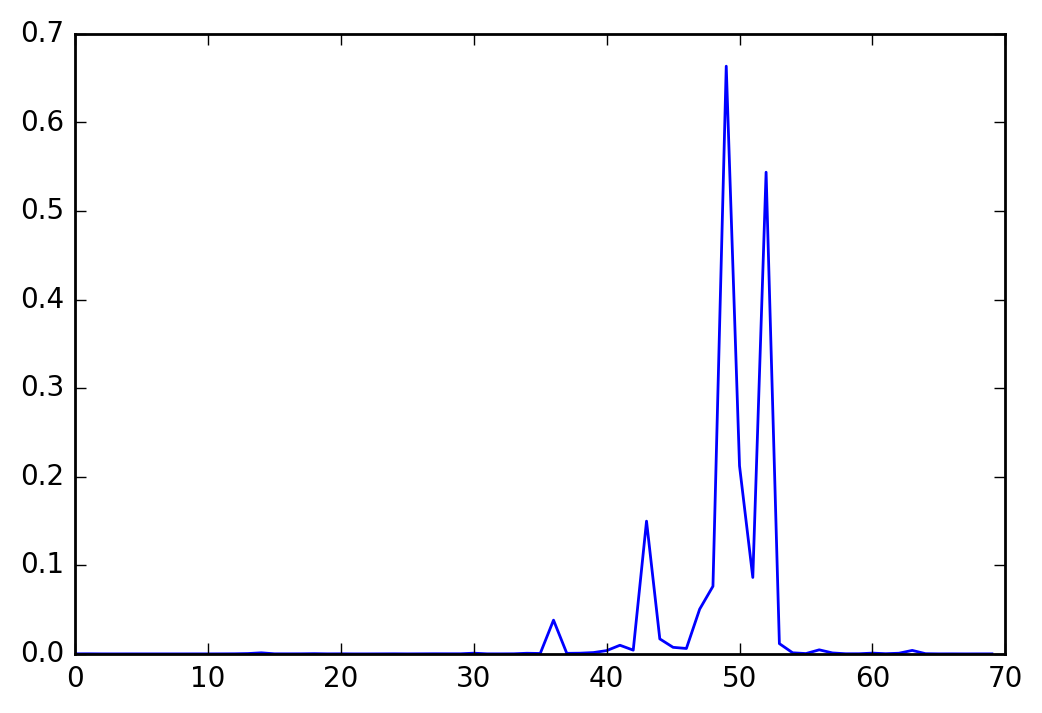

GATGGGCCCCCTGGATGGGGATTGGCTGGGAGGCTCAGGGGCCAGTGCCATCACCTGGCTCTTCCTCCAG
_________________________________________________B


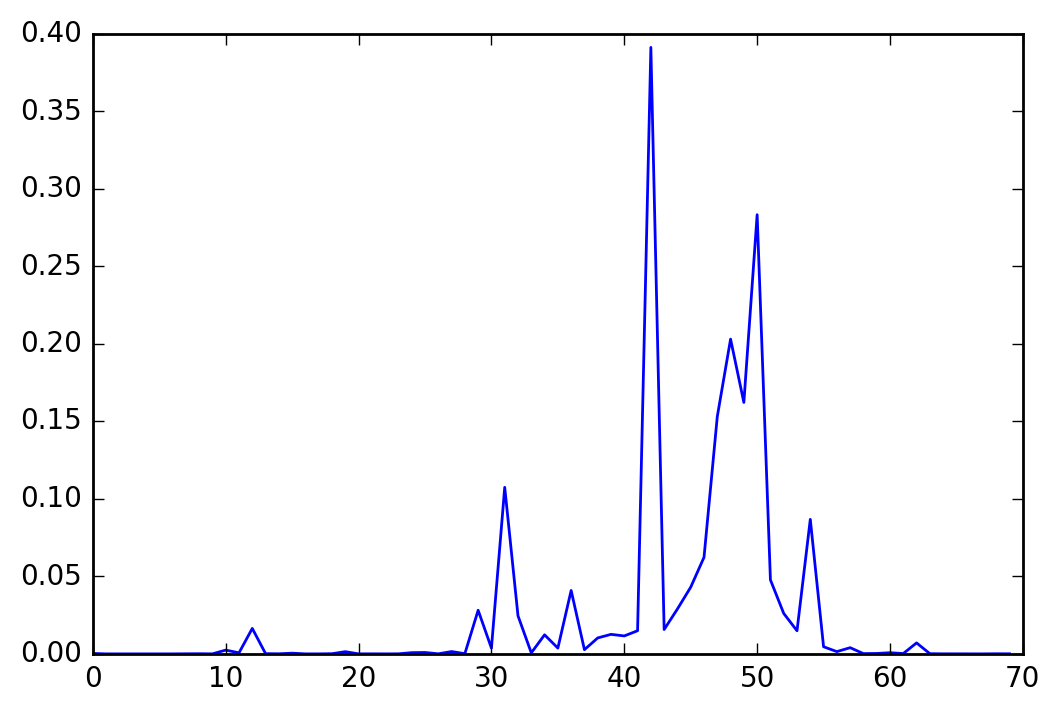

ACCCTCCATCTGAGGACCAAGCCCAACACTGAAGAGAGGCCCAGGGTCCCCCTGCCTCTTTCACTTTCAG
__________________________________________B


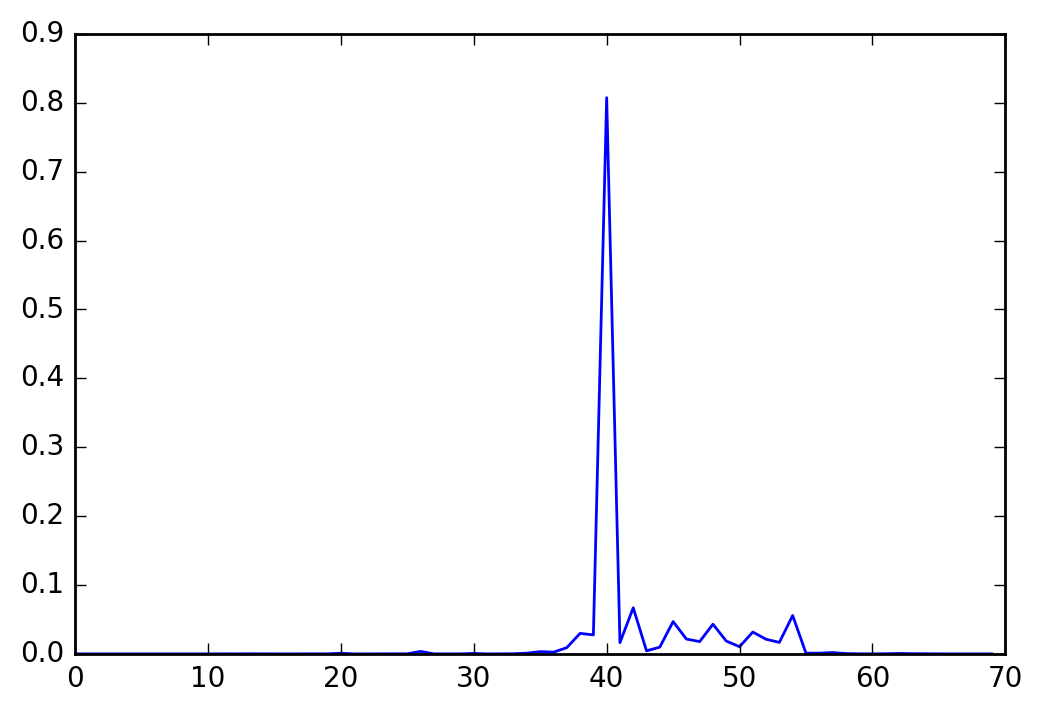

GGCCTGGGCTGGGAAACTGGAGCTGCAGGGATTGGGCTGGACAGGCCCCCTGCTCTGCCCTCGCCCCCAG
________________________________________B
38927


In [11]:
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if seq[bp-2, 3]: continue
    total += 1
    if total > 20: continue
    plt.plot(target)
    plt.show()
    print ''.join(map(lambda x: bases[np.argmax(x)], seq[:, :4]))
    print '_'*bp + 'B'
print total

# Gene Set enrichments

- No -2 T set covers most of the genome.

- C branchpoints don't seem to have any grouping into a given set of genes.

These sets yield some results, but I am very skeptical of large gene set enrichments, so I will not pursue this further.

In [12]:
from sklearn.utils import shuffle
# A Branchpoints
with open('A.txt', 'w') as fp:
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], a_genes):
        if seq[bp, 0]:
            fp.write(gene + '\n')
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], shuffle(a_genes)):
        if seq[bp, 0]:
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())

# C Branchpoints
with open('C.txt', 'w') as fp:
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], a_genes):
        if seq[bp, 1]:
            fp.write(gene + '\n')
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], shuffle(a_genes)):
        if seq[bp, 1]:
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())

# T at -2
with open('T_2.txt', 'w') as fp:
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], a_genes):
        if bp < 2: continue
        if seq[bp-2, 3]:
            fp.write(gene + '\n')
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], shuffle(a_genes)):
        if bp < 2: continue
        if seq[bp-2, 3]:
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())

# no T at -2
with open('no_T_2.txt', 'w') as fp:
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], a_genes):
        if bp < 2: continue
        if not seq[bp-2, 3]:
            fp.write(gene + '\n')
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], shuffle(a_genes)):
        if bp < 2: continue
        if not seq[bp-2, 3]:
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())

18547 202813
18559 202813
2695 3352
2896 3352
18252 167365
18272 167365
13705 38922
13856 38922


## Conservation Meta

18009
42860
52632
47170
30183
12178
2694
181
1
0
0


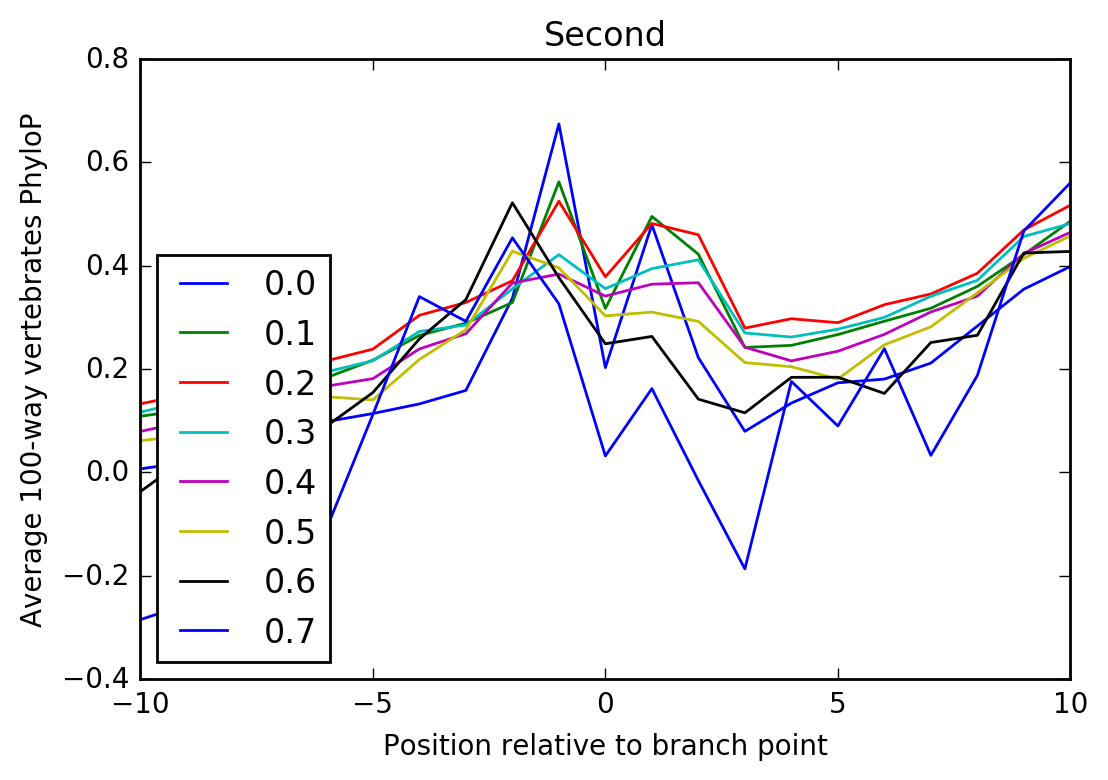

In [119]:
K = 10
def cons_second(X, y, idx, thresh):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp1 = np.argmax(target)
        bp2 = np.argmax(np.hstack([target[:bp1], np.zeros((1,)), target[bp1+1:]]))
        if not thresh < target[bp2] <= thresh+.1: continue
        if 0 > bp2-K or bp2+K+1 > seq.shape[0]: continue
        counts += seq[bp2-K: bp2+K+1, idx]
        total += 1
    print total
    return counts, total
for thresh in np.linspace(0, 1, 11):
    counts, total = cons_second(X_all, y_all, 5, thresh)
    if total < 100: continue
    plt.plot(range(-K, K+1), counts/total, label = thresh)
plt.legend(loc = 3)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhyloP')
plt.title('Second')
plt.show()

4933
14374
19944
19189
12235
4697
1058
56
0
0
0


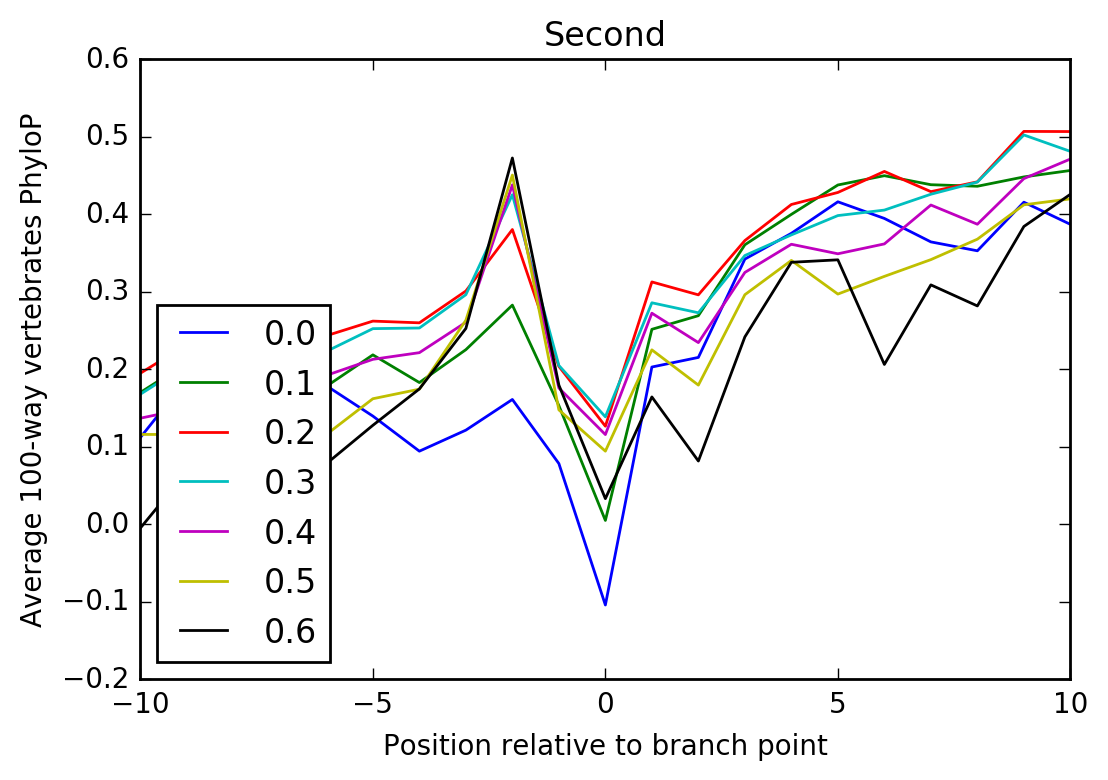

In [118]:
K = 10
def cons_second(X, y, idx, thresh):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp1 = np.argmax(target)
        bp2 = np.argmax(np.hstack([target[:bp1], np.zeros((1,)), target[bp1+1:]]))
        if abs(bp2-bp1) < 5: continue
        if not thresh < target[bp2] <= thresh+.1: continue
        if 0 > bp2-K or bp2+K+1 > seq.shape[0]: continue
        counts += seq[bp2-K: bp2+K+1, idx]
        total += 1
    print total
    return counts, total
for thresh in np.linspace(0, 1, 11):
    counts, total = cons_second(X_all, y_all, 5, thresh)
    if total < 100: continue
    plt.plot(range(-K, K+1), counts/total, label = thresh)
plt.legend(loc = 3)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhyloP')
plt.title('Second')
plt.show()

44810


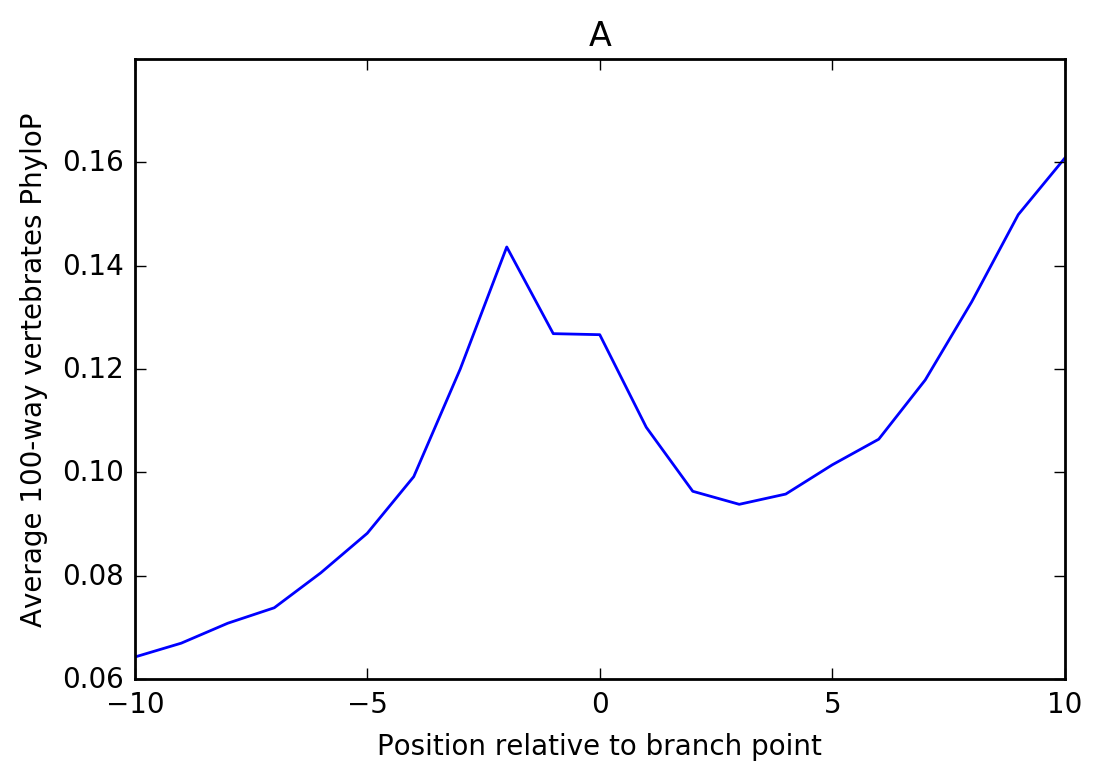

4815


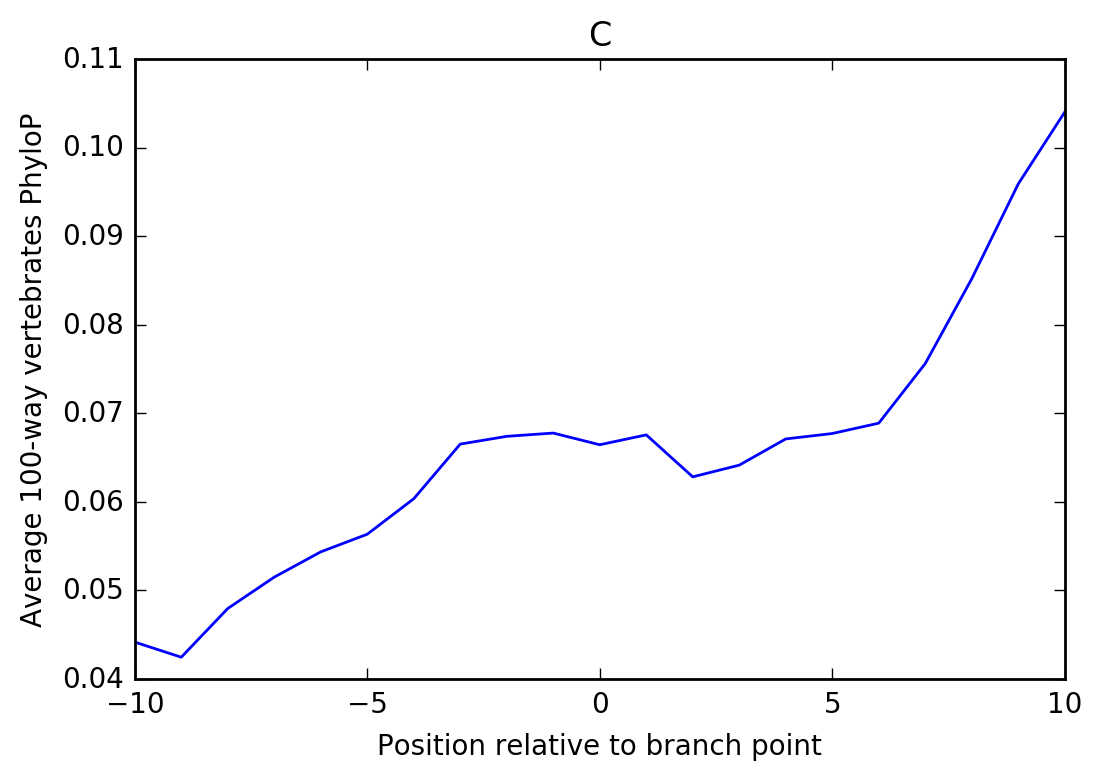

2424


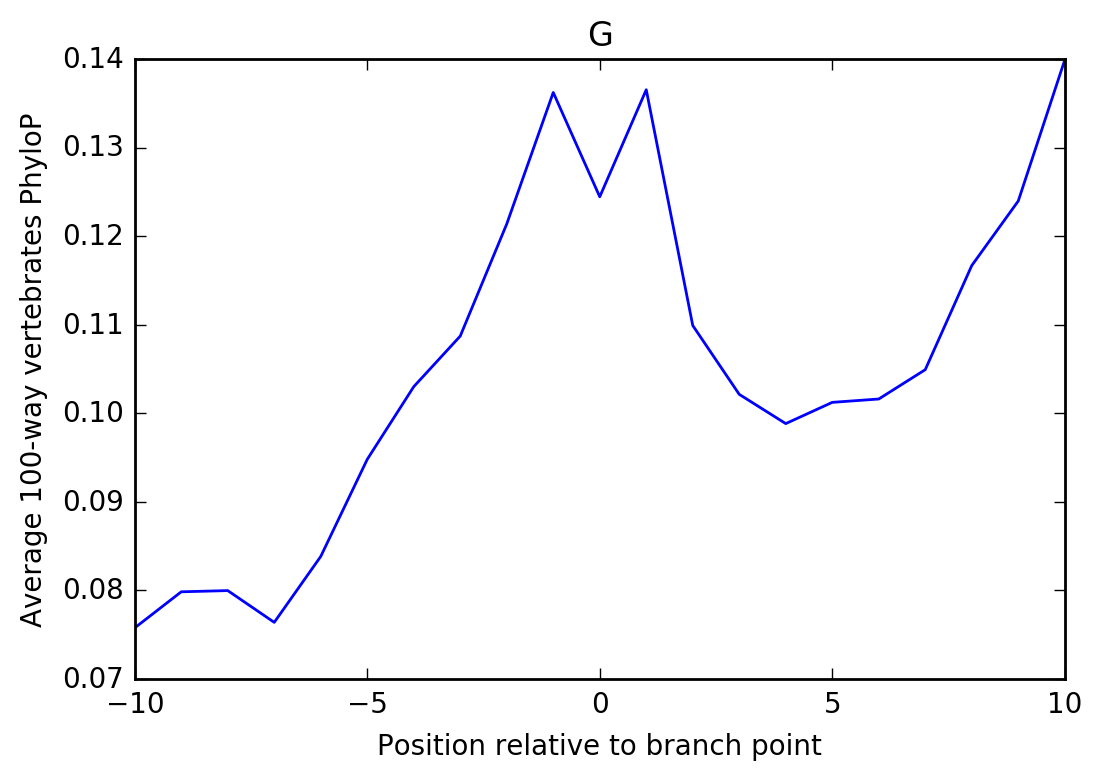

4568


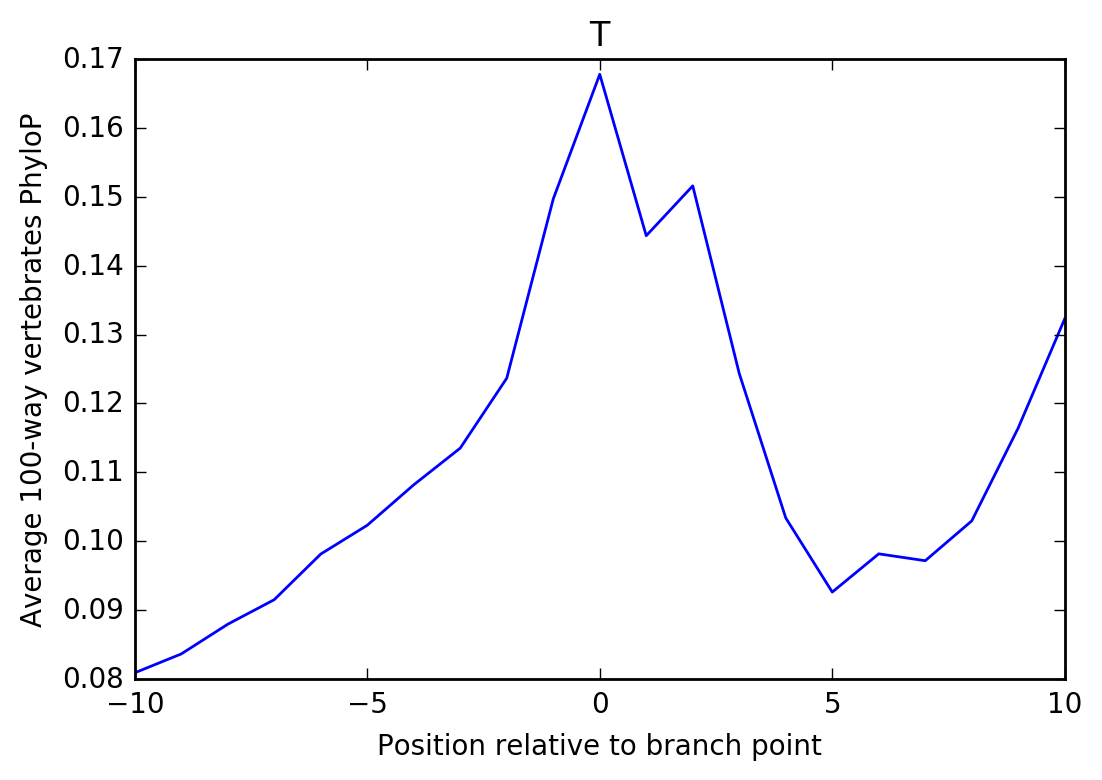

44810


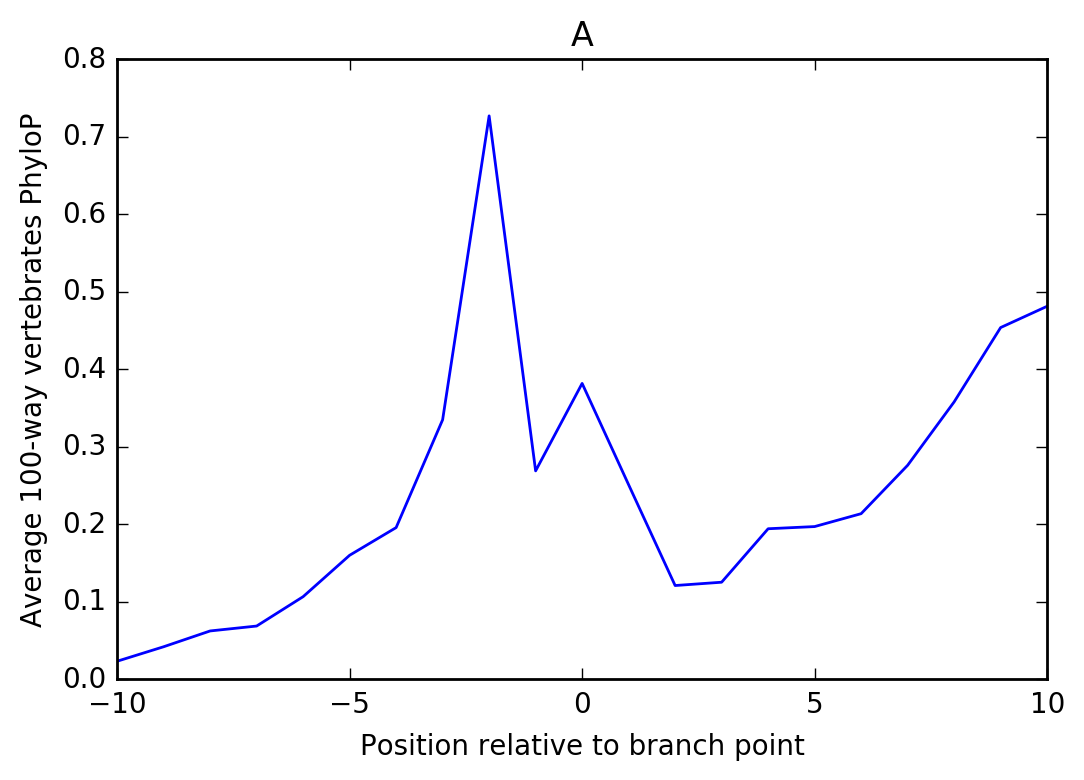

4815


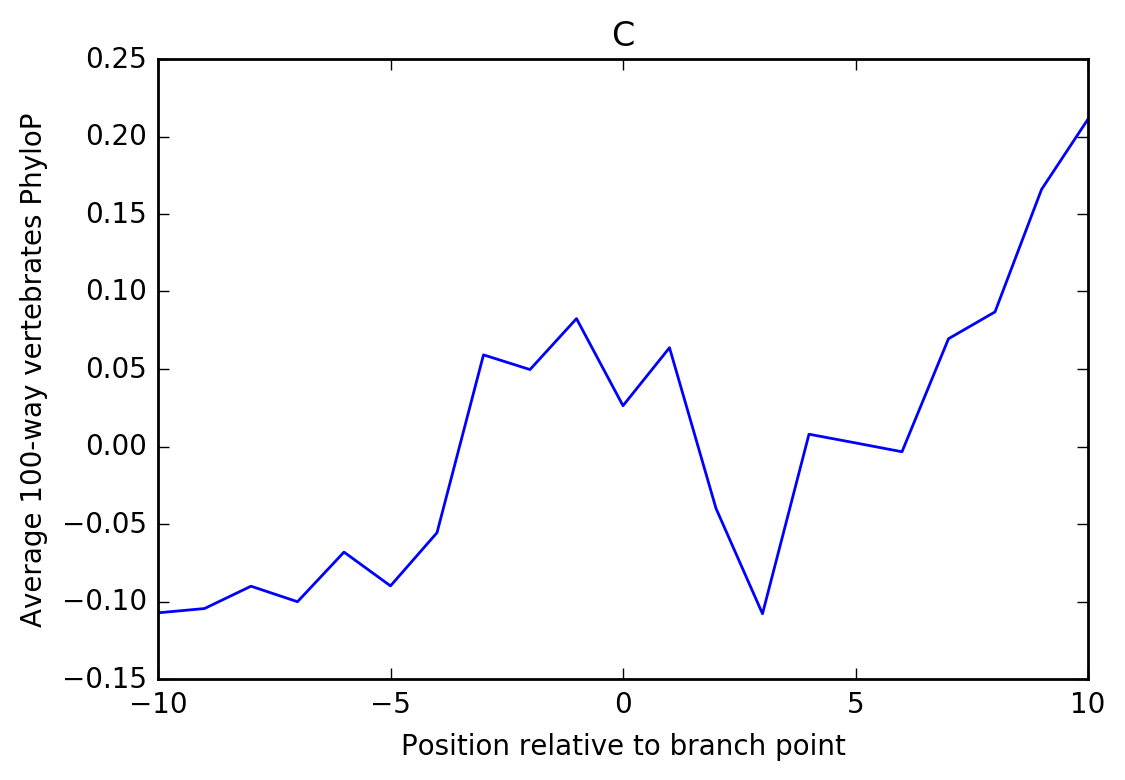

2424


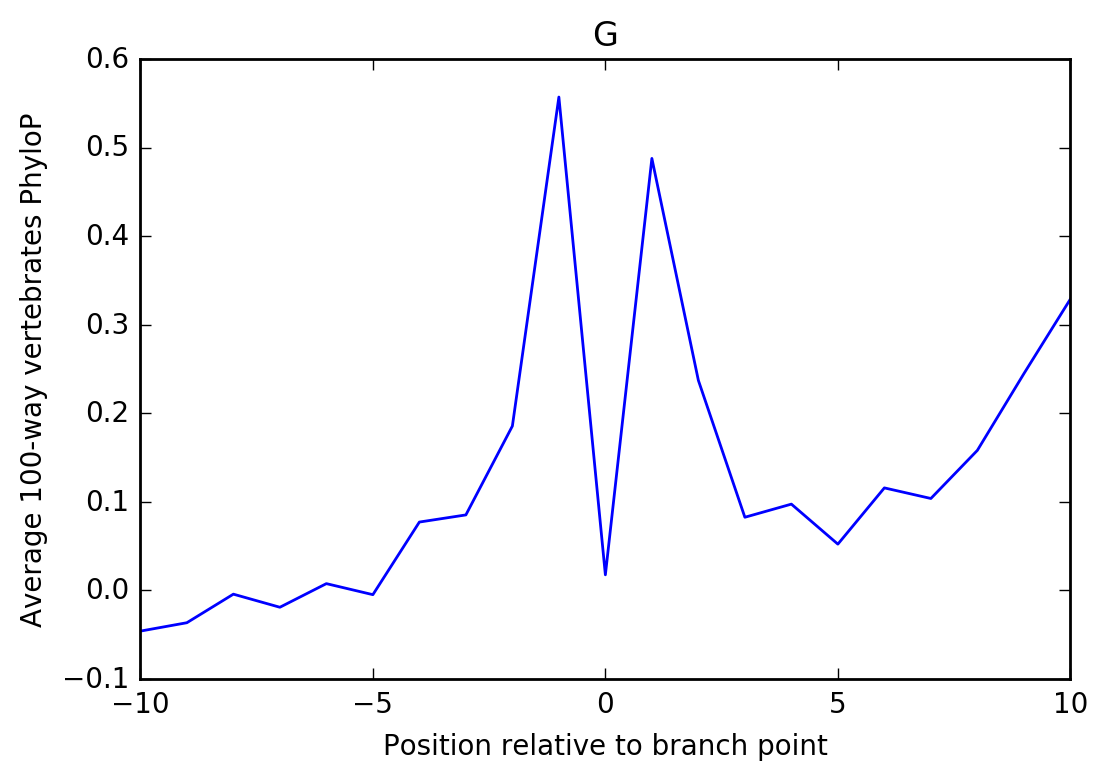

4568


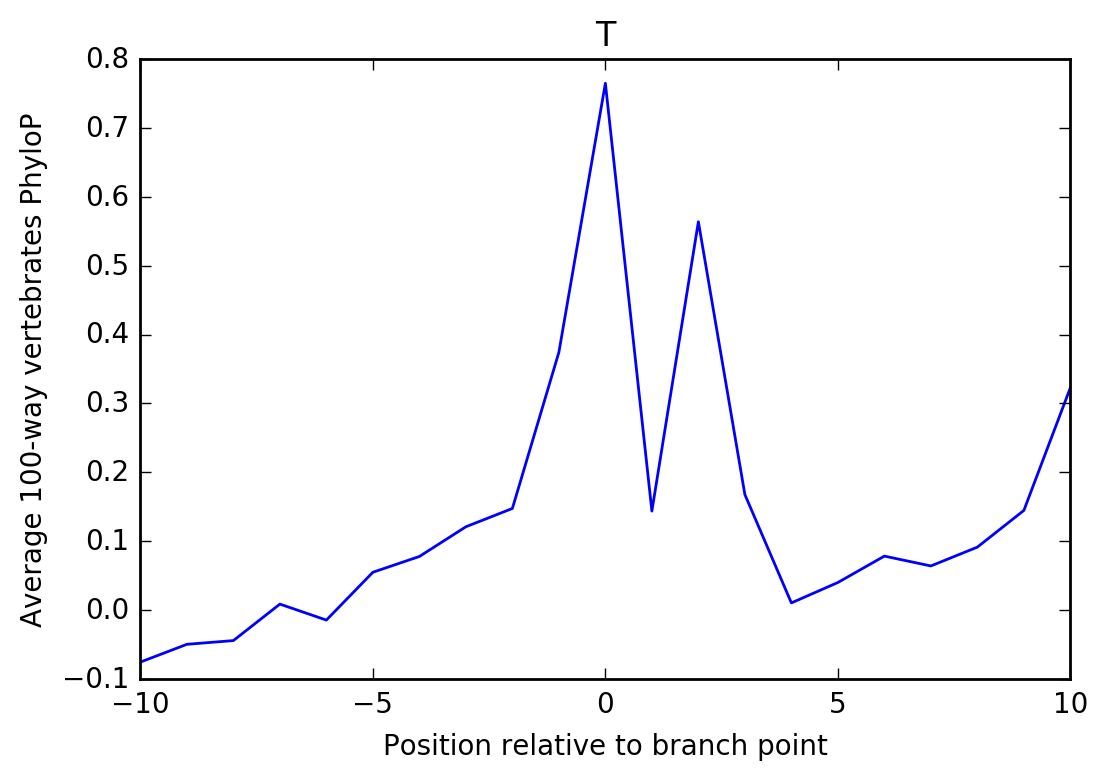

44810


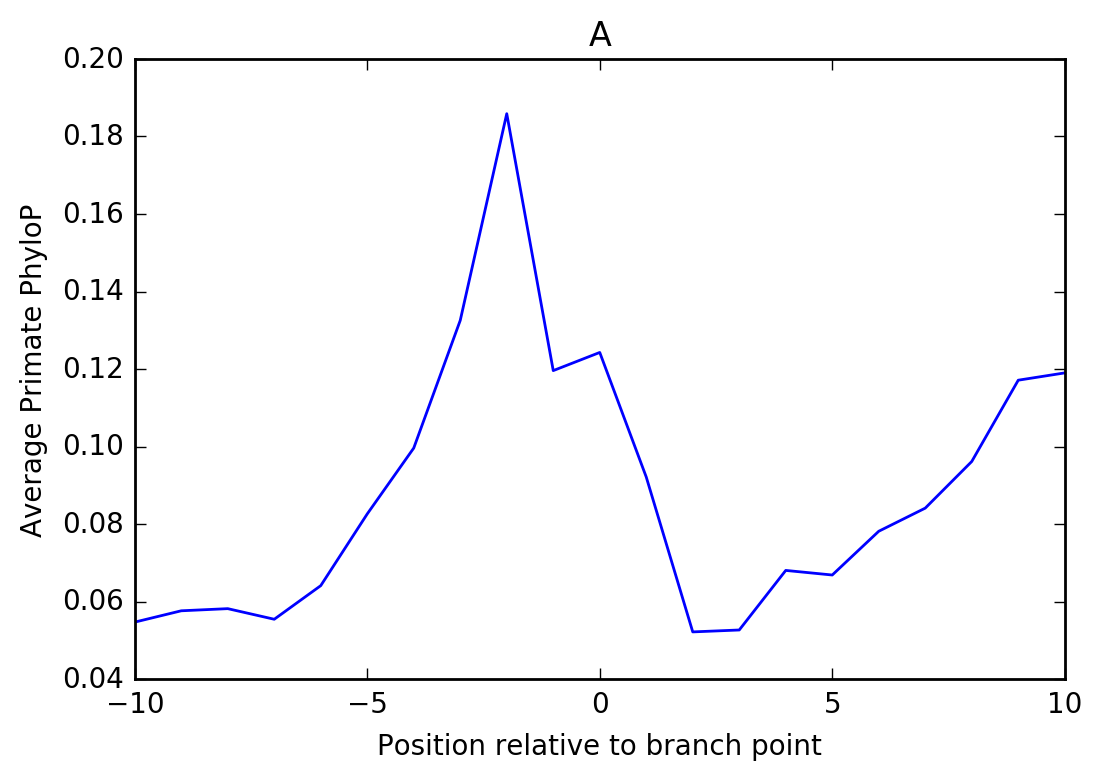

4815


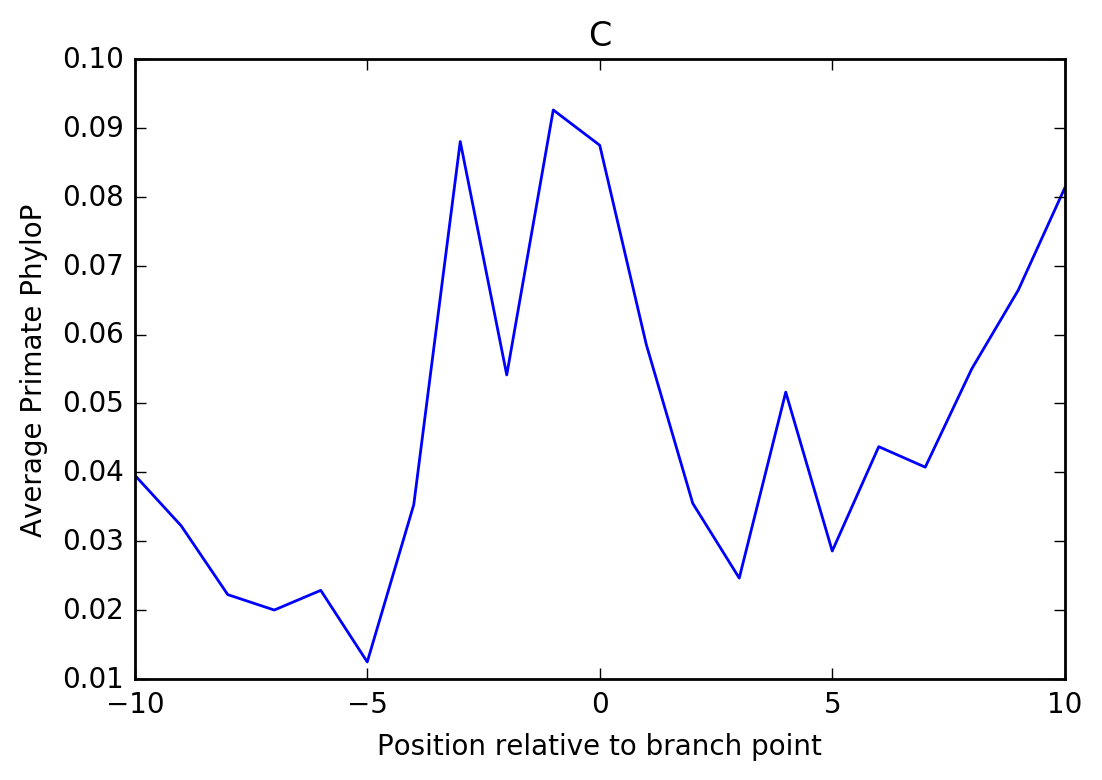

2424


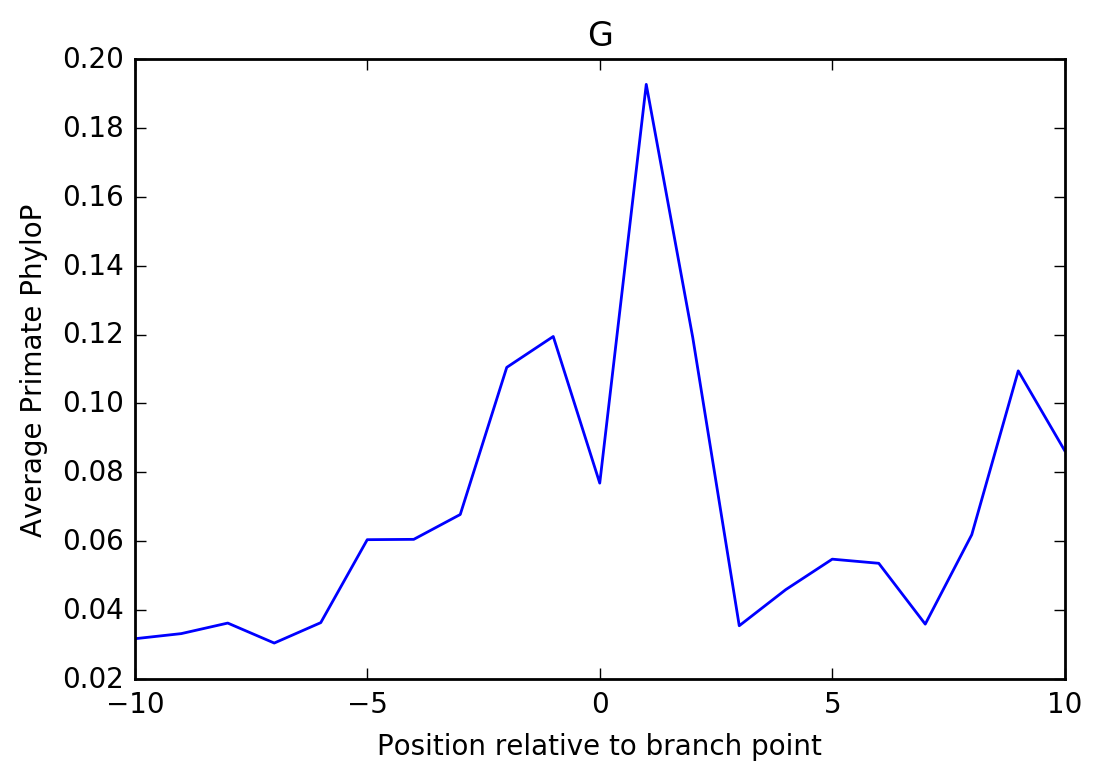

4568


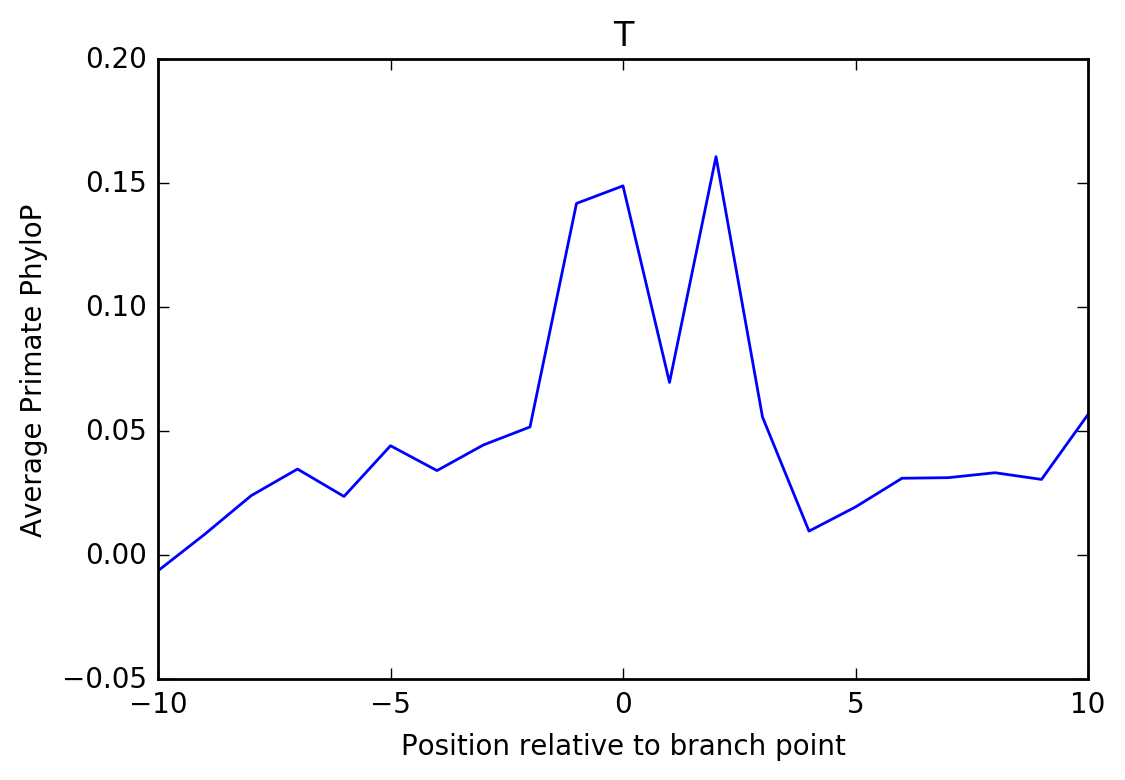

In [13]:
# By BP nucleotide

def cons_known_base(X, y, idx, base):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if not seq[bp, base]: continue
            counts += seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

K = 10
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
             cons_known_base(X_known, y_known, 4, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_known_base(X_known, y_known, 5, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_known_base(X_known, y_known, 6, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average Primate PhyloP')
    plt.title(base)
    plt.show()

202549


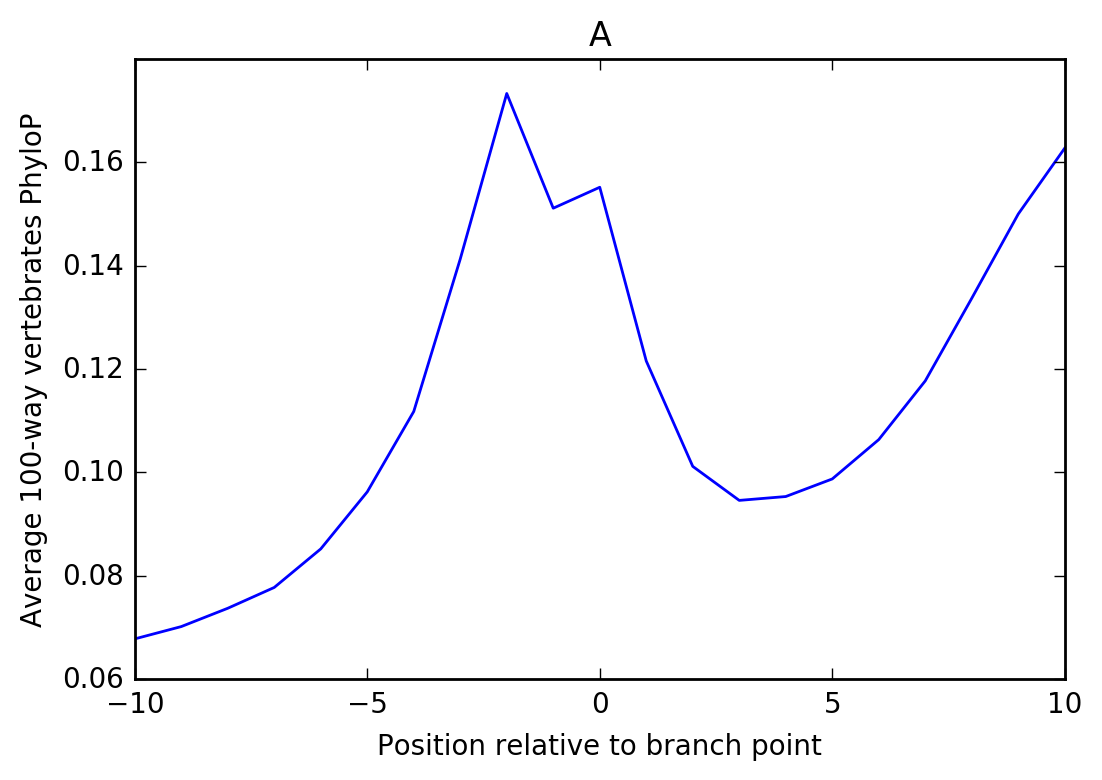

3347


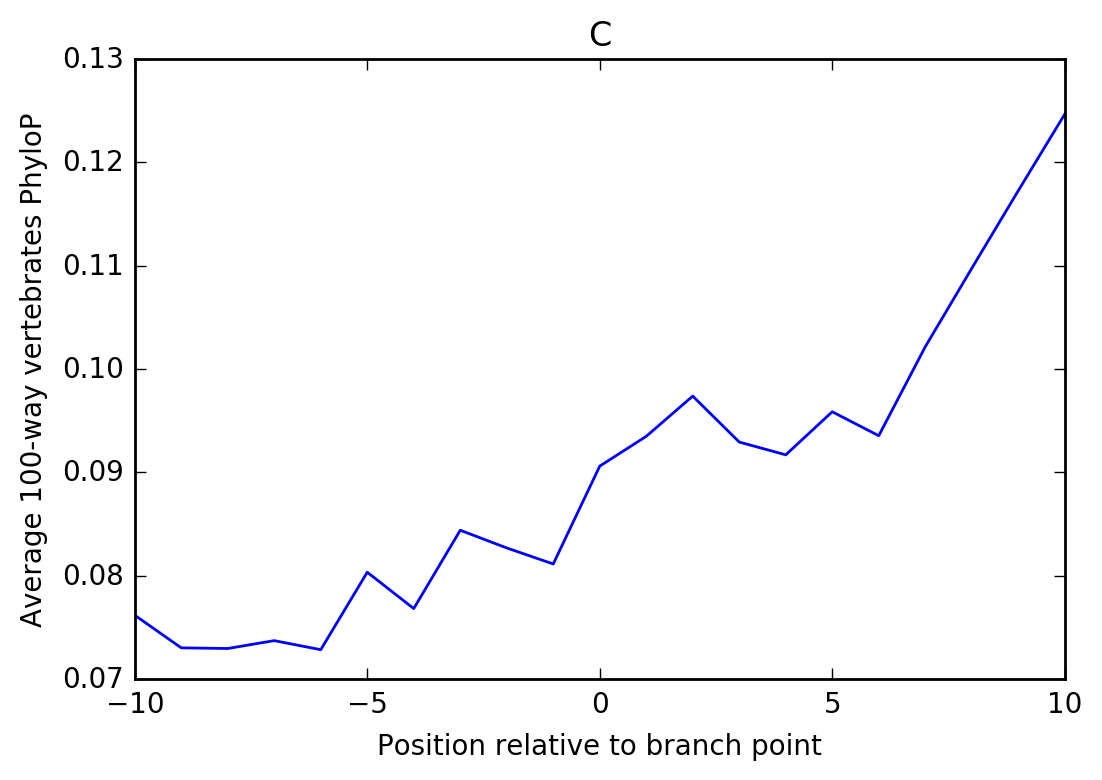

57


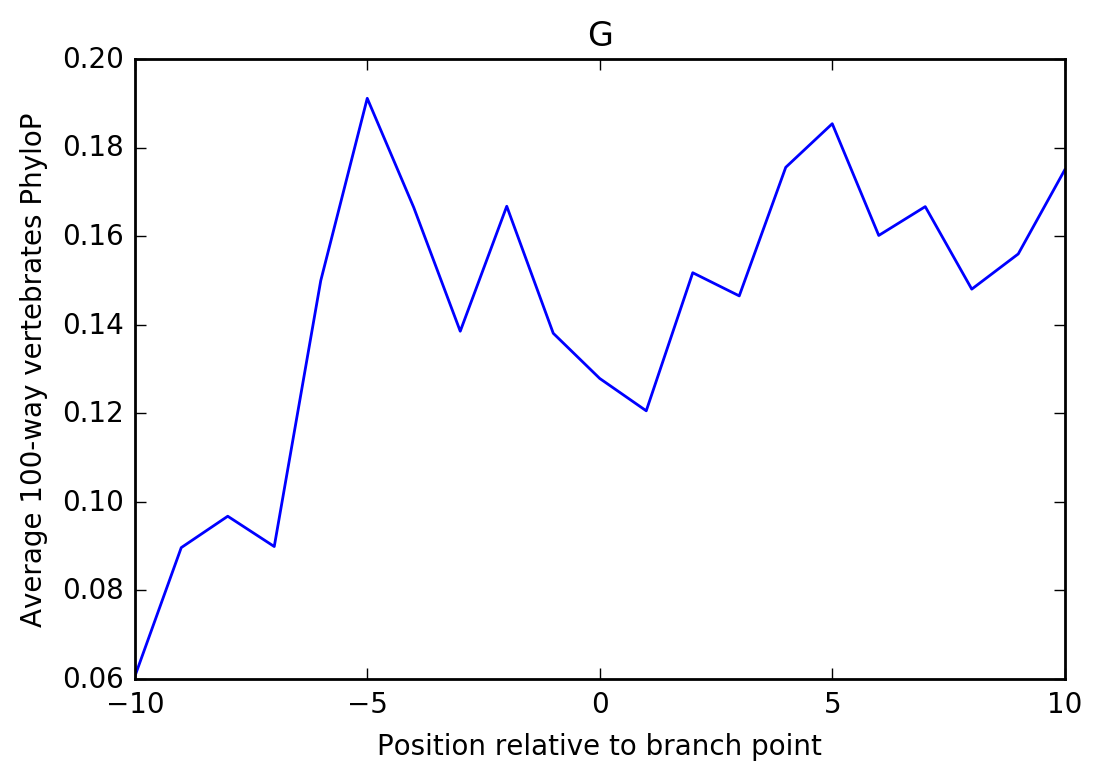

69


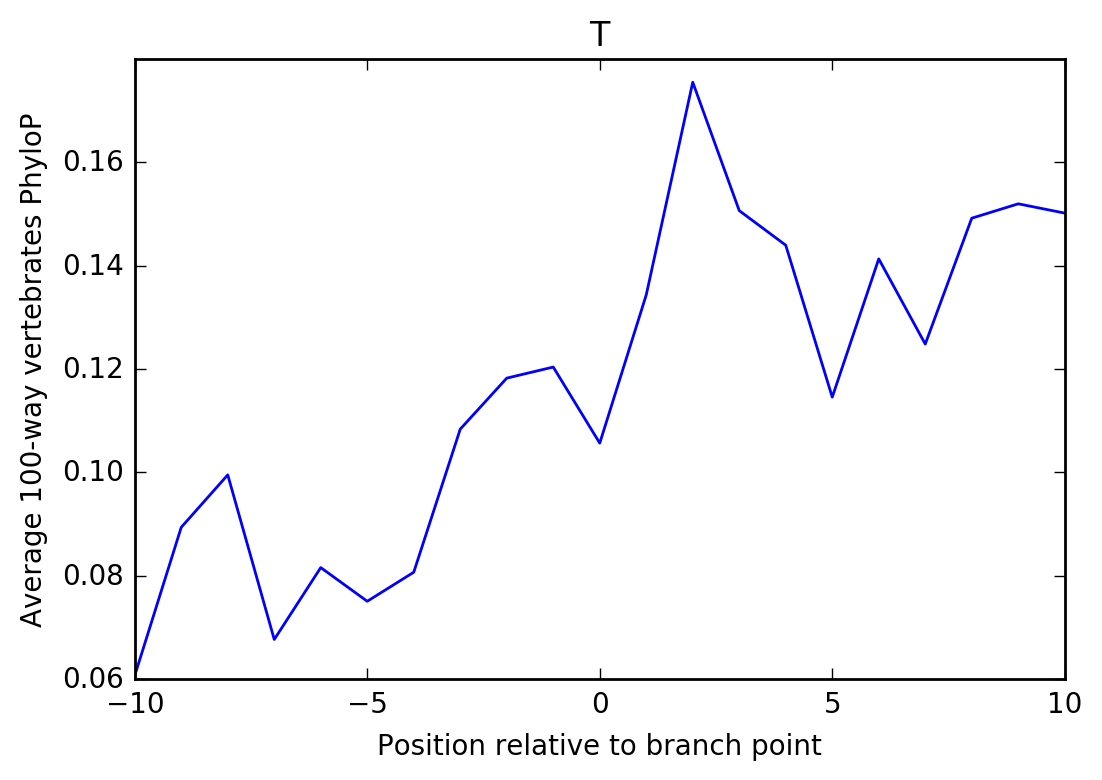

202549


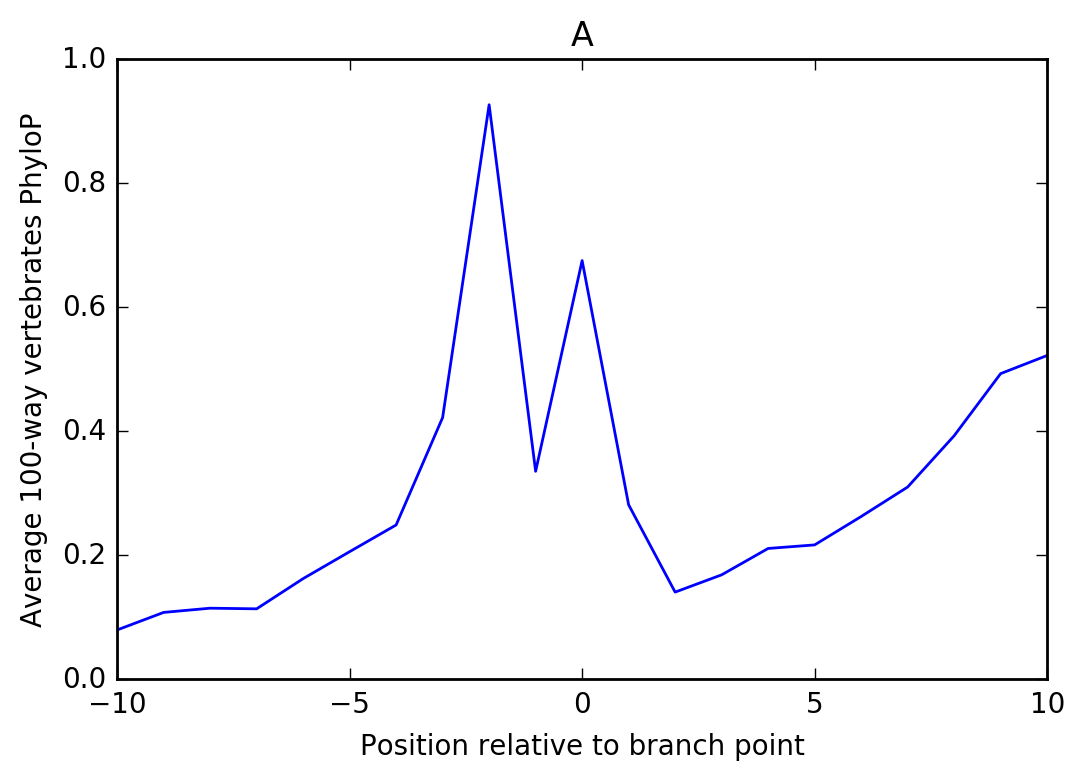

3347


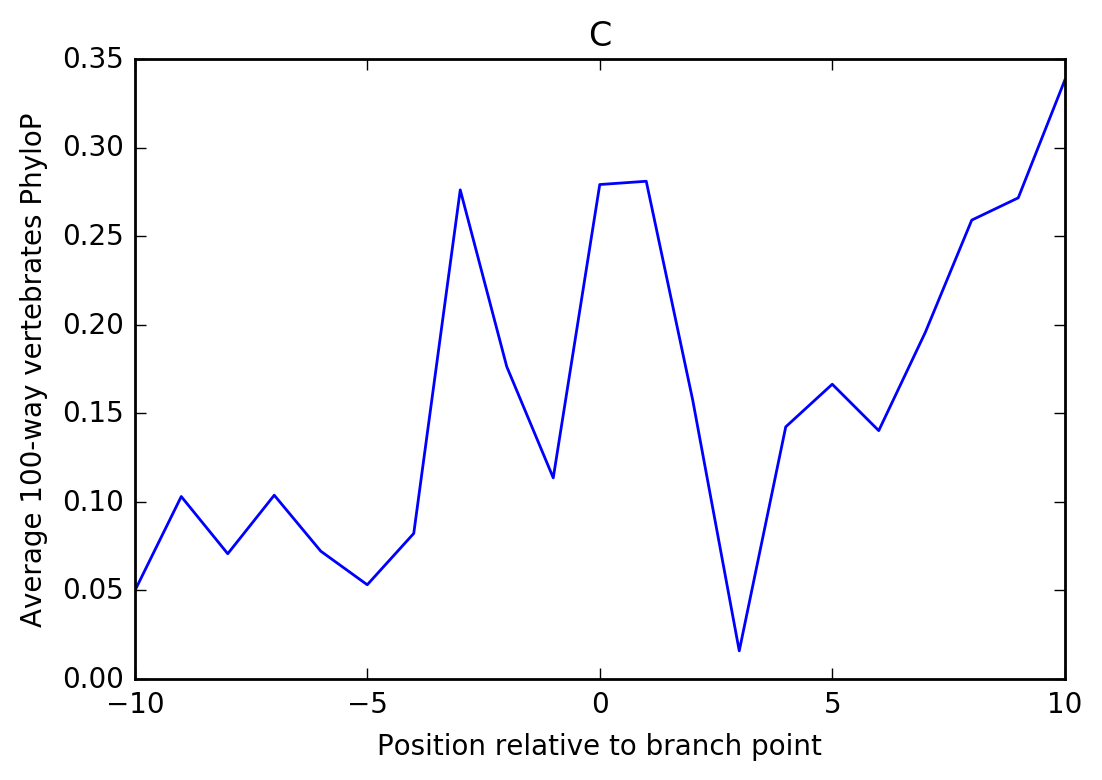

57


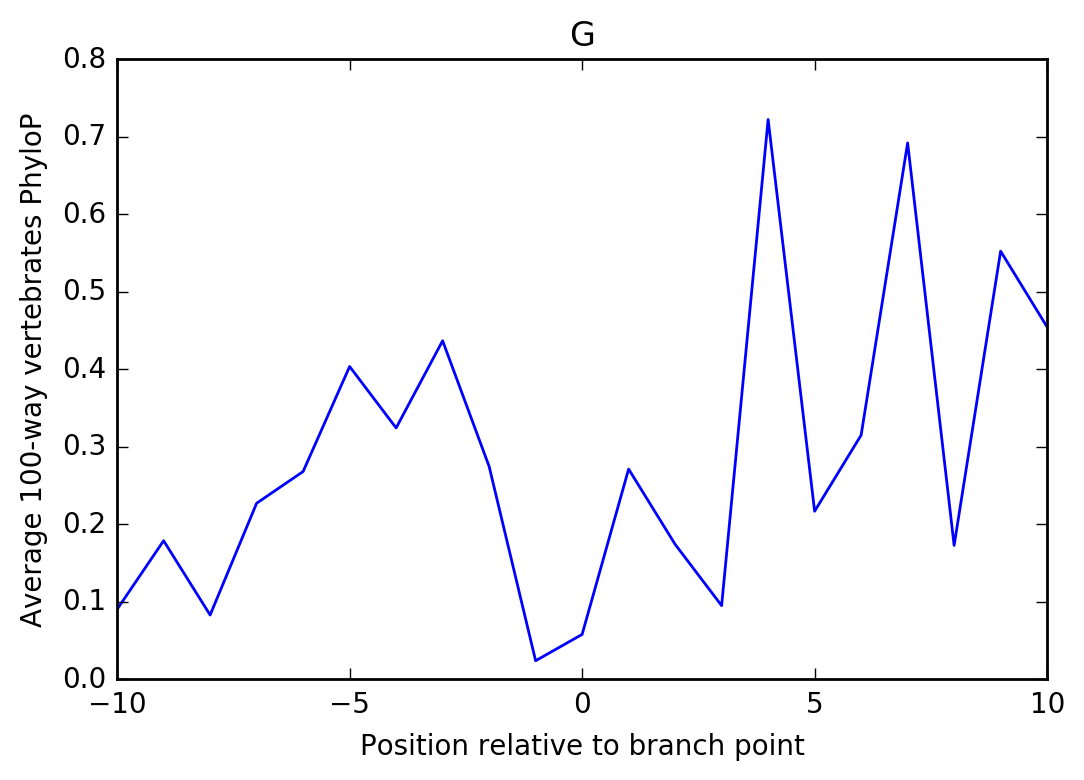

69


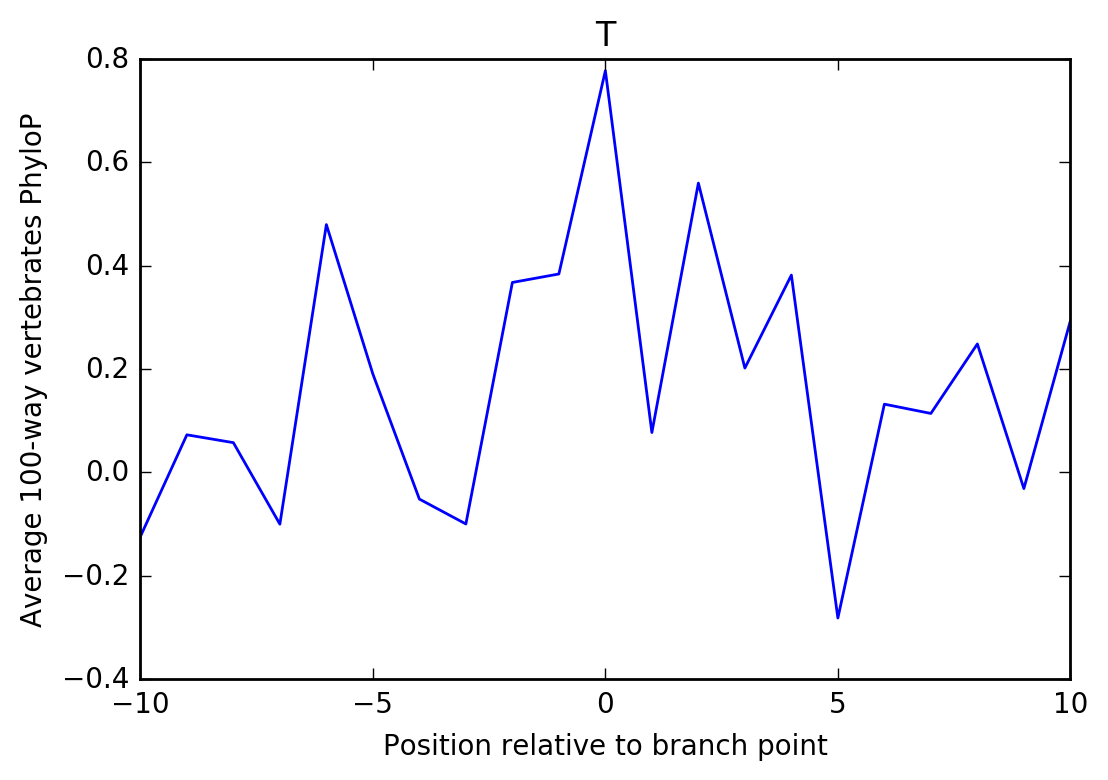

202549


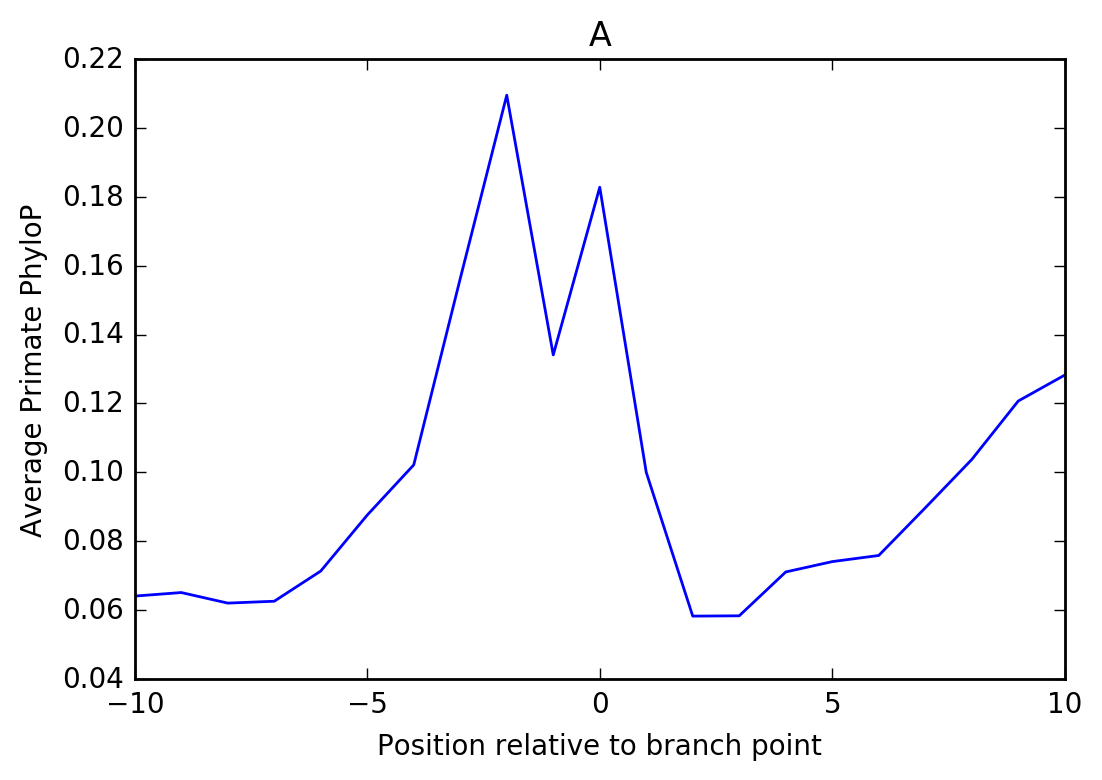

3347


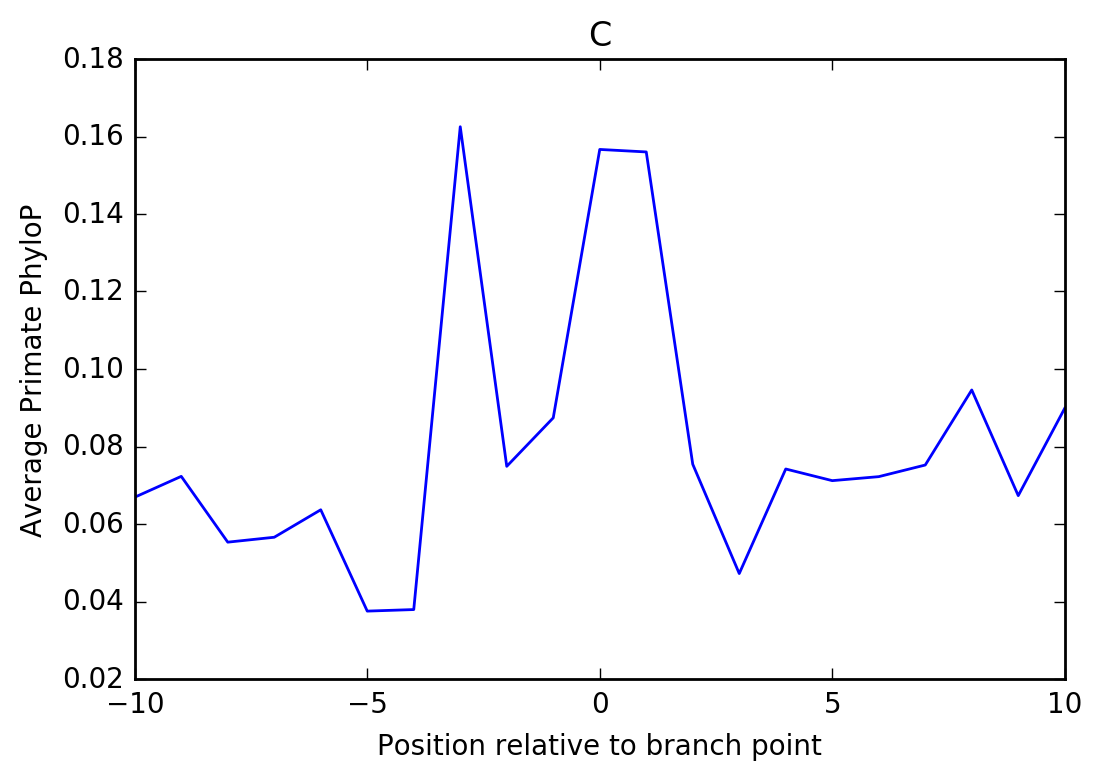

57


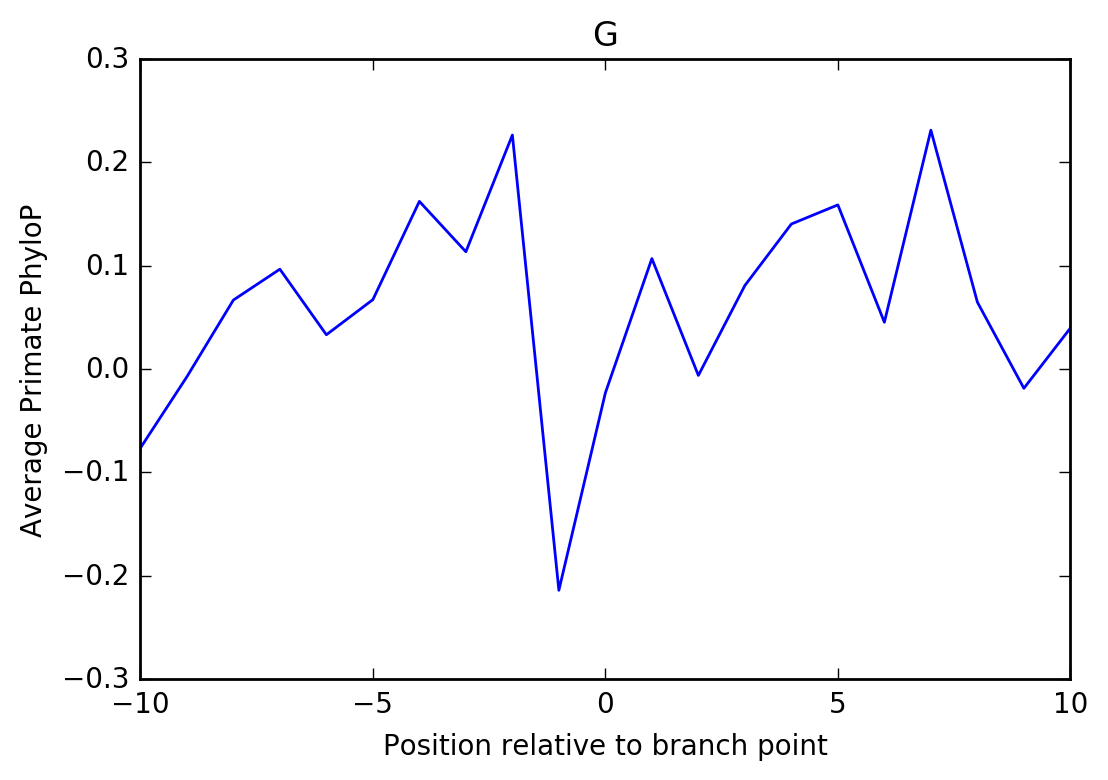

69


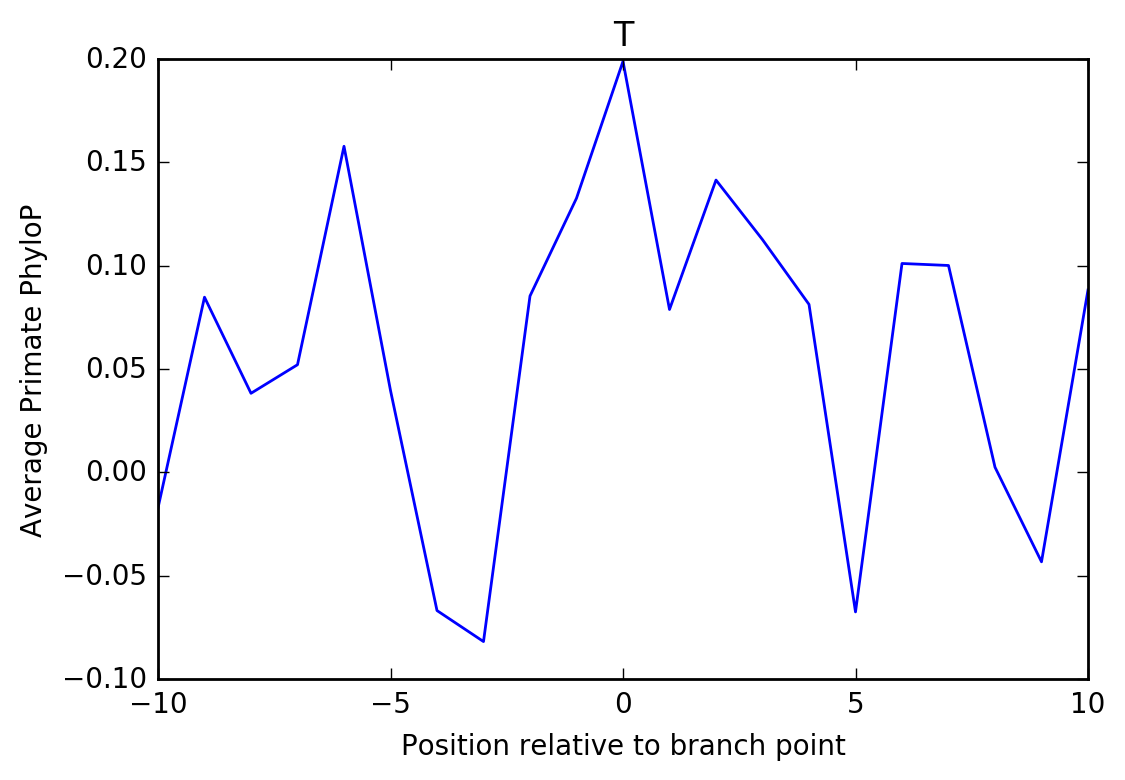

In [14]:
# By BP nucleotide

def cons_novel_base(X, y, idx, base):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if not seq[bp, base]: continue
        counts += seq[bp-K: bp+K+1, idx]
        total += 1
    print total
    return counts / total

K = 10
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
             cons_novel_base(X_all, y_all, 4, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_novel_base(X_all, y_all, 5, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_novel_base(X_all, y_all, 6, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average Primate PhyloP')
    plt.title(base)
    plt.show()

34080
22537


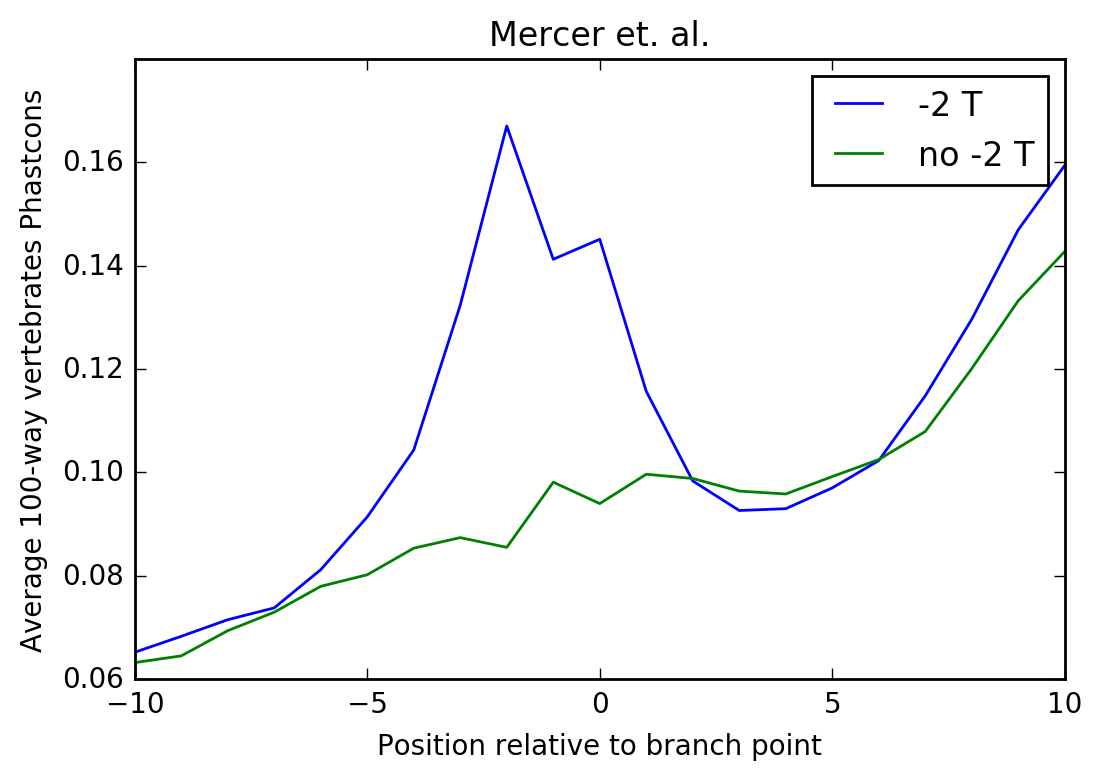

34080
22537


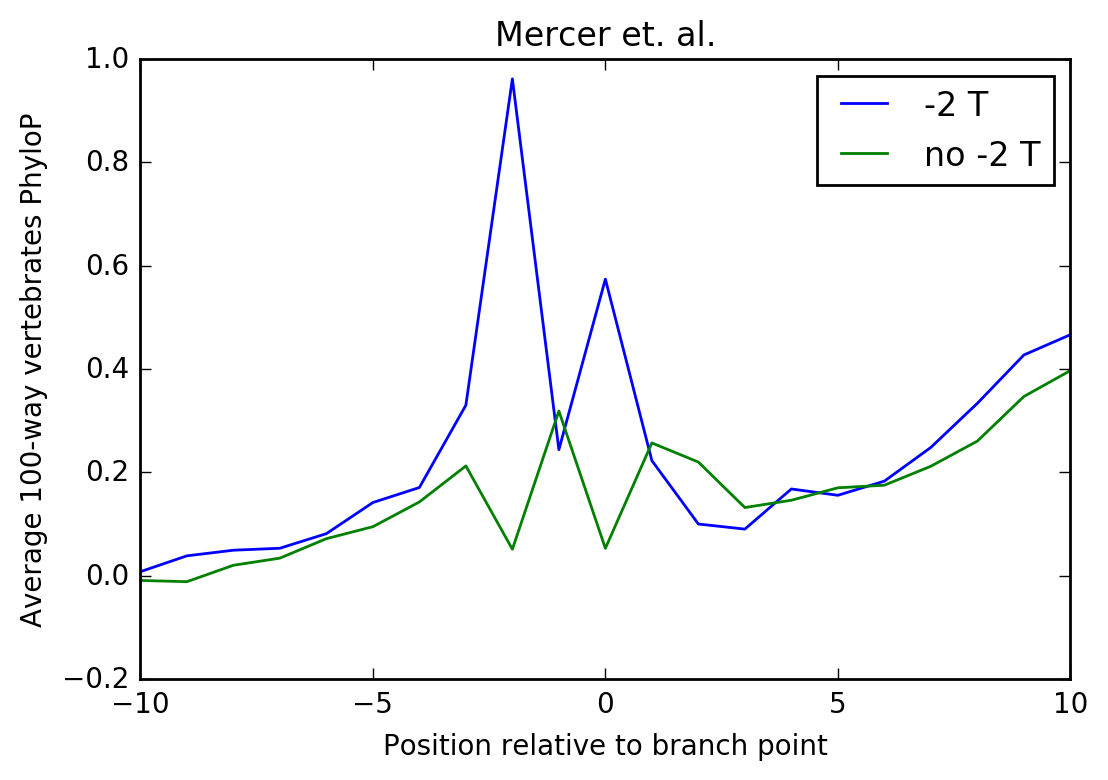

34080
22537


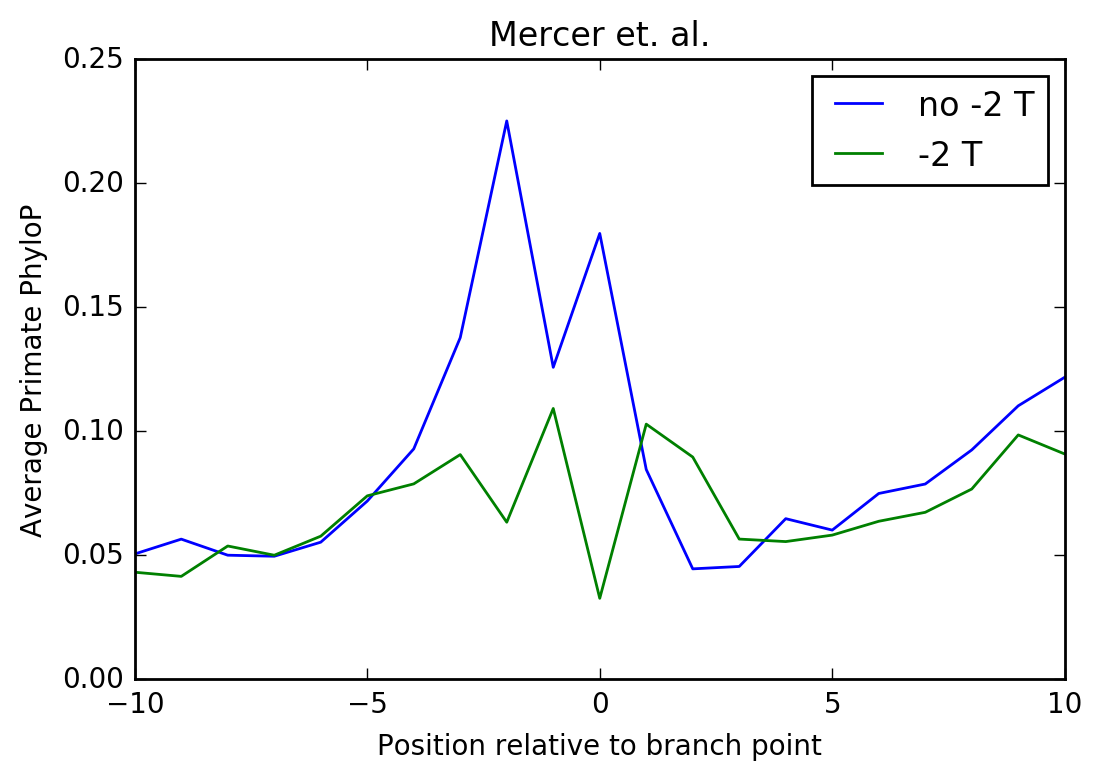

In [45]:
# No -2 T

def cons_known_T(X, y, idx, T):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if T==seq[bp-2, 3]: continue
            counts += seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

for t, name in enumerate(['-2 T','no -2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_known_T(X_known, y_known, 4, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates Phastcons')
plt.title('Mercer et. al.')
plt.legend(loc = 'best')
plt.show()

for t, name in enumerate(['-2 T','no -2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_known_T(X_known, y_known, 5, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhyloP')
plt.title('Mercer et. al.')
plt.legend(loc = 'best')
plt.show()

for t, name in enumerate(['no -2 T','-2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_known_T(X_known, y_known, 6, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average Primate PhyloP')
plt.title('Mercer et. al.')
plt.legend(loc = 'best')
plt.show()

167172
38850


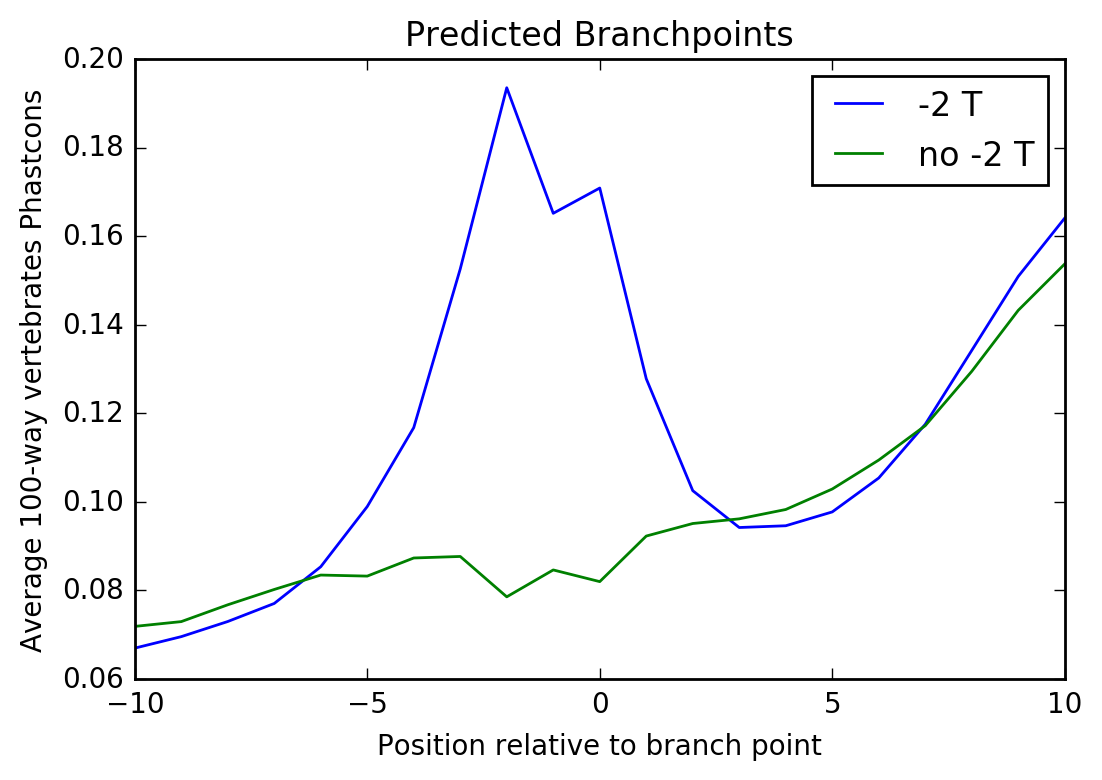

167172
38850


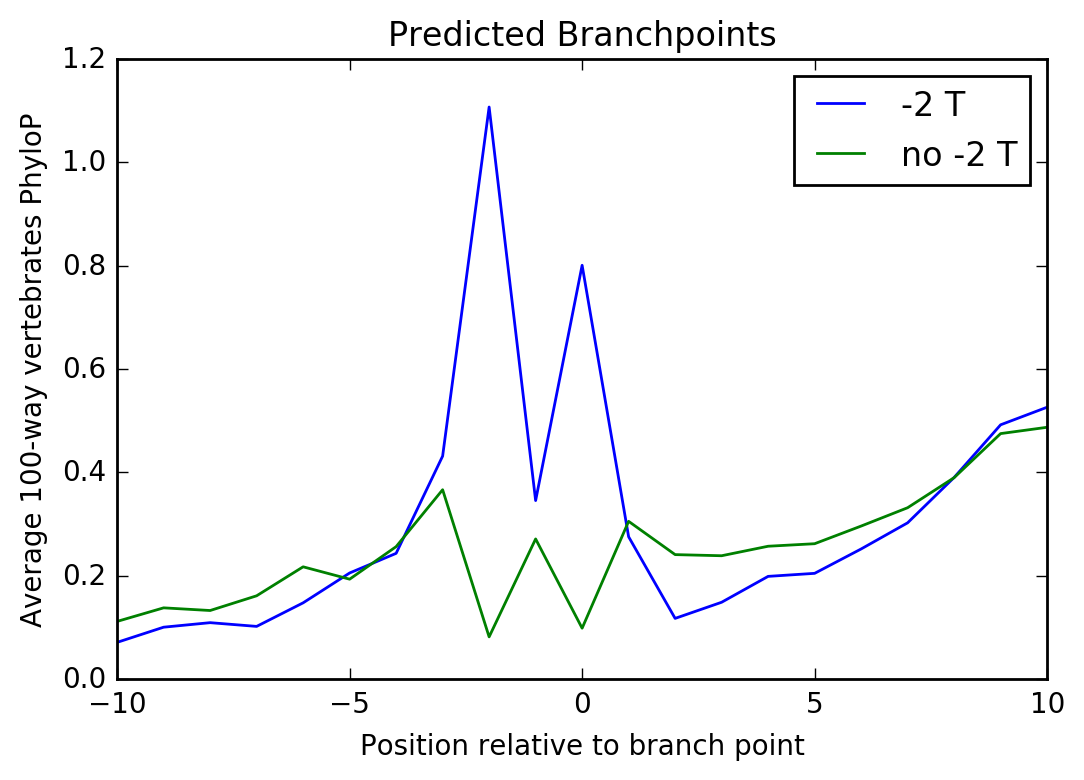

167172
38850


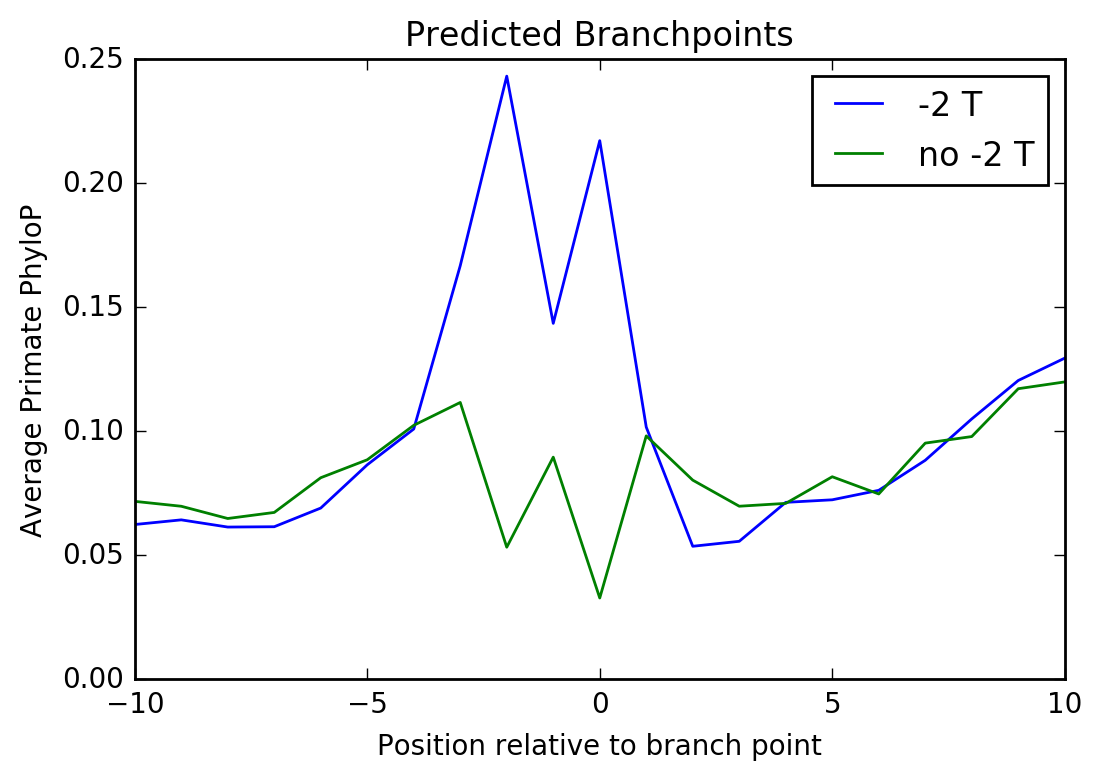

In [44]:
# No -2 T

def cons_novel_T(X, y, idx, T):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if T==seq[bp-2, 3]: continue
        counts += seq[bp-K: bp+K+1, idx]
        total += 1
    print total
    return counts / total

for t, name in enumerate(['-2 T','no -2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 4, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates Phastcons')
plt.title('Predicted Branchpoints')
plt.legend(loc = 'best')
plt.show()

for t, name in enumerate(['-2 T','no -2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 5, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhyloP')
plt.title('Predicted Branchpoints')
plt.legend(loc = 'best')
plt.show()

for t, name in enumerate(['-2 T','no -2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 6, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average Primate PhyloP')
plt.title('Predicted Branchpoints')
plt.legend(loc = 'best')
plt.show()

# Scores

0.724096 0.56821
0.750678 0.595204


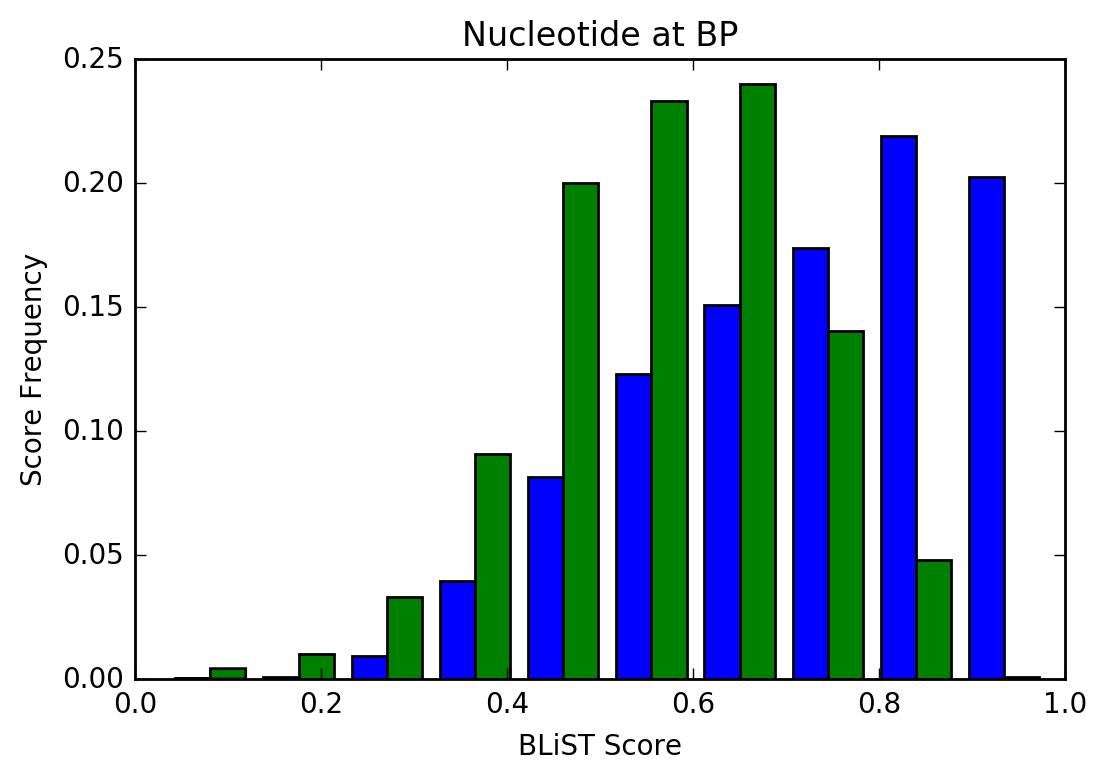

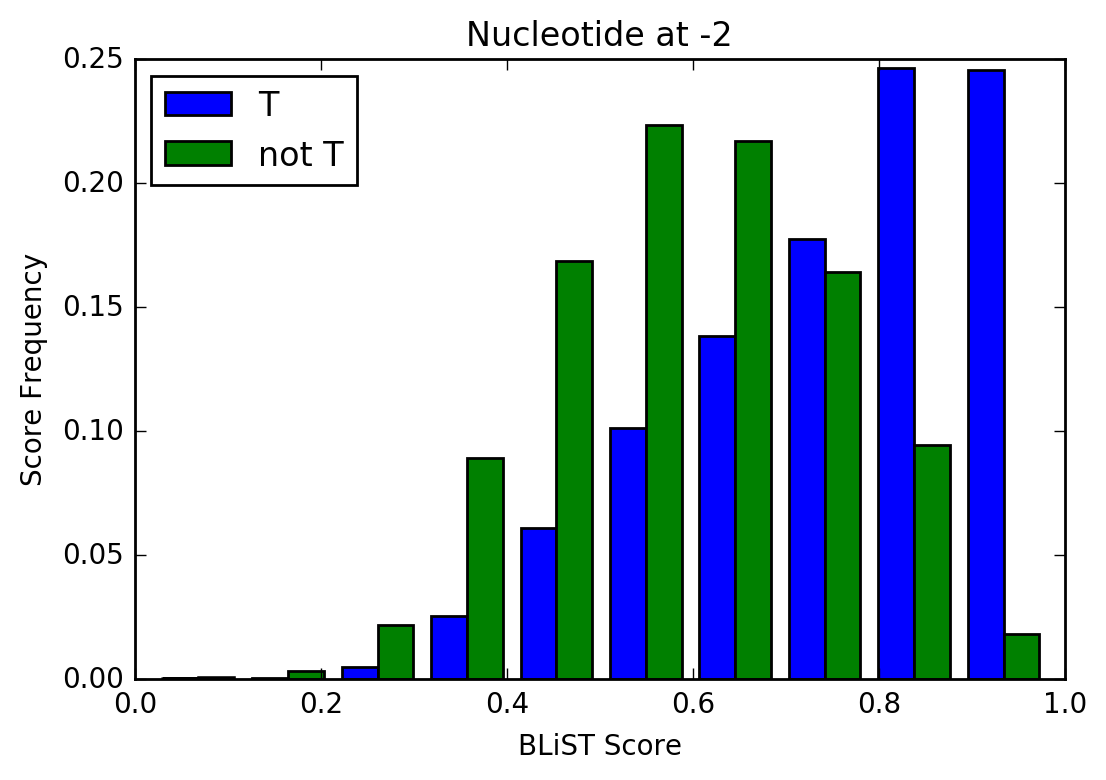

In [102]:
bp_a_scores = []
for bp, score, seq in zip(np.argmax(y_all, axis = 1), np.max(y_all, axis = 1), X_all):
    if seq[bp, 0]:
        bp_a_scores += [score]
bp_a_scores = np.array(bp_a_scores)

bp_c_scores = []
for bp, score, seq in zip(np.argmax(y_all, axis = 1), np.max(y_all, axis = 1), X_all):
    if seq[bp, 1]:
        bp_c_scores += [score]
bp_c_scores = np.array(bp_c_scores)

t2_scores = []
for bp, score, seq in zip(np.argmax(y_all, axis = 1), np.max(y_all, axis = 1), X_all):
    if seq[bp-2, 3]:
        t2_scores += [score]
t2_scores = np.array(t2_scores)
nt2_scores = []
for bp, score, seq in zip(np.argmax(y_all, axis = 1), np.max(y_all, axis = 1), X_all):
    if not seq[bp-2, 3]:
        nt2_scores += [score]
nt2_scores = np.array(nt2_scores)

print bp_a_scores.mean(), bp_c_scores.mean()
print t2_scores.mean(), nt2_scores.mean()

w1 = np.ones_like(bp_a_scores)/float(bp_a_scores.shape[0])
w2 = np.ones_like(bp_c_scores)/float(bp_c_scores.shape[0])
plt.hist([bp_a_scores, bp_c_scores], weights = [w1, w2], label= ['A', 'C'])
plt.title('Nucleotide at BP')
plt.ylabel('Score Frequency')
plt.xlabel('BLiST Score')
plt.show()

w1 = np.ones_like(t2_scores)/float(t2_scores.shape[0])
w2 = np.ones_like(nt2_scores)/float(nt2_scores.shape[0])
plt.hist([t2_scores, nt2_scores], weights = [w1, w2], label= ['T', 'not T'])
plt.legend(loc=2)
plt.title('Nucleotide at -2')
plt.ylabel('Score Frequency')
plt.xlabel('BLiST Score')
plt.show()

# PPT conservation

34207
22601


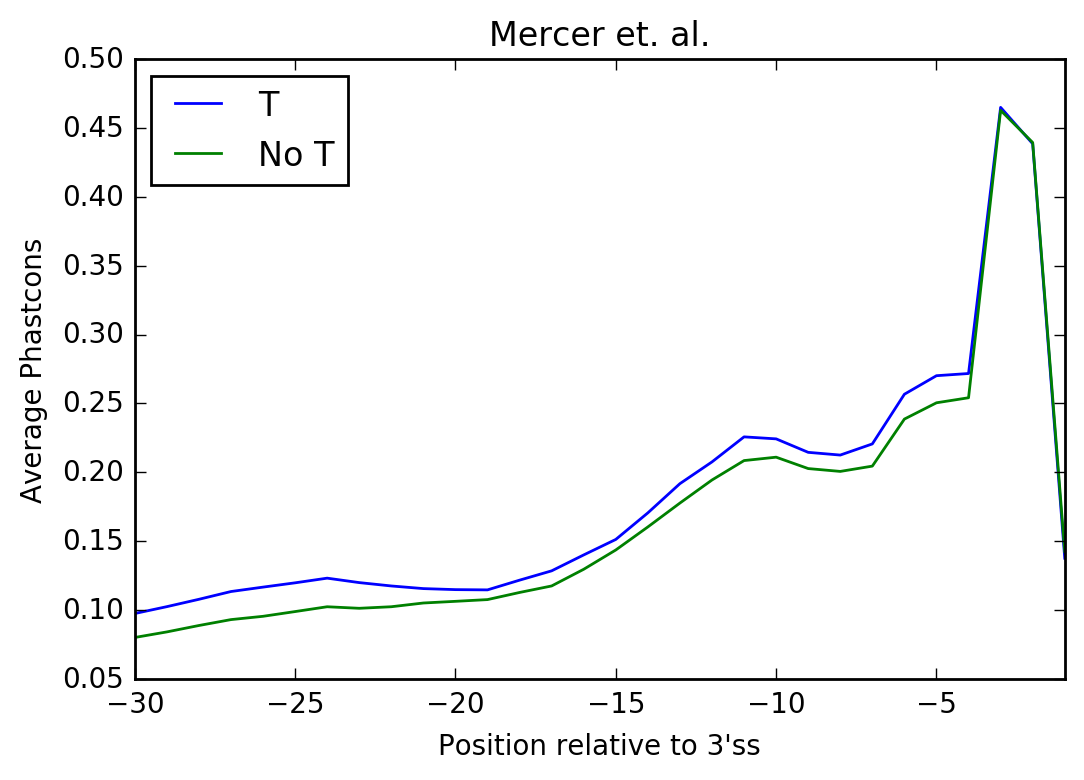

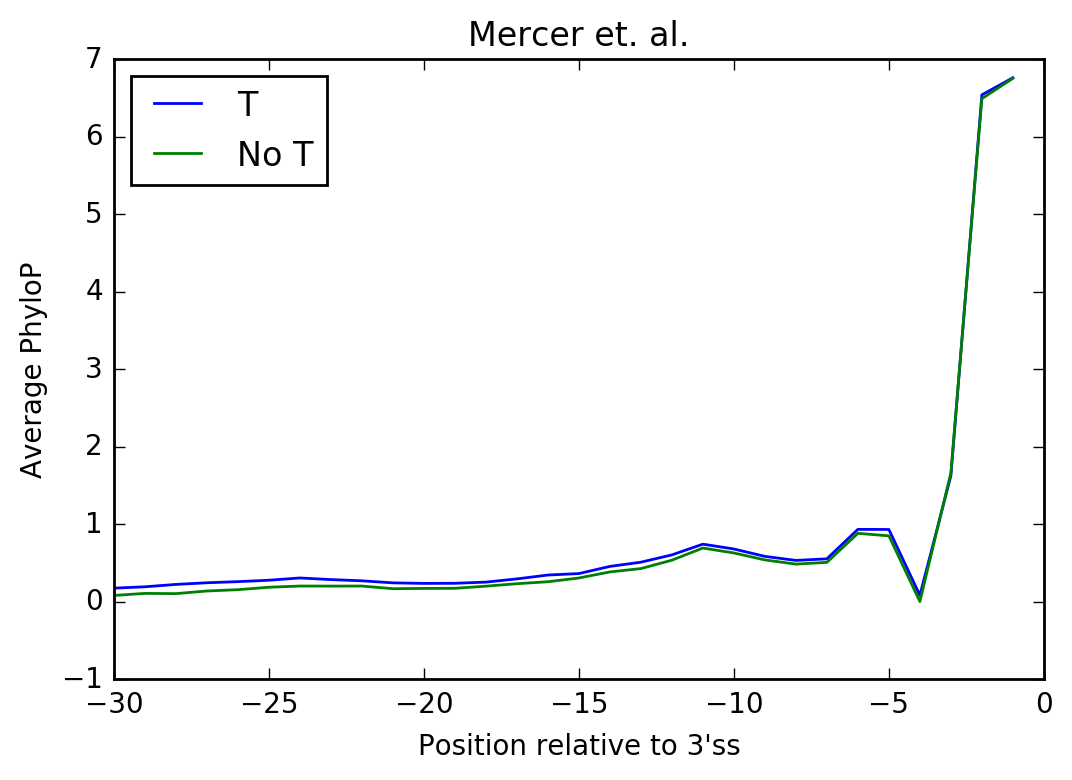

In [52]:
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp-2, 3]: continue
        counts += seq[-30:, 4]
        total += 1
print total
plt.plot(range(-30, 0), counts / total, label = 'T')

counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if seq[bp-2, 3]: continue
        counts += seq[-30:, 4]
        total += 1
print total
plt.plot(range(-30, 0), counts / total, label = 'No T')
plt.xlim(-30, -1)
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average Phastcons')
plt.title('Mercer et. al.')
plt.show()

counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp-2, 3]: continue
        if not np.all(seq[-30:, 5]): continue
        counts += seq[-30:, 5]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'T')
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if seq[bp-2, 3]: continue
        if not np.all(seq[-30:, 5]): continue
        counts += seq[-30:, 5]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'No T')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average PhyloP')
plt.title('Mercer et. al.')
plt.show()

167365
38927


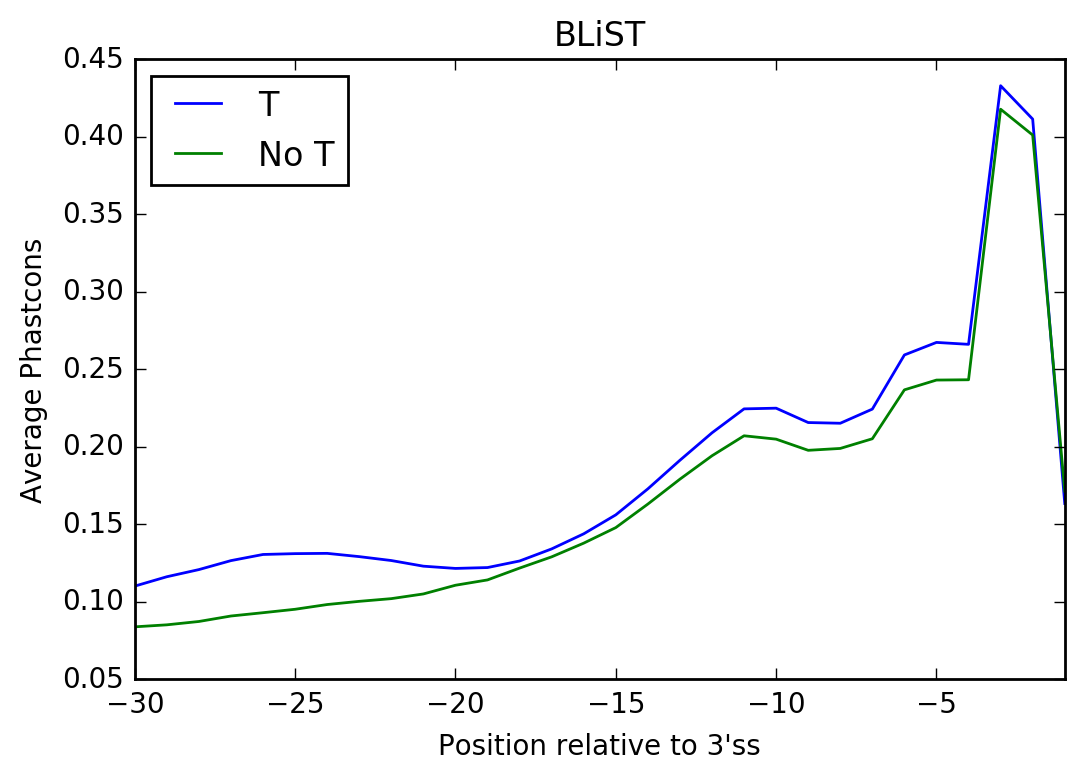

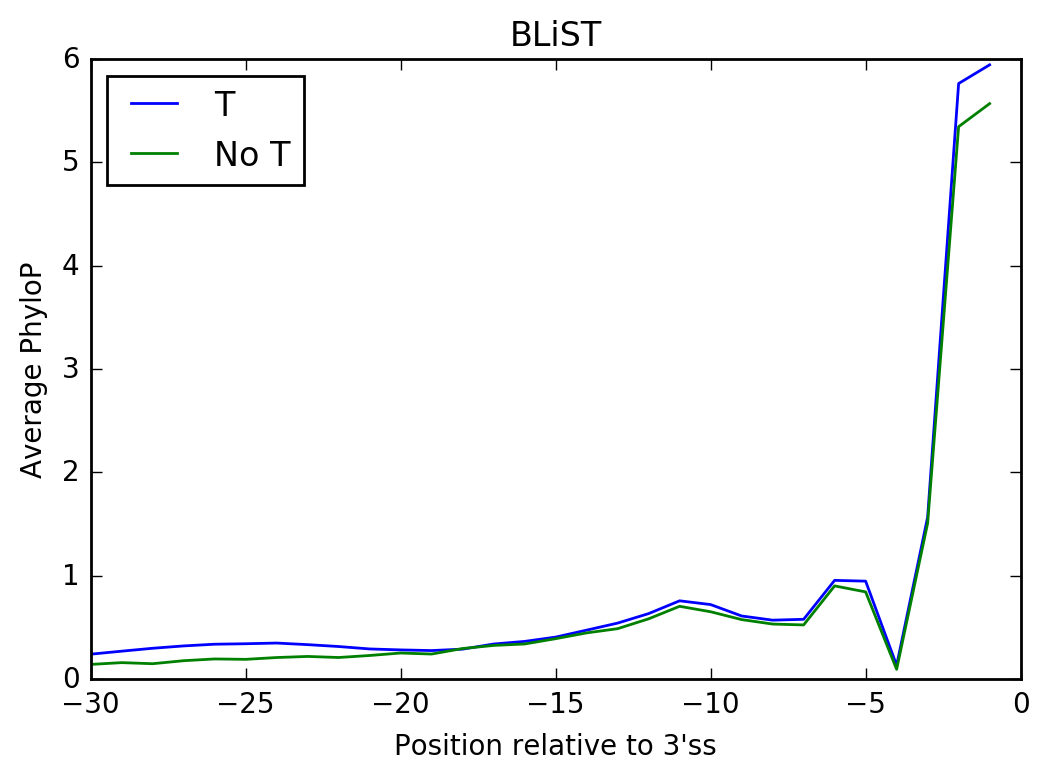

In [53]:
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp-2, 3]: continue
    counts += seq[-30:, 4]
    total += 1
print total
plt.plot(range(-30, 0), counts / total, label = 'T')
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if seq[bp-2, 3]: continue
    counts += seq[-30:, 4]
    total += 1
print total
plt.plot(range(-30, 0), counts / total, label = 'No T')
plt.xlim(-30, -1)
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average Phastcons')
plt.title('BLiST')
plt.show()

counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp-2, 3]: continue
    if not np.all(seq[-30:, 5]): continue
    counts += seq[-30:, 5]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'T')
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if seq[bp-2, 3]: continue
    if not np.all(seq[-30:, 5]): continue
    counts += seq[-30:, 5]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'No T')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average PhyloP')
plt.title('BLiST')
plt.show()

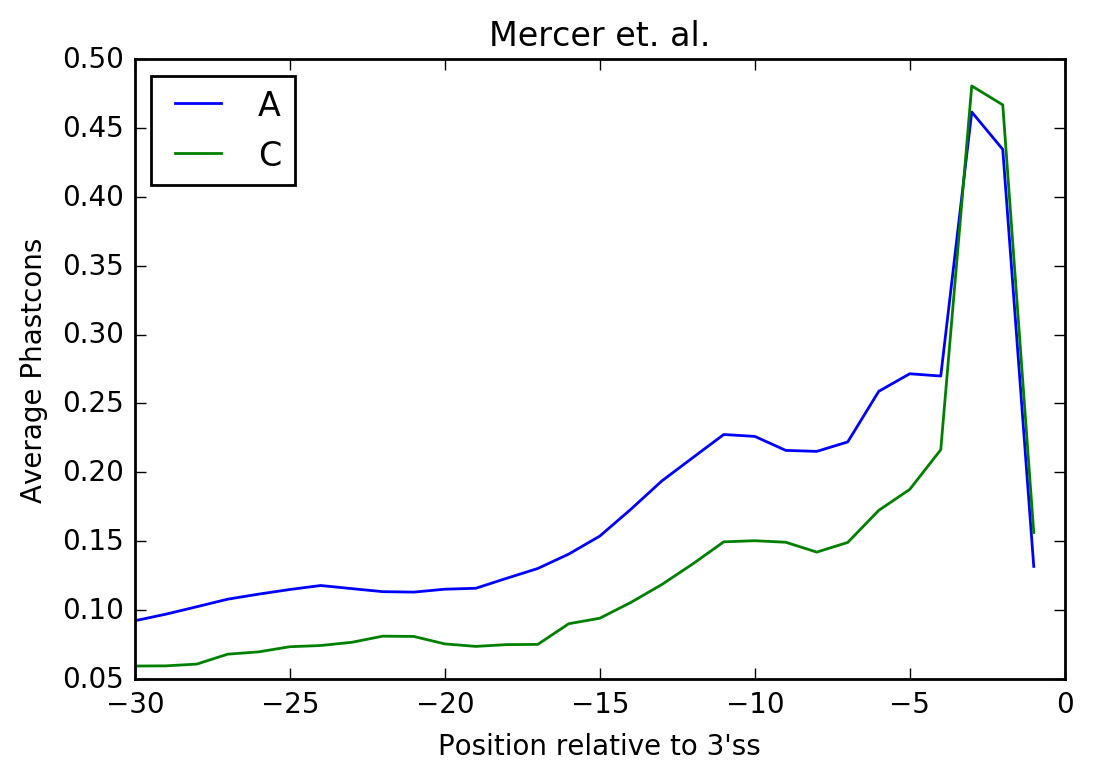

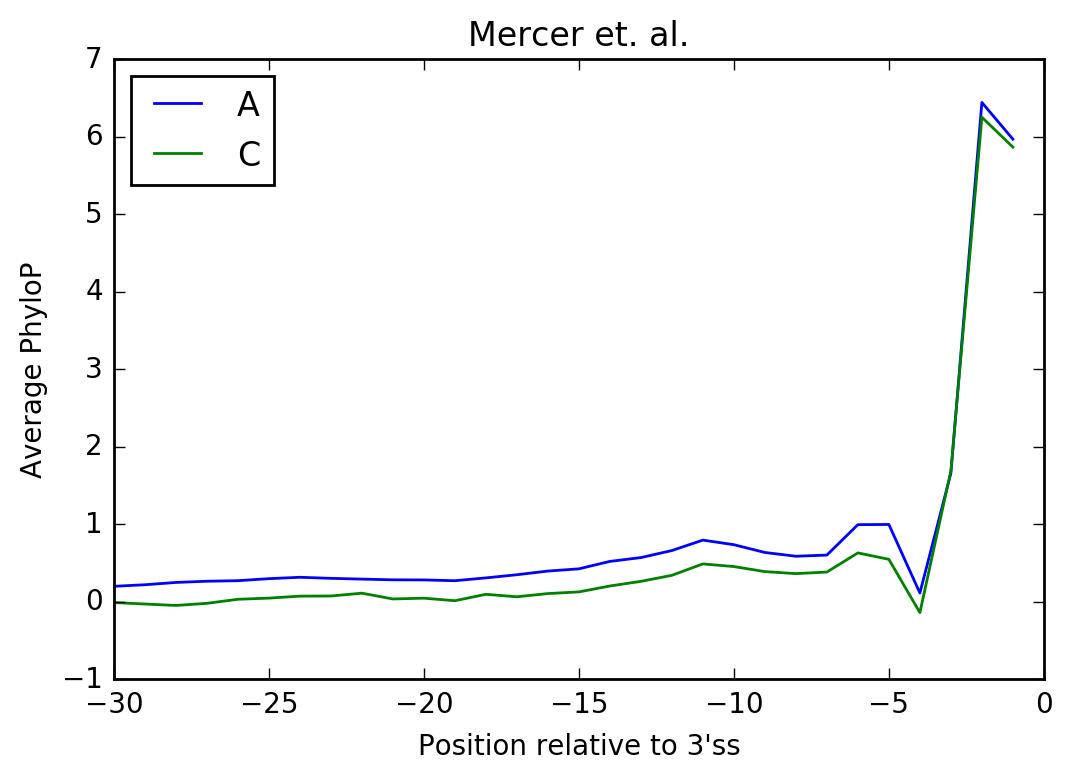

In [55]:
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 0]: continue
        counts += seq[-30:, 4]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'A')
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 1]: continue
        counts += seq[-30:, 4]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'C')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average Phastcons')
plt.title('Mercer et. al.')
plt.show()

counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 0]: continue
        counts += seq[-30:, 5]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'A')
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 1]: continue
        counts += seq[-30:, 5]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'C')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average PhyloP')
plt.title('Mercer et. al.')
plt.show()

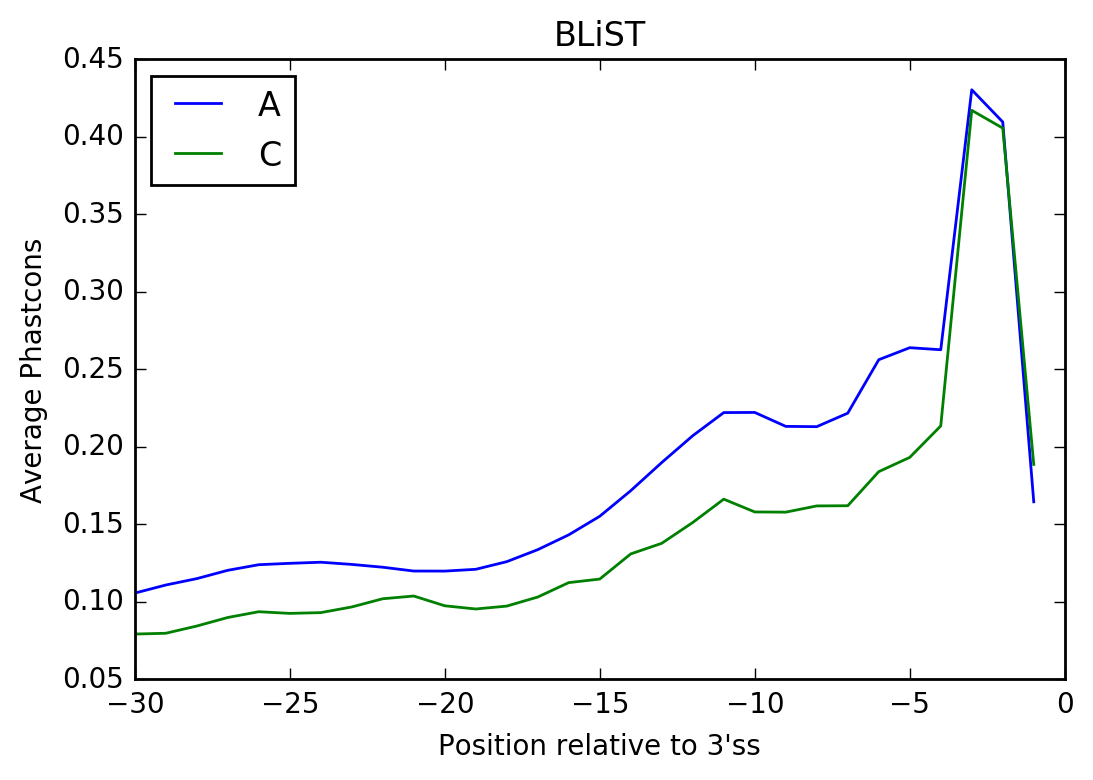

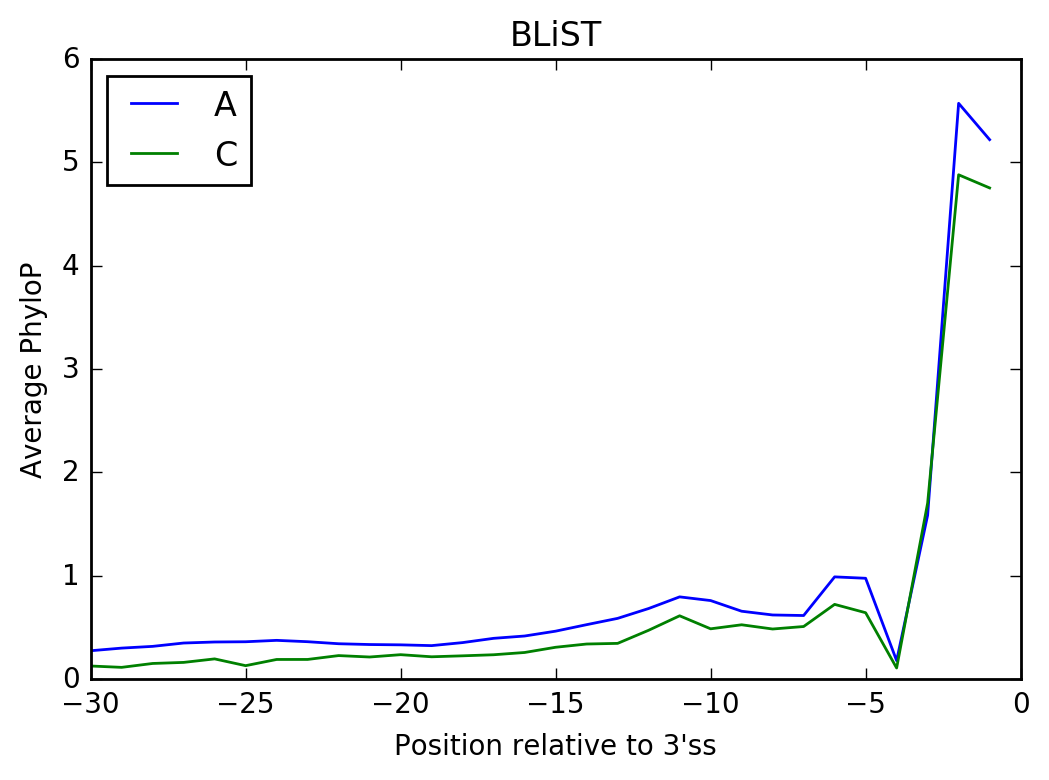

In [54]:
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp, 0]: continue
    counts += seq[-30:, 4]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'A')
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp, 1]: continue
    counts += seq[-30:, 4]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'C')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average Phastcons')
plt.title('BLiST')
plt.show()

counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp, 0]: continue
    counts += seq[-30:, 5]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'A')
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp, 1]: continue
    counts += seq[-30:, 5]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'C')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average PhyloP')
plt.title('BLiST')
plt.show()

# 3' ss Strength

0


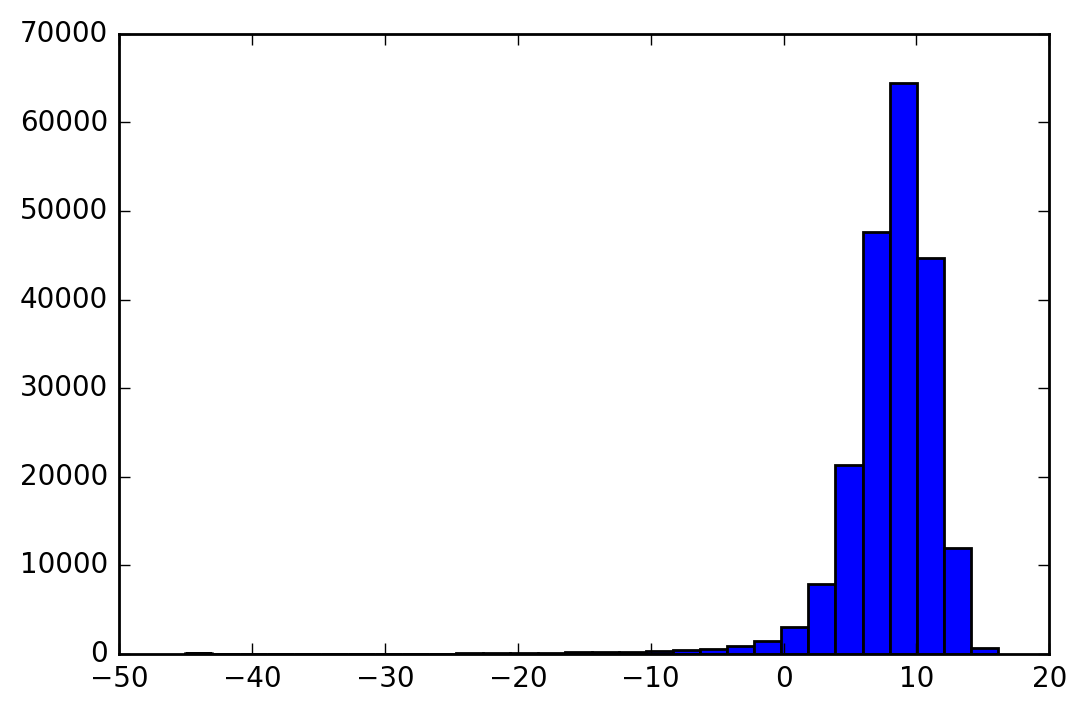

0


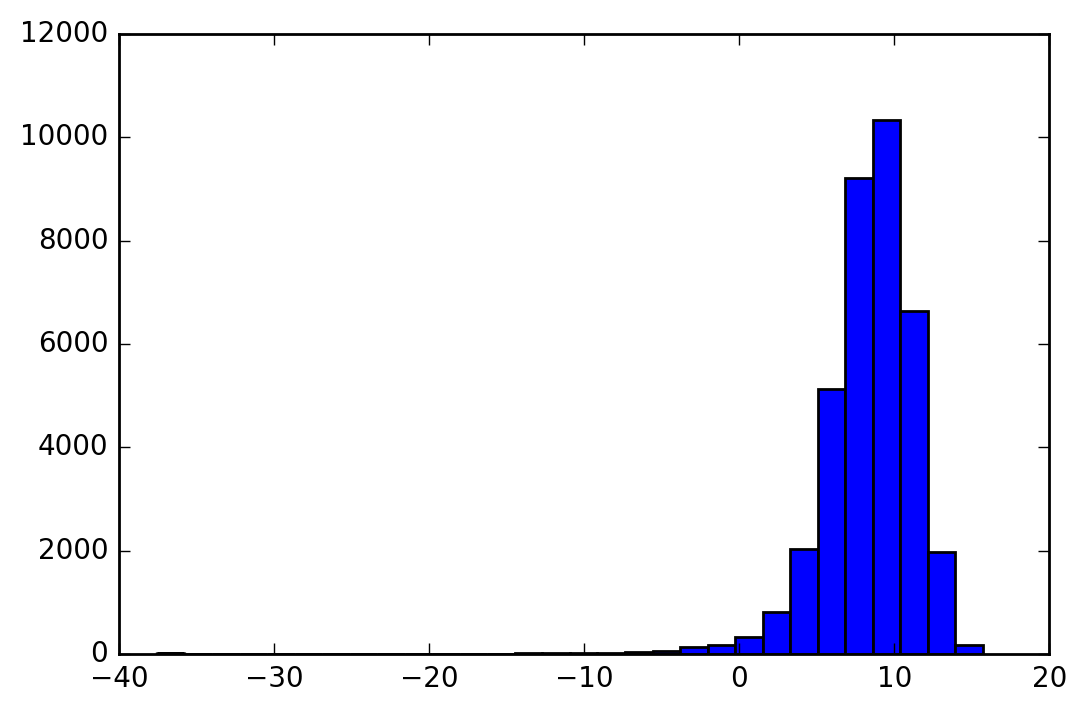

In [64]:
from MaxEntScan.maxentscan import maxentscan

def get_maxentscan(chroms, coords, strands):
    seqs = []
    haveN = 0
    for chrom, three, strand in zip(chroms, coords, strands):
        if strand == '+':
            begin, end = three-20, three+3
        else:
            begin, end = three-3, three+20
        seq = genome.get_seq(chrom, begin, end, strand)
        if 'N' in seq:
            haveN += 1
            seq = seq.replace('N', 'A')
        seqs += [seq]
    print haveN
    return maxentscan(seqs, False)

a_tpss = get_maxentscan(a_chroms, a_coords, a_strands)
plt.hist(a_tpss, bins = 30)
plt.show()

k_tpss = get_maxentscan(k_chroms, k_coords, k_strands)
plt.hist(k_tpss, bins = 30)
plt.show()

In [92]:
print np.mean(k_tpss)
print np.mean(a_tpss)
ranksums(k_tpss, a_tpss)

10.5176081919
8.38305874427
8.0931817036


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


RanksumsResult(statistic=9.9912858569967149, pvalue=1.6640889360034472e-23)

In [74]:
from scipy.stats import ranksums
A = []
for seq, target, tpss in zip(X_known, y_known, k_tpss):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 0]: continue
        A += [tpss]
        break
C = []
for seq, target, tpss in zip(X_known, y_known, k_tpss):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 1]: continue
        C += [tpss]
        break
print np.mean(A)
print np.mean(C)
print ranksums(A, C)

T = []
for seq, target, tpss in zip(X_known, y_known, k_tpss):
    for bp in np.nonzero(target)[0]:
        if not seq[bp-2, 3]: continue
        T += [tpss]
        break
noT = []
for seq, target, tpss in zip(X_known, y_known, k_tpss):
    for bp in np.nonzero(target)[0]:
        if seq[bp-2, 3]: continue
        noT += [tpss]
        break

print np.mean(T)
print np.mean(noT)
print ranksums(T, noT)

8.36258843881
9.03491223182
RanksumsResult(statistic=-15.841135545102876, pvalue=1.6187108383482658e-56)
8.33065509655
8.48947257511
RanksumsResult(statistic=-6.814954510815225, pvalue=9.4293597528464791e-12)


In [71]:
A = []
for seq, bp, tpss in zip(X_all, np.argmax(y_all, axis = 1), a_tpss):
    if not seq[bp, 0]: continue
    A += [tpss]
C = []
for seq, bp, tpss in zip(X_all, np.argmax(y_all, axis = 1), a_tpss):
    if not seq[bp, 1]: continue
    C += [tpss]
print np.mean(A)
print np.mean(C)
print ranksums(A, C)

T = []
for seq, bp, tpss in zip(X_all, np.argmax(y_all, axis = 1), a_tpss):
    if not seq[bp-2, 3]: continue
    T += [tpss]
noT = []
for seq, bp, tpss in zip(X_all, np.argmax(y_all, axis = 1), a_tpss):
    if seq[bp-2, 3]: continue
    noT += [tpss]

print np.mean(T)
print np.mean(noT)
print ranksums(T, noT)

8.08877133123
8.39643198091
RanksumsResult(statistic=-11.613671482206062, pvalue=3.5120482219162356e-31)
8.08755827085
8.11735941634
RanksumsResult(statistic=-14.350990965308906, pvalue=1.0502572513198669e-46)


SpearmanrResult(correlation=0.064319746803452121, pvalue=5.3944090748302356e-188)


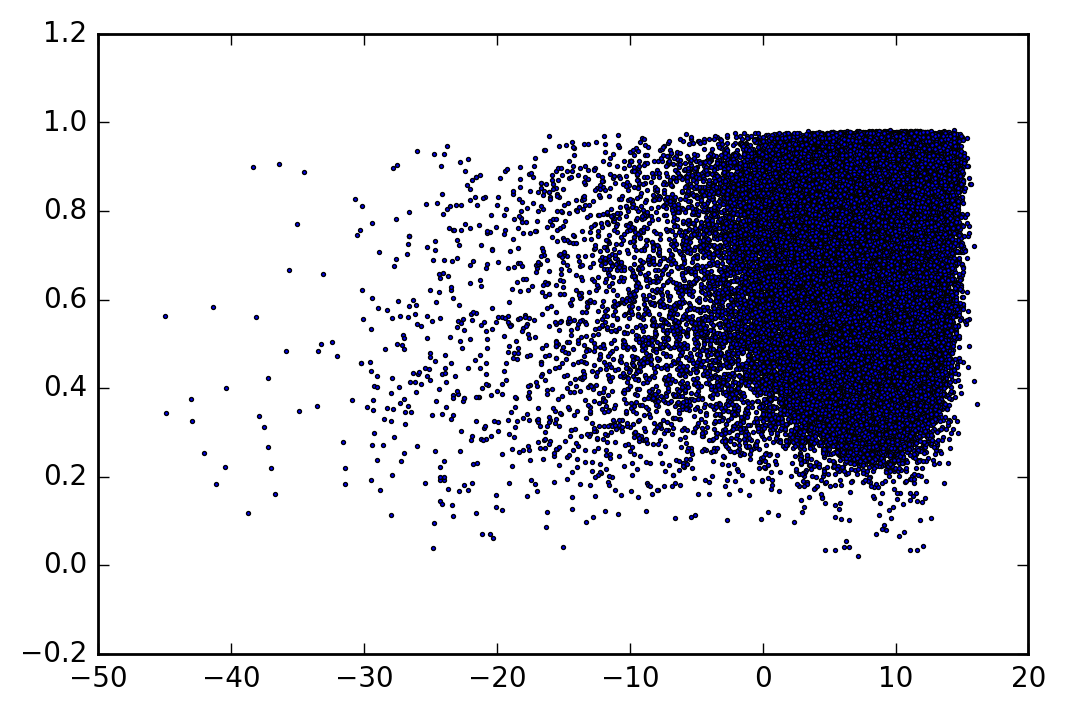

In [97]:
# Exact opposite of what I would have expected?
# Strange that -2T has opposite trend
# Perhaps this highlights that the score
# ... is not a measure of BP strength, but a probability
# ... that it is a branchpoint?

from scipy.stats import spearmanr
print spearmanr(a_tpss, np.max(y_all, axis=1))
plt.scatter(a_tpss, np.max(y_all, axis=1), s = 2, lw = 0.5)
plt.show()

SpearmanrResult(correlation=-0.01902313684896257, pvalue=5.5762096575966252e-18)


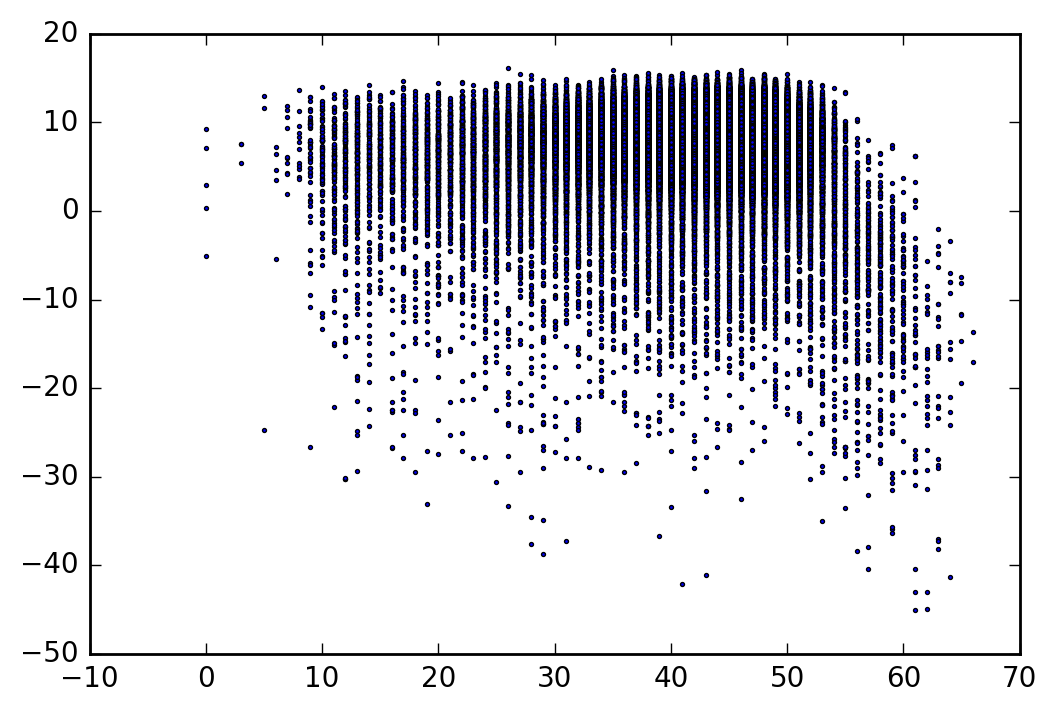

In [139]:
print spearmanr(np.argmax(y_all, axis=1), a_tpss)
plt.scatter(np.argmax(y_all, axis=1), a_tpss, s = 2, lw = 0.5)
plt.show()

# Skipped Exons

Don't look at known here because sets would likely be too small.

In [21]:
se = {}
total = 0
c = set(a_coords)
with open('/Users/jpaggi/Downloads/hg19/SE.hg19.gff3') as fp:
    print fp.readline().strip()
    n = 3
    for line in fp:
        chrom, _, gene, begin, end, _, strand = line.split('\t')[:7]
        if gene == 'gene': continue
        if n == 4:
            assert gene == 'exon'
            if chrom not in se: se[chrom] = set()
            three = int(begin)-1 if strand == '+' else int(end)
            total += three in c
            se[chrom].add(three)
            n = 0
        elif gene == 'exon':
            n += 1
print total

#GFF3 file (created by gffutils (v0.8) on 2013-09-27 21:07:42)
30178


In [51]:
from scipy.stats import chi2_contingency, fisher_exact
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 0]: continue
    skipped1 += coord in se[chrom]
    total1 += 1
print 'A Branchpoints'
print skipped1, total1
print skipped1 / float(total1)

total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 1]: continue
    skipped2 += coord in se[chrom]
    total2 += 1
print 'C Branchpoints'
print skipped2, total2
print skipped2 / float(total2)


print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1], [skipped2, total2]])
print fisher_exact([[skipped2, total2], [skipped1, total1]], 'greater')

A Branchpoints
24333 202813
0.119977516234
C Branchpoints
487 3352
0.145286396181
1.21094685689
(15.119564805641117, 0.00010091202679296872, 1, array([[  24407.48845163,  202738.51154837],
       [    412.51154837,    3426.48845163]]))
(1.2109468568912622, 7.1928045404696367e-05)


In [50]:
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp-2, 3]: continue
    skipped1 += coord in se[chrom]
    total1 += 1
print 'T branchpoints Branchpoints'
print skipped1, total1
print skipped1 / float(total1)
total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if seq[bp-2, 3]: continue
    skipped2 += coord in se[chrom]
    total2 += 1

print 'no T branchpoints Branchpoints'
print skipped2, total2
print skipped2 / float(total2)

print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1], [skipped2, total2]])
print fisher_exact([[skipped2, total2], [skipped1, total1]], 'greater')

T branchpoints Branchpoints
19733 167365
0.117903982314
no T branchpoints Branchpoints
5104 38927
0.131117219411
1.11206777615
(40.469515745295595, 1.9970769770456185e-10, 1, array([[  20105.45204626,  166992.54795374],
       [   4731.54795374,   39299.45204626]]))
(1.1120677761450581, 1.4049103078259409e-10)


# Retained introns

In [24]:
ri = {}
total = 0
c = set(a_coords)
with open('/Users/jpaggi/Downloads/hg19/RI.hg19.gff3') as fp:
    print fp.readline().strip()
    n = 0
    for line in fp:
        chrom, _, gene, begin, end, _, strand = line.split('\t')[:7]
        if gene == 'gene': continue
        if n and gene == 'exon':
            if n == 1 and strand == '+':
                n = 2
                continue
            if chrom not in ri: ri[chrom] = set()
            three = int(begin)-1 if strand == '+' else int(end)
            total += three in c
            ri[chrom].add(three)
            n = 0
        else:
            n = 1
print total

#GFF3 file (created by gffutils (v0.8) on 2013-09-27 21:15:33)
7789


In [48]:
from scipy.stats import chi2_contingency
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 0]: continue
    skipped1 += coord in ri[chrom]
    total1 += 1
print skipped1, total1
print skipped1 / float(total1)
total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 1]: continue
    skipped2 += coord in ri[chrom]
    total2 += 1
print skipped2, total2
print skipped2 / float(total2)

print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1], [skipped2, total2]])
print fisher_exact([[skipped2, total2], [skipped1, total1]], 'greater')

6265 202813
0.0308905247691
244 3352
0.0727923627685
2.35646248526
(169.77527914305742, 8.2841499188278596e-39, 1, array([[  6.39894252e+03,   2.02679057e+05],
       [  1.10057478e+02,   3.48594252e+03]]))
(0.42436491404138499, 5.0823413404516565e-30)
(2.3564624852621012, 5.0823413414432944e-30)


In [49]:
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp-2, 3]: continue
    skipped1 += coord in ri[chrom]
    total1 += 1
print skipped1, total1
print skipped1 / float(total1)
total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if seq[bp-2, 3]: continue
    skipped2 += coord in ri[chrom]
    total2 += 1
print skipped2, total2
print skipped2 / float(total2)

print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1], [skipped2, total2]])
print fisher_exact([[skipped2, total2], [skipped1, total1]], 'greater')

4935 167365
0.0294864517671
1584 38927
0.0406915508516
1.38000839073
(120.46698959232641, 4.9991762226013575e-28, 1, array([[   5278.0340302,  167021.9659698],
       [   1240.9659698,   39270.0340302]]))
(1.3800083907349607, 8.9658039474220117e-27)


# Intron Length

Again, don't look at known here.

T
6621.87489618
3012.36726229
no T
5153.03581062
2660.17456433


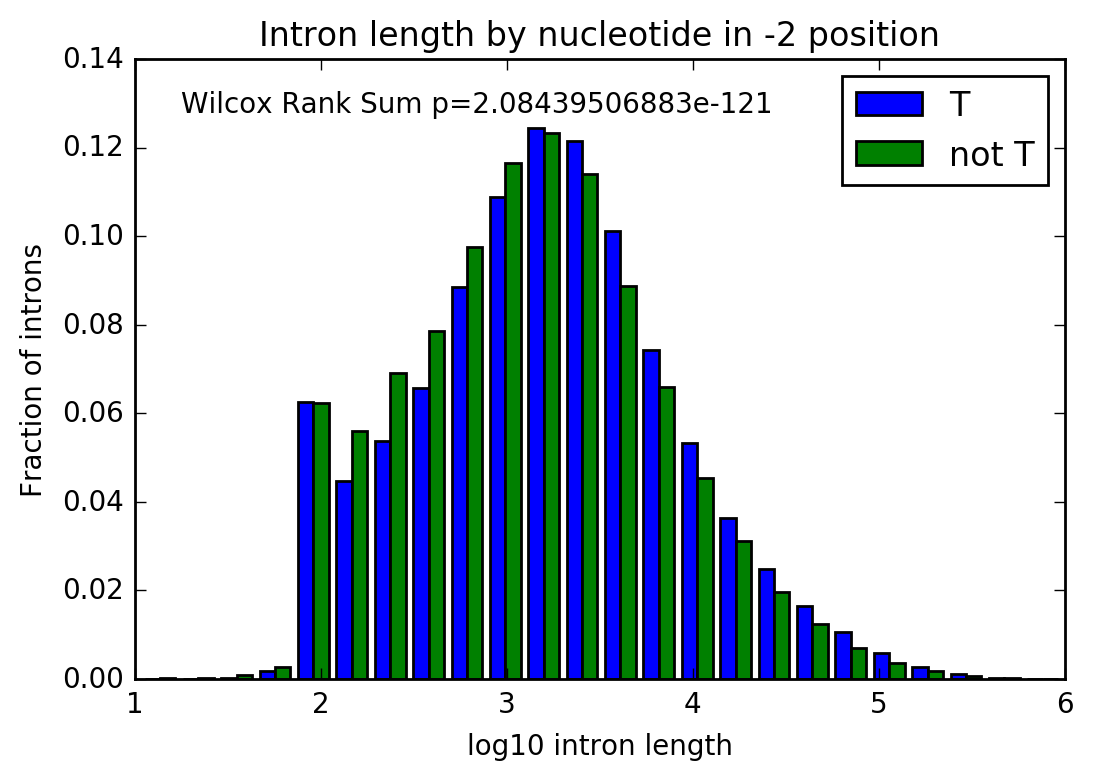

In [27]:
l1 = []
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp-2, 3]: continue
    l1 += [lengths[(chrom, coord)]]
l1 = np.array(l1)
l2 = []
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if seq[bp-2, 3]: continue
    l2 += [lengths[(chrom, coord)]]
l2 = np.array(l2)

print 'T'
print np.mean(l1)
print np.mean(l1[np.log(l1) < 10])
print 'no T'
print np.mean(l2)
print np.mean(l2[np.log(l2) < 10])

# Get and write pval
_, pval = ranksums(l1, l2)
f, ax = plt.subplots()
ax.text(0.05, 0.95, 'Wilcox Rank Sum p='+str(pval), transform=ax.transAxes, fontsize=10,
        verticalalignment='top')

# Make normalized histogram
w1 = np.ones_like(l1)/float(l1.shape[0])
w2 = np.ones_like(l2)/float(l2.shape[0])
plt.hist([np.log10(l1), np.log10(l2)], weights = [w1, w2], label= ['T', 'not T'], bins = 30)
plt.legend(loc = 'best')
plt.xlim(1, 6)
plt.title('Intron length by nucleotide in -2 position')
plt.ylabel('Fraction of introns')
plt.xlabel('log10 intron length')
plt.show()

A
6389.46358468
2962.80394959
C
3743.18317422
1925.05102982


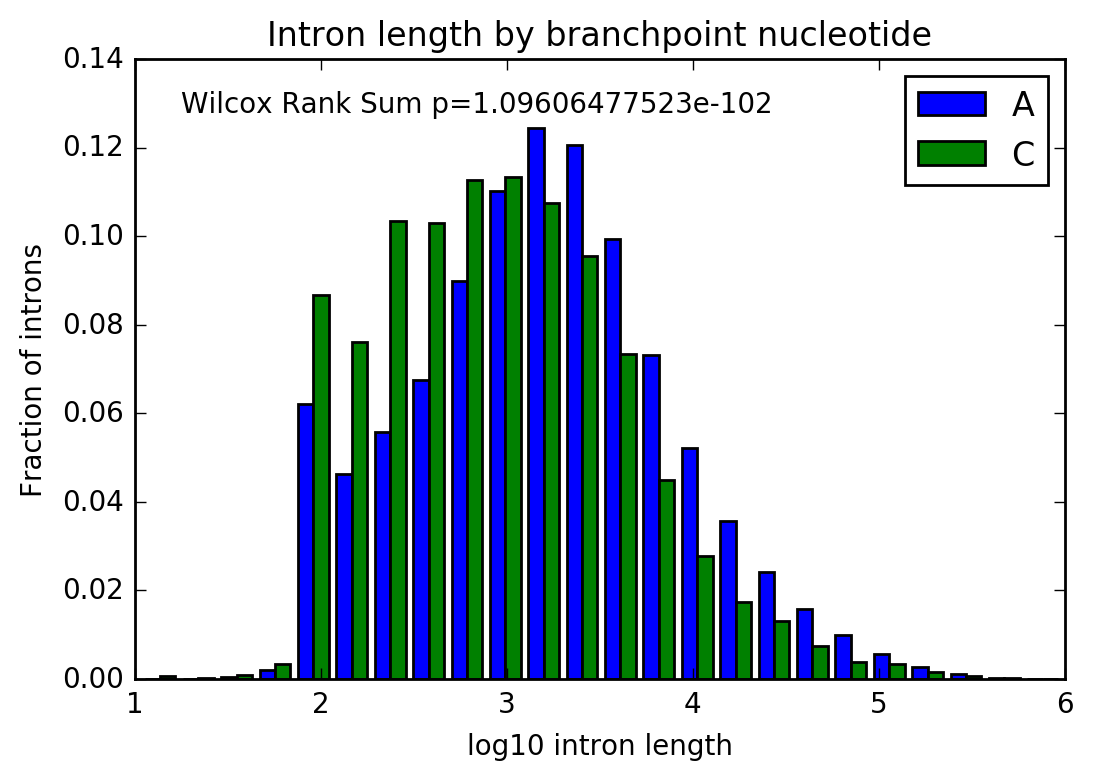

In [28]:
l1 = []
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 0]: continue
    l1 += [lengths[(chrom, coord)]]
l1 = np.array(l1)

l2 = []
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 1]: continue
    l2 += [lengths[(chrom, coord)]]
l2 = np.array(l2)

print 'A'
print np.mean(l1)
print np.mean(l1[np.log(l1) < 10])
print 'C'
print np.mean(l2)
print np.mean(l2[np.log(l2) < 10])

# Get and write pval
_, pval = ranksums(l1, l2)
f, ax = plt.subplots()
ax.text(0.05, 0.95, 'Wilcox Rank Sum p='+str(pval), transform=ax.transAxes, fontsize=10,
        verticalalignment='top')

# Make normalized histogram
w1 = np.ones_like(l1)/float(l1.shape[0])
w2 = np.ones_like(l2)/float(l2.shape[0])
plt.hist([np.log10(l1), np.log10(l2)], weights = [w1, w2], label= ['A', 'C'], bins = 30)
plt.legend(loc = 'best')
plt.xlim(1, 6)
plt.title('Intron length by branchpoint nucleotide')
plt.ylabel('Fraction of introns')
plt.xlabel('log10 intron length')
plt.show()

## Dists

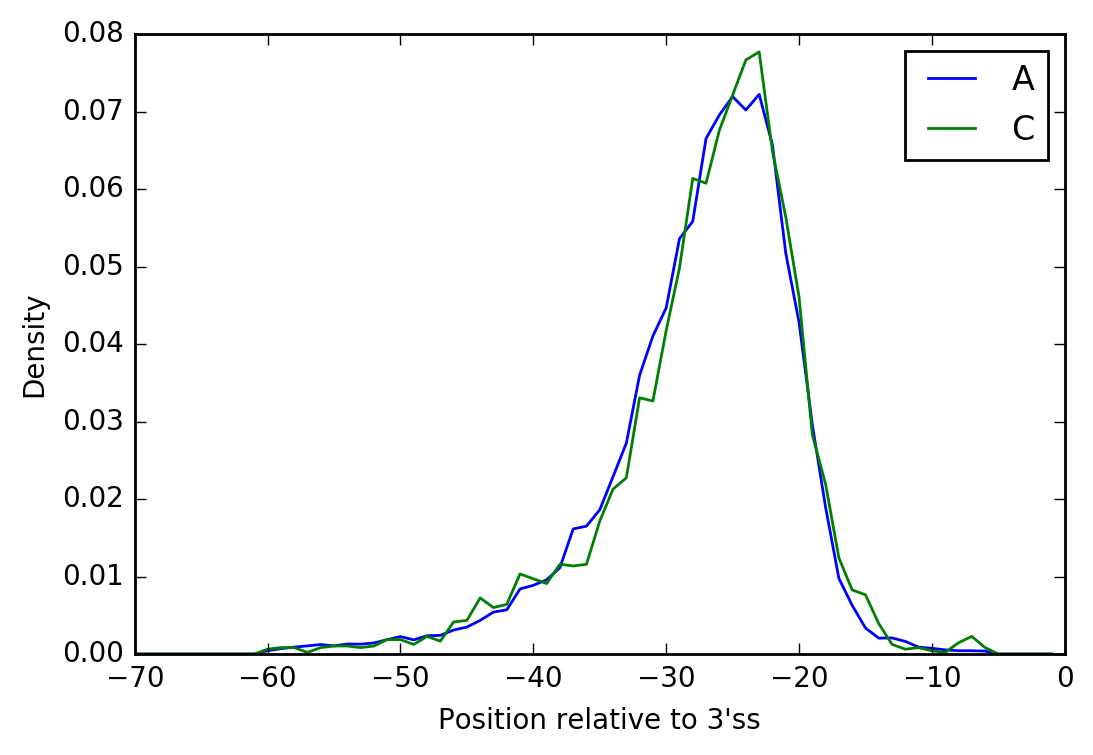

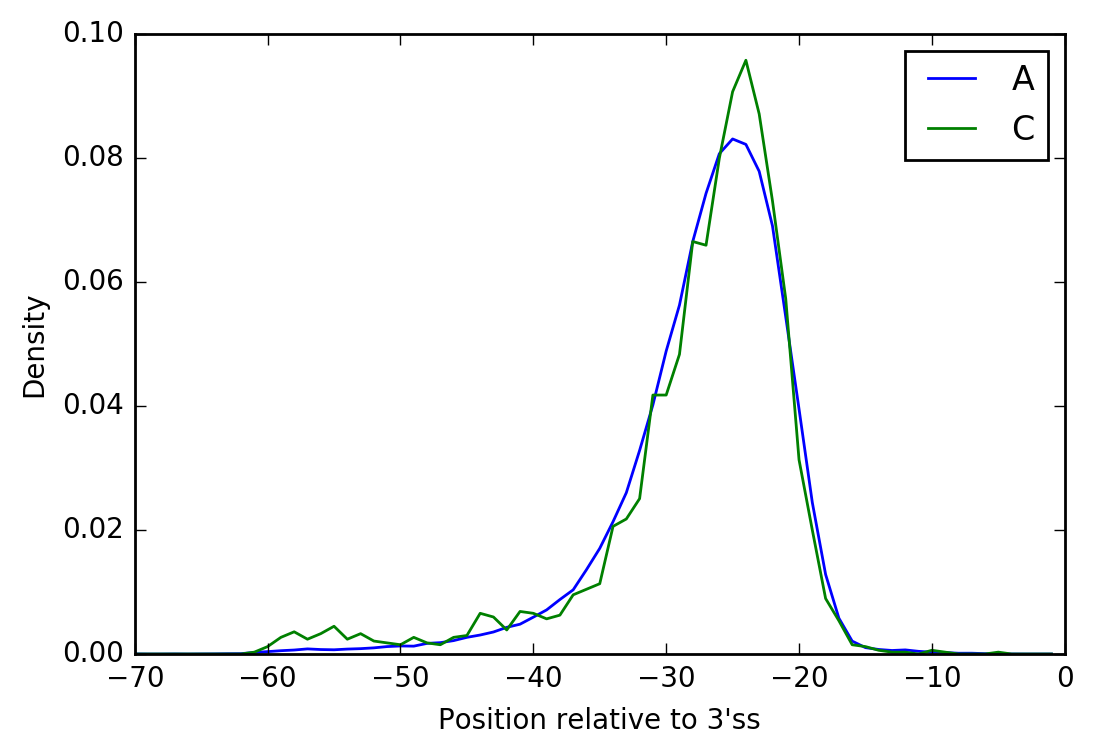

In [29]:
def dist_novel_bp(X, y, base):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if not seq[bp, base]: continue
        counts[bp] += 1
        total += 1
    return counts / total

def dist_known_bp(X, y, base):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if not seq[bp, base]: continue
            counts[bp] += 1
            total += 1
    return counts / total

for i, base in enumerate(bases[:2]):
    plt.plot(range(-L, 0), dist_known_bp(X_known, y_known, i), label = base)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

for i, base in enumerate(bases[:2]):
    plt.plot(range(-L, 0), dist_novel_bp(X_all, y_all, i), label = base)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

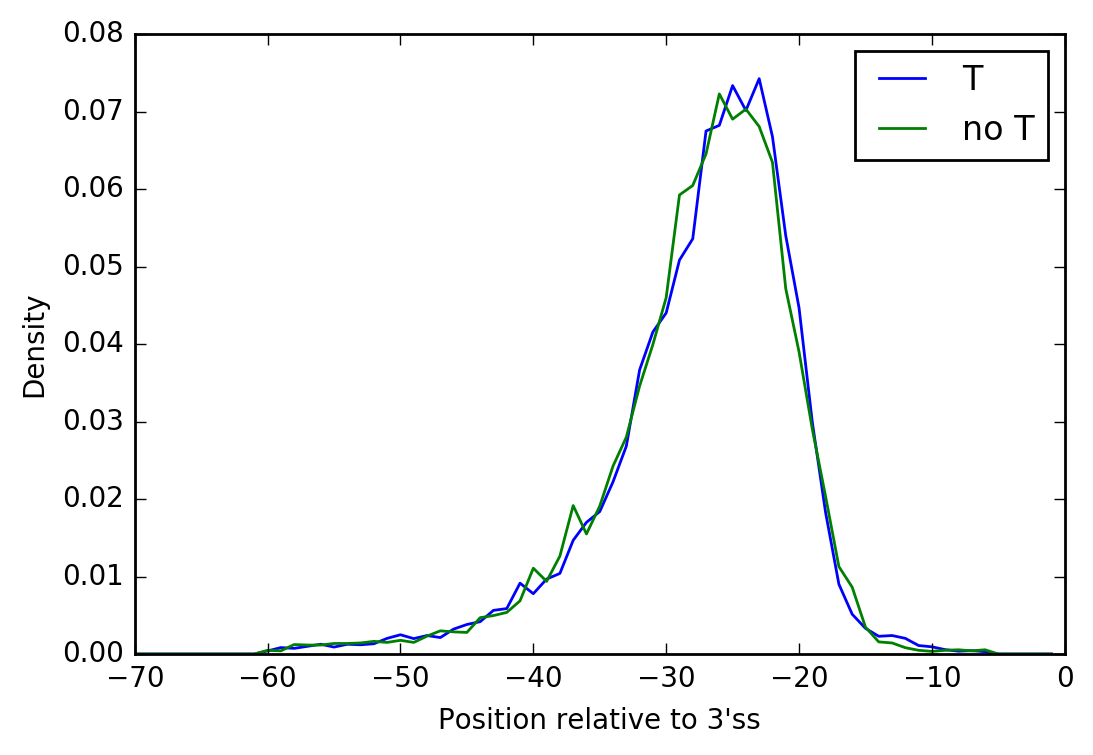

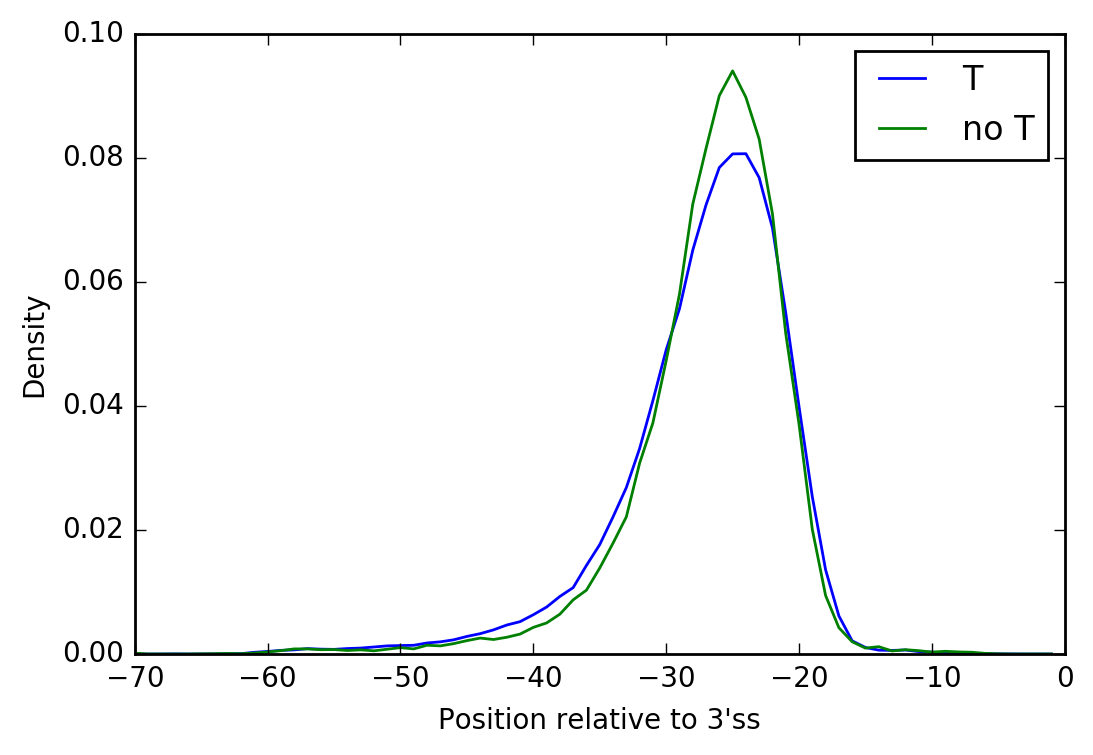

In [30]:
def dist_novel_2T(X, y, T):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if T != seq[bp-2, 3]: continue
        counts[bp] += 1
        total += 1
    return counts / total

def dist_known_2T(X, y, T):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if T != seq[bp-2, 3]: continue
            if not seq[bp, 0]: continue
            counts[bp] += 1
            total += 1
    return counts / total

for i, t in enumerate(['T', 'no T']):
    plt.plot(range(-L, 0), dist_known_2T(X_known, y_known, 1-i), label = t)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

for i, t in enumerate(['T', 'no T']):
    plt.plot(range(-L, 0), dist_novel_2T(X_all, y_all, 1-i), label = t)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

## PWM

In [31]:
def pwm_logo(pwm, title, x=None):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, x if x else range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.xlim(.75, len(x)+1 if x else 2*K+2)
    plt.show()

44922


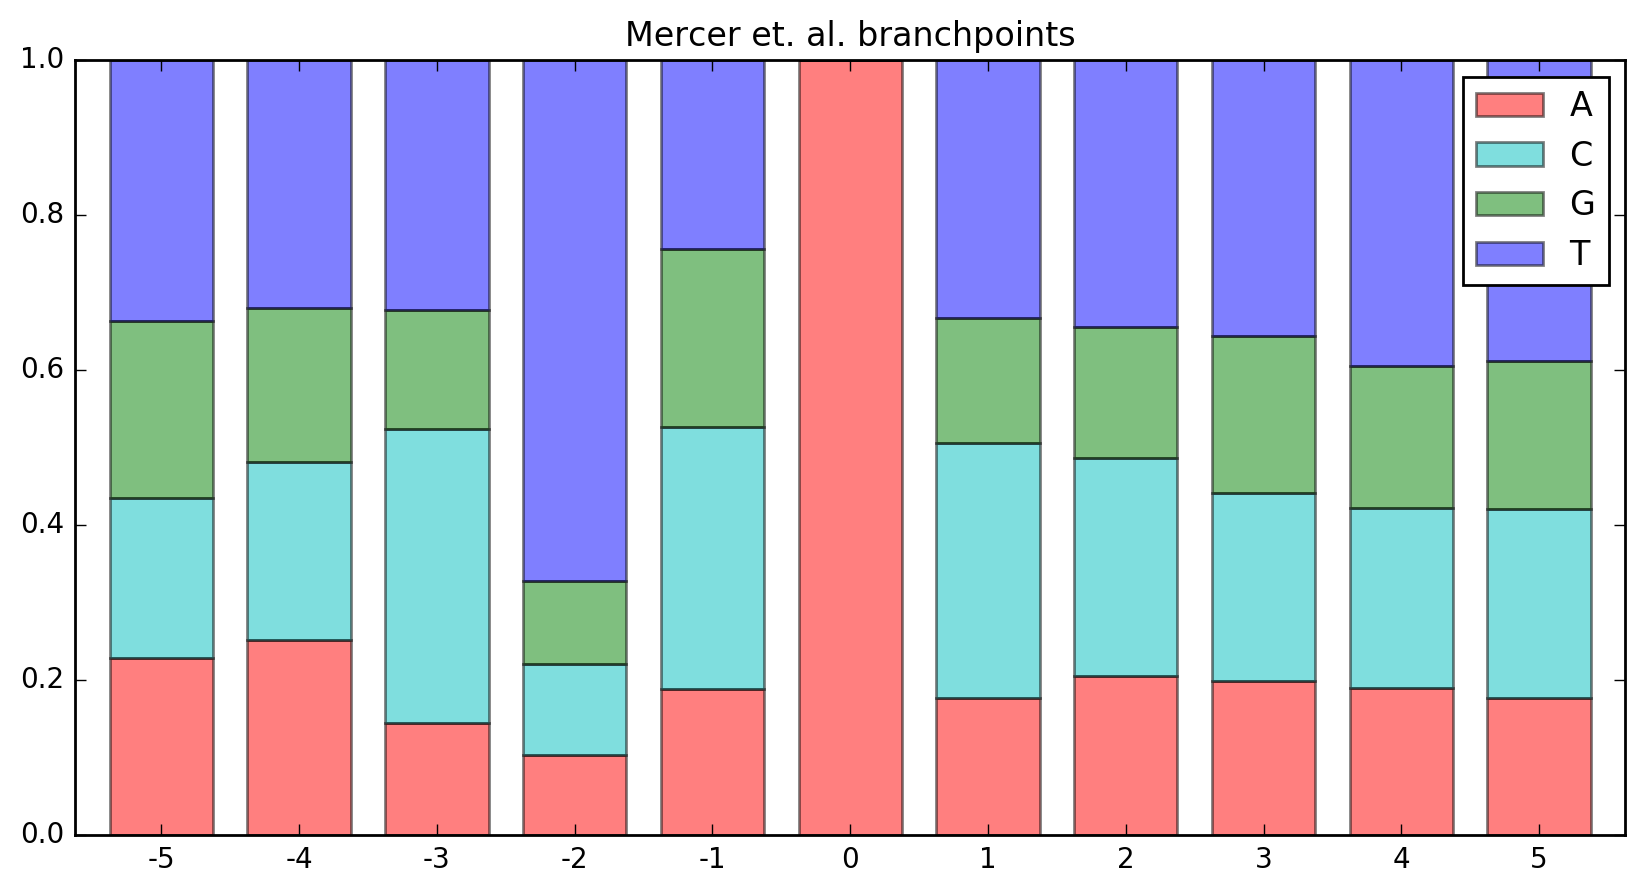

4840


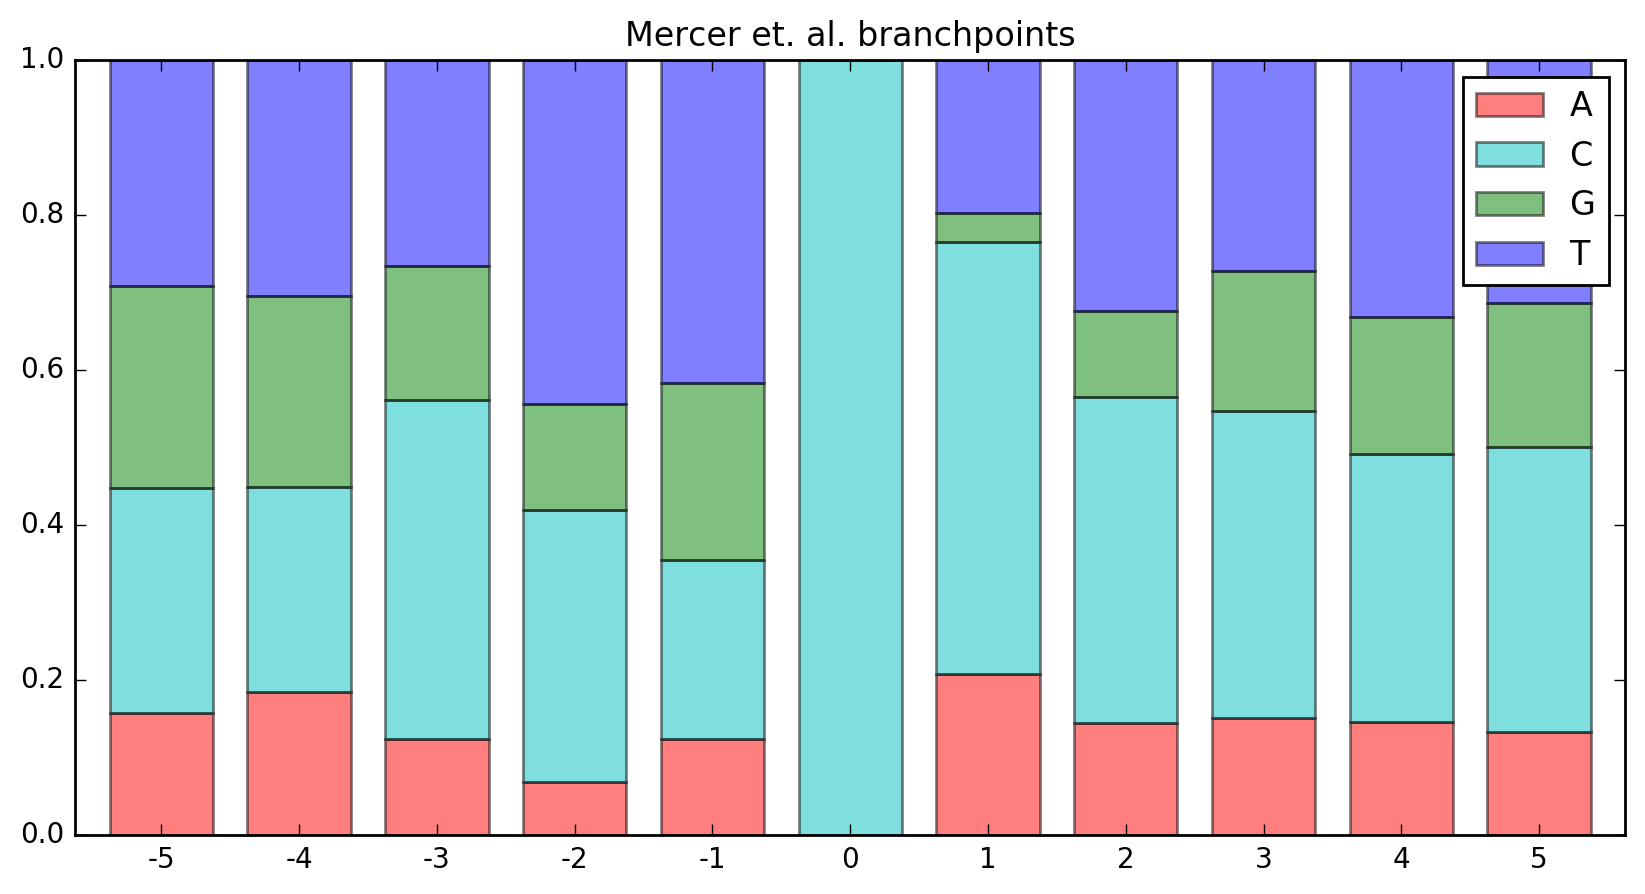

2439


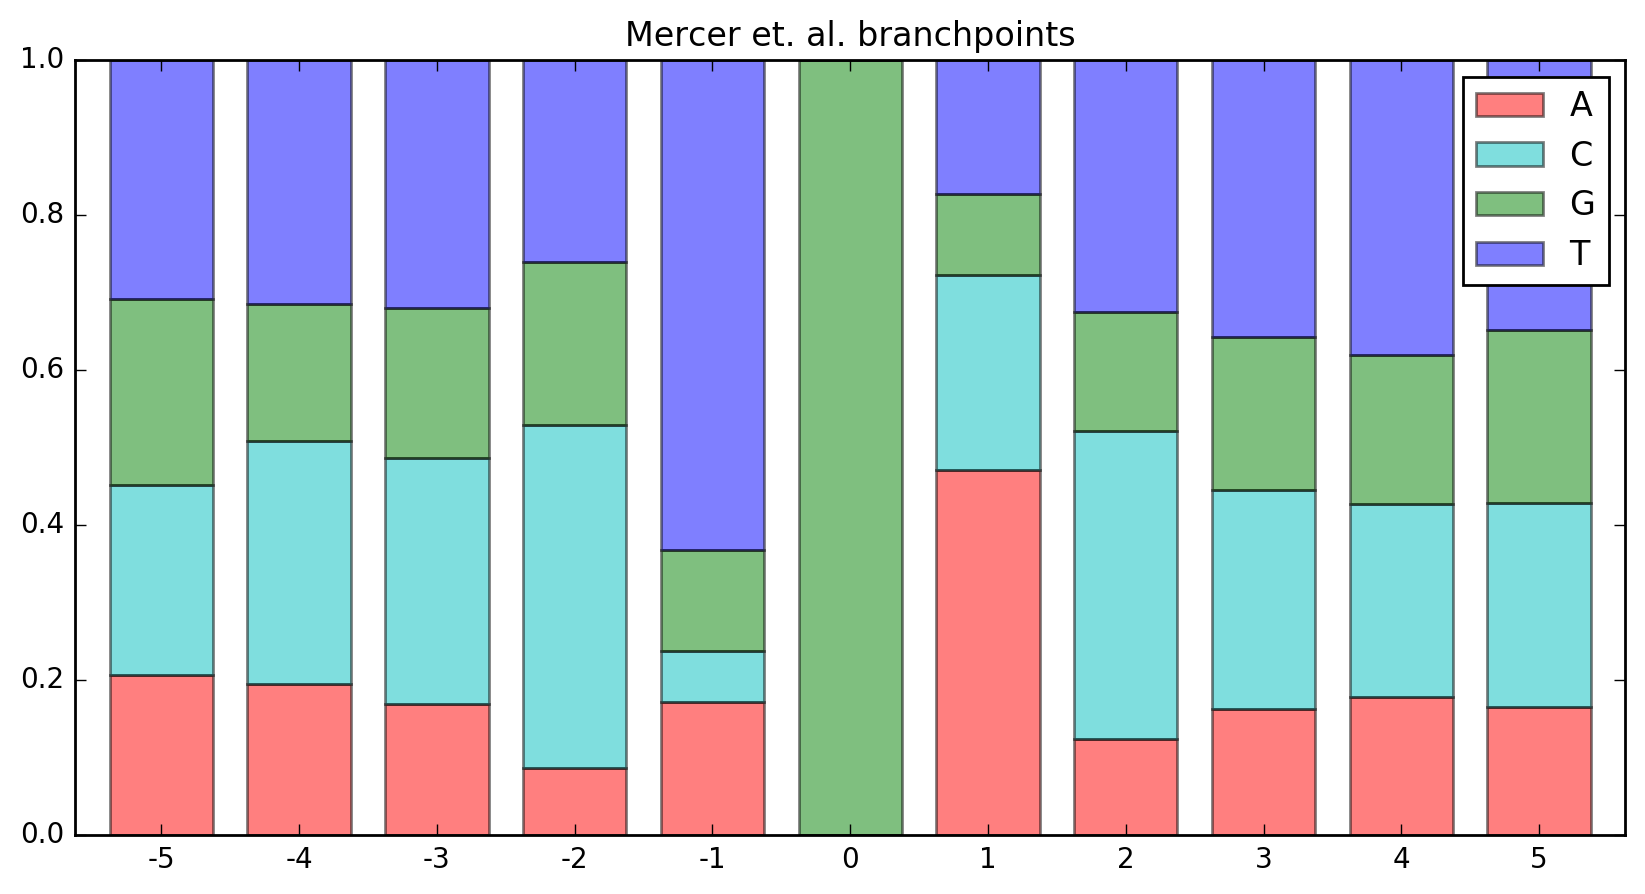

4607


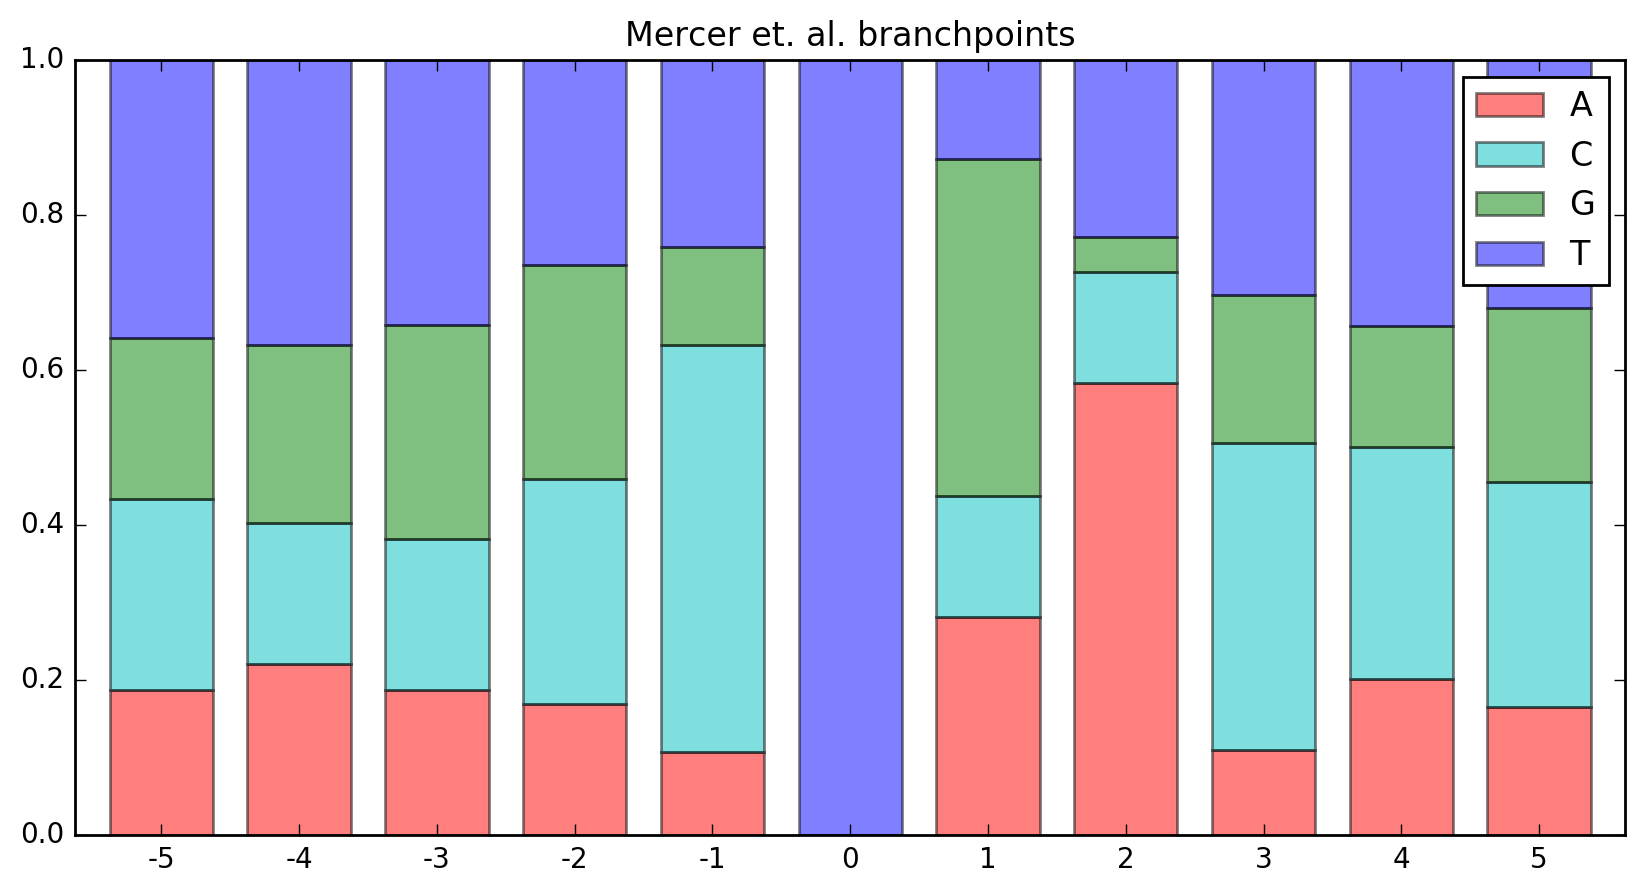

34207


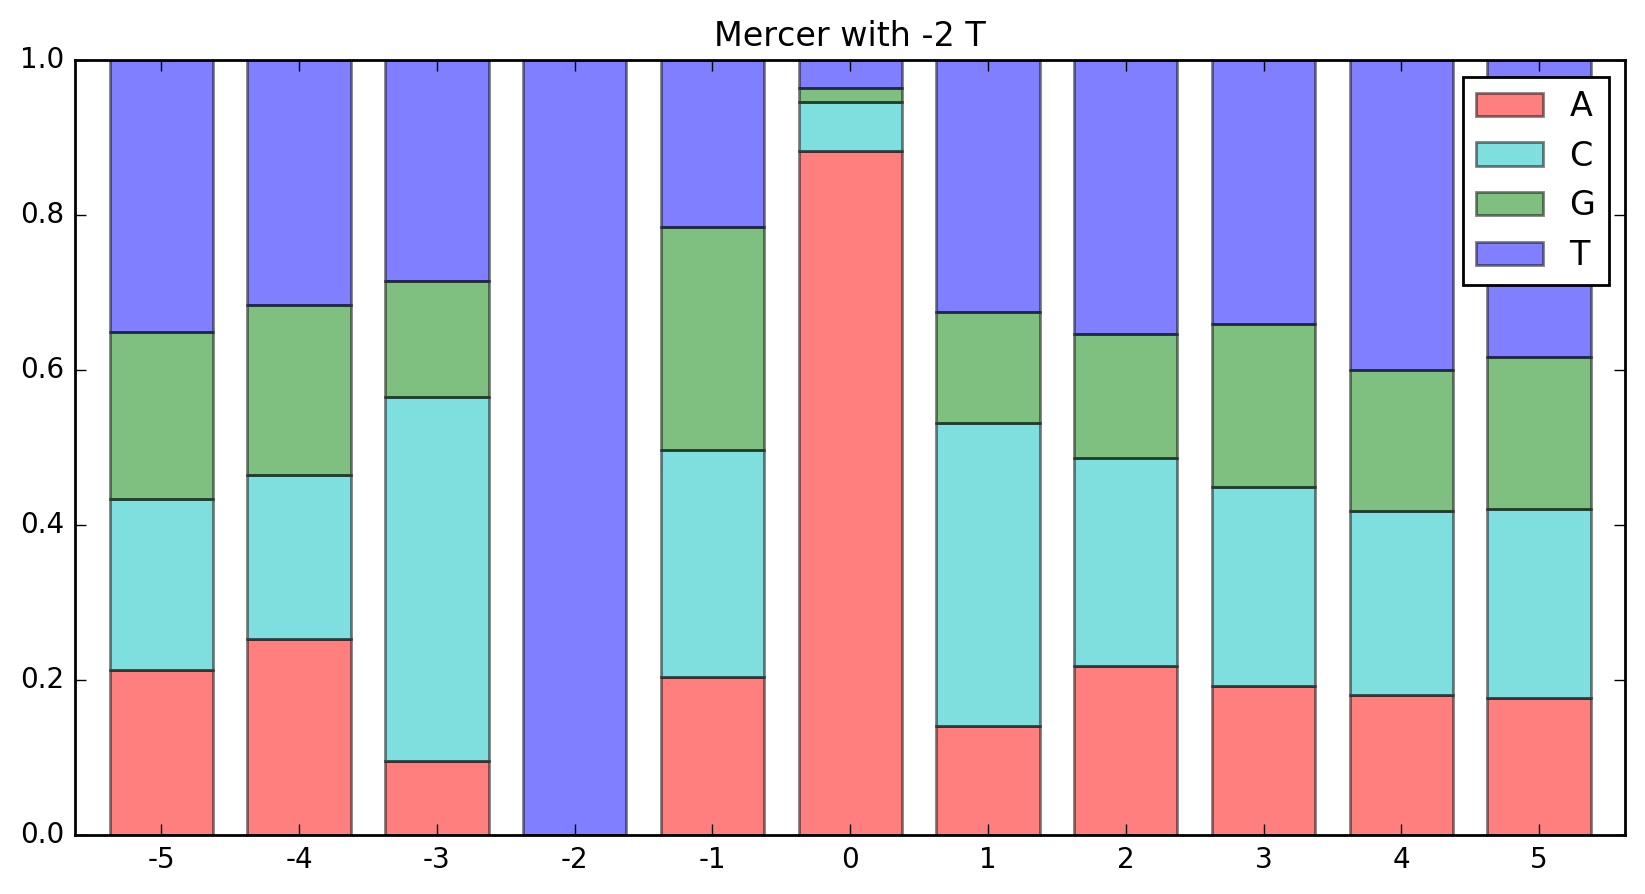

22601


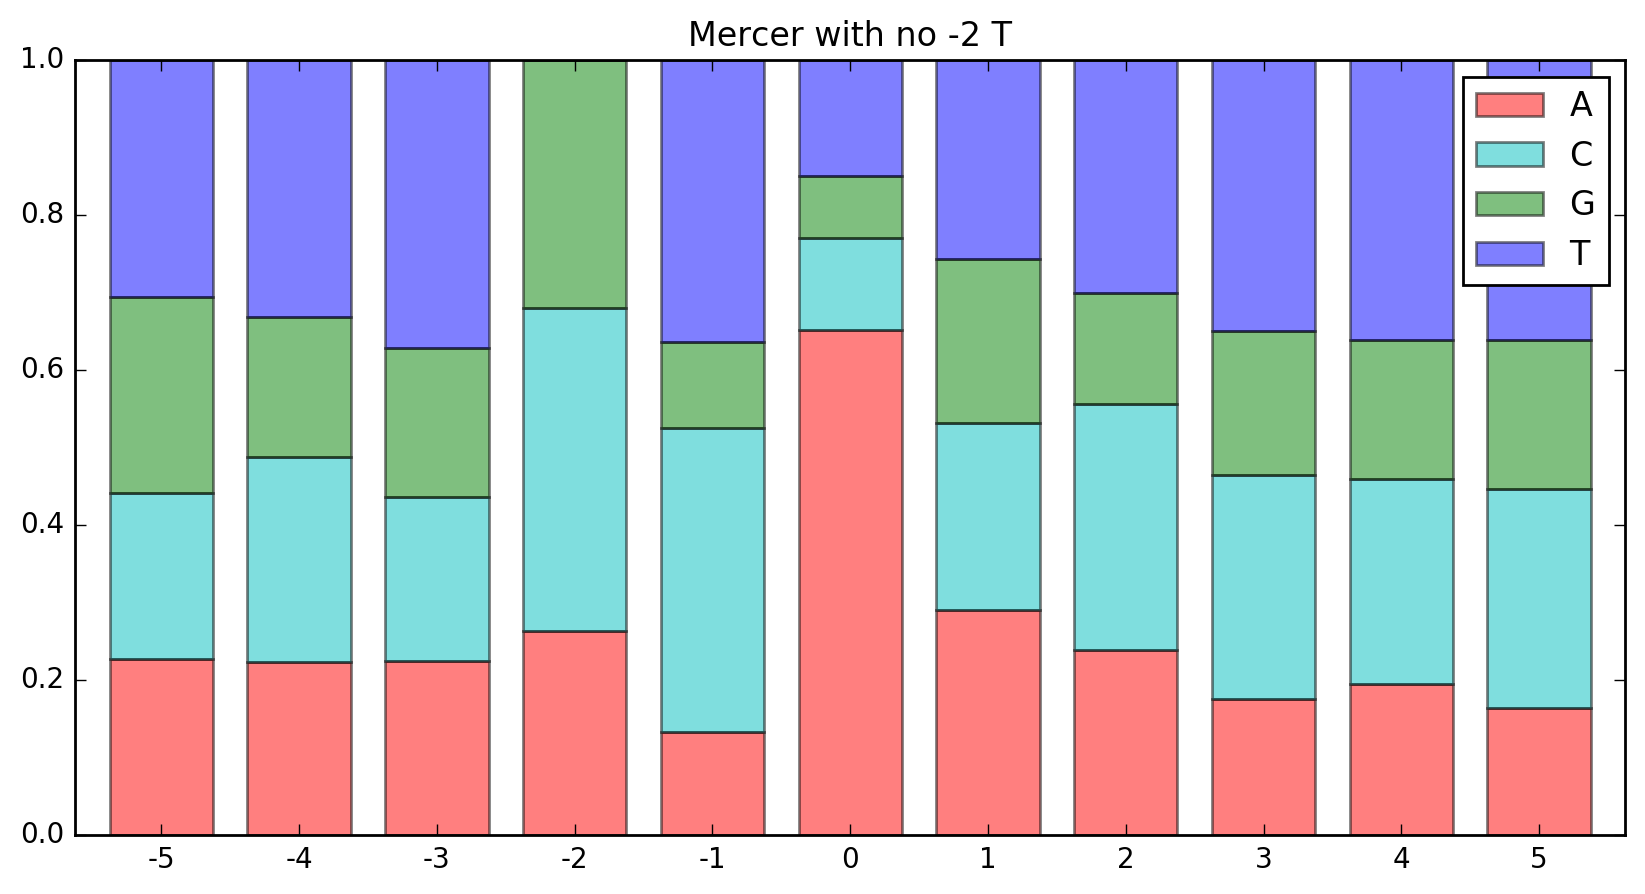

In [46]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_known, X_known):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if not seq[bp, i]: continue
            counts += seq[bp-K: bp+K+1, :4]
            total += 1
    print total
    pwm_logo(counts / total, 'Mercer et. al. branchpoints')
    
# -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp-2, 3]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, 'Mercer with -2 T')
# No -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if seq[bp-2, 3]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, 'Mercer with no -2 T')

202799


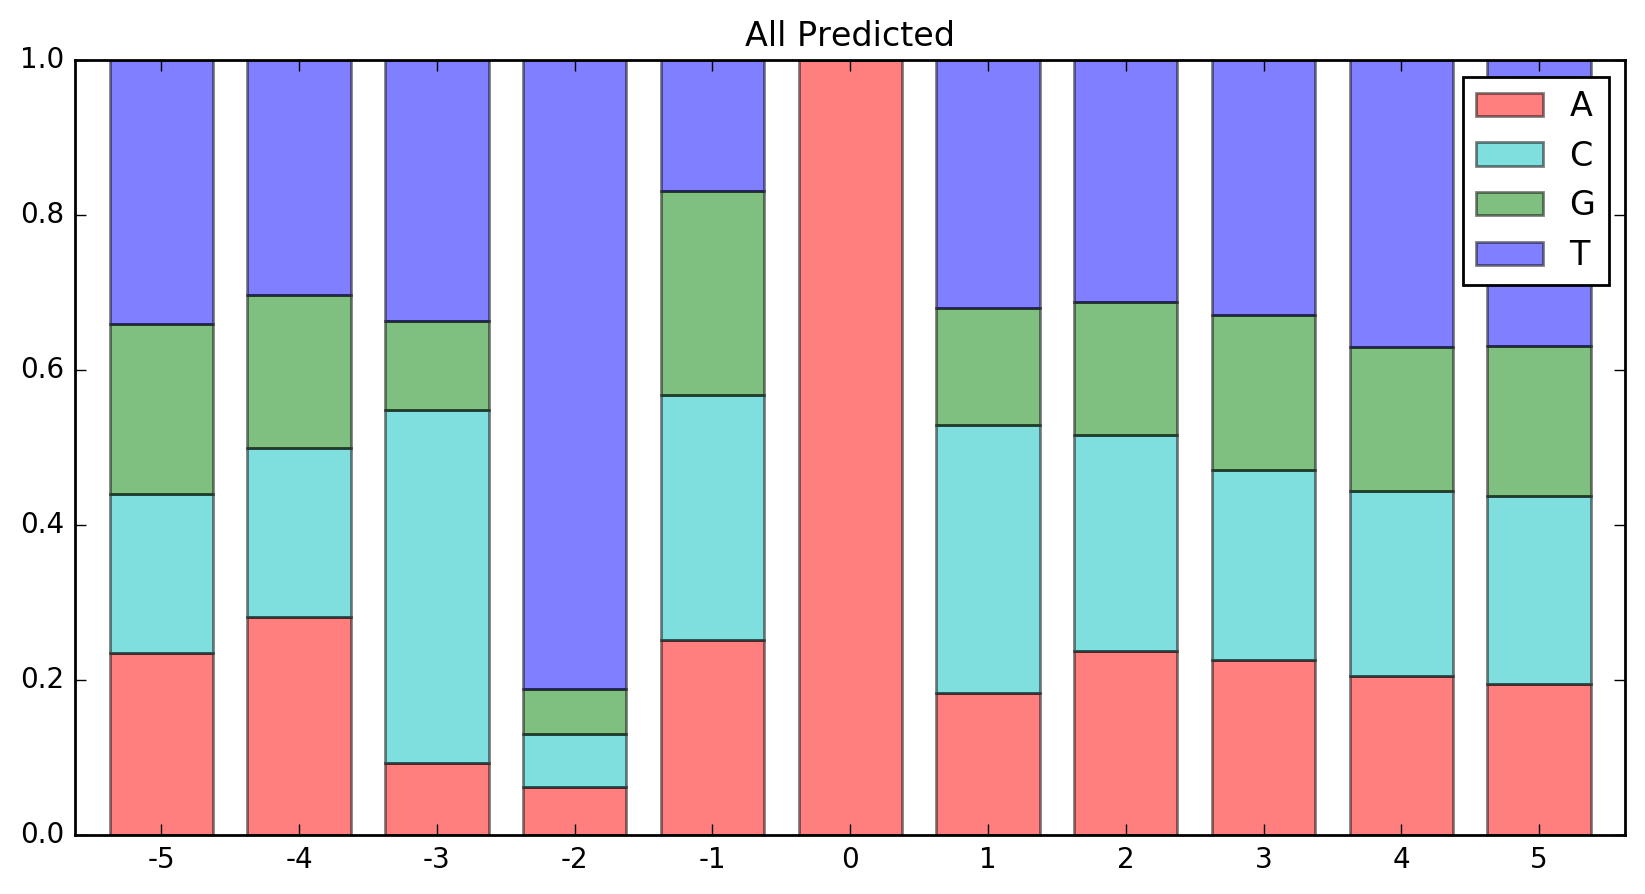

3351


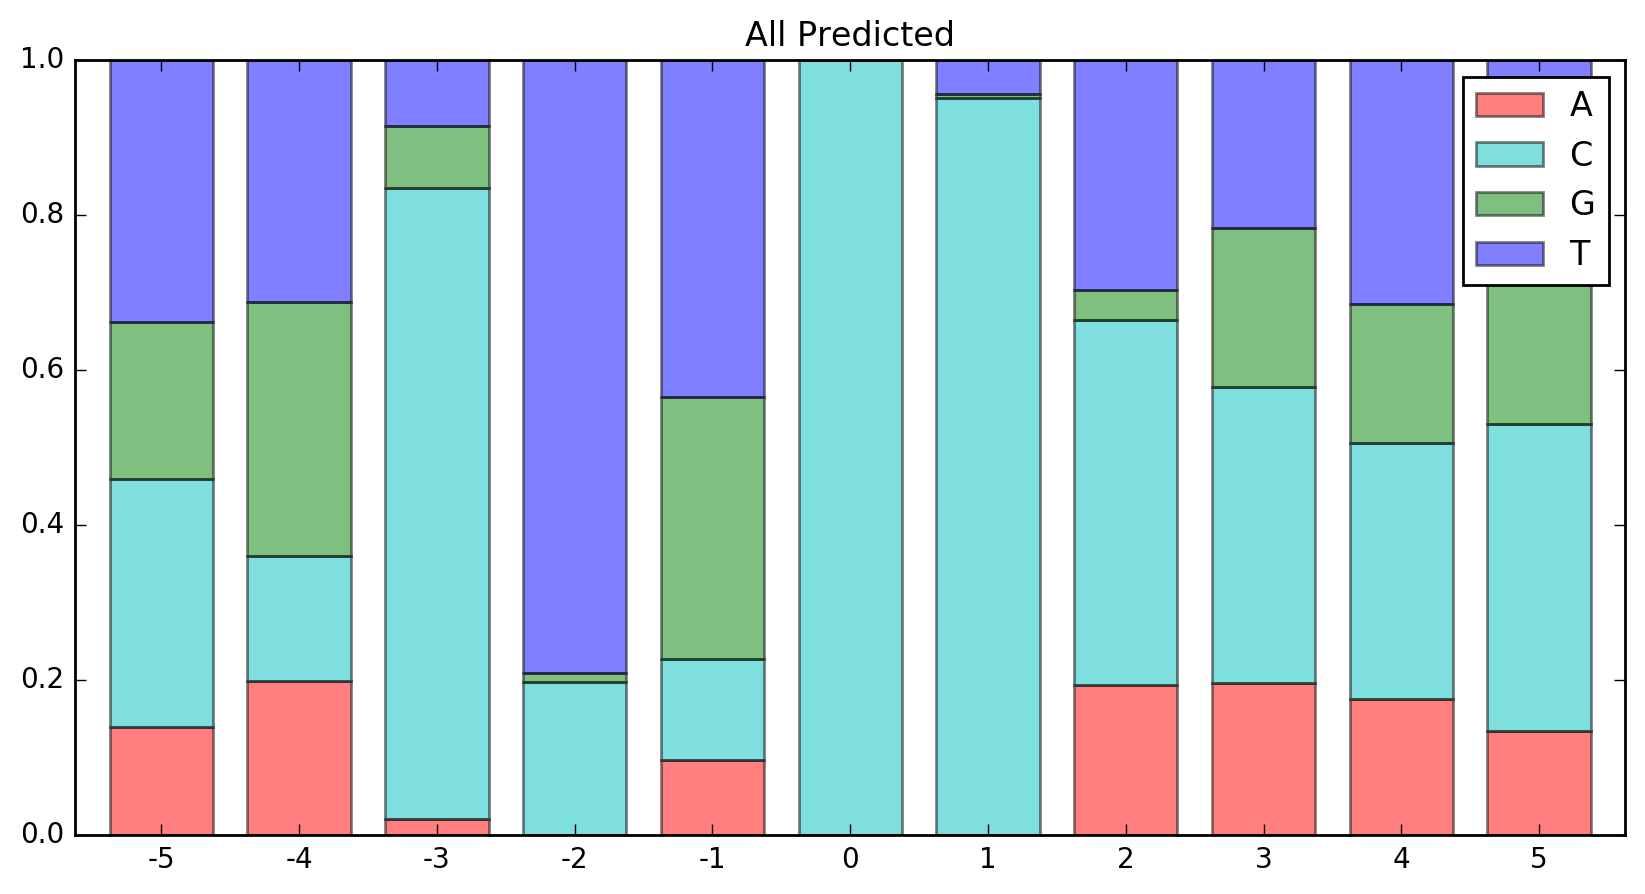

57


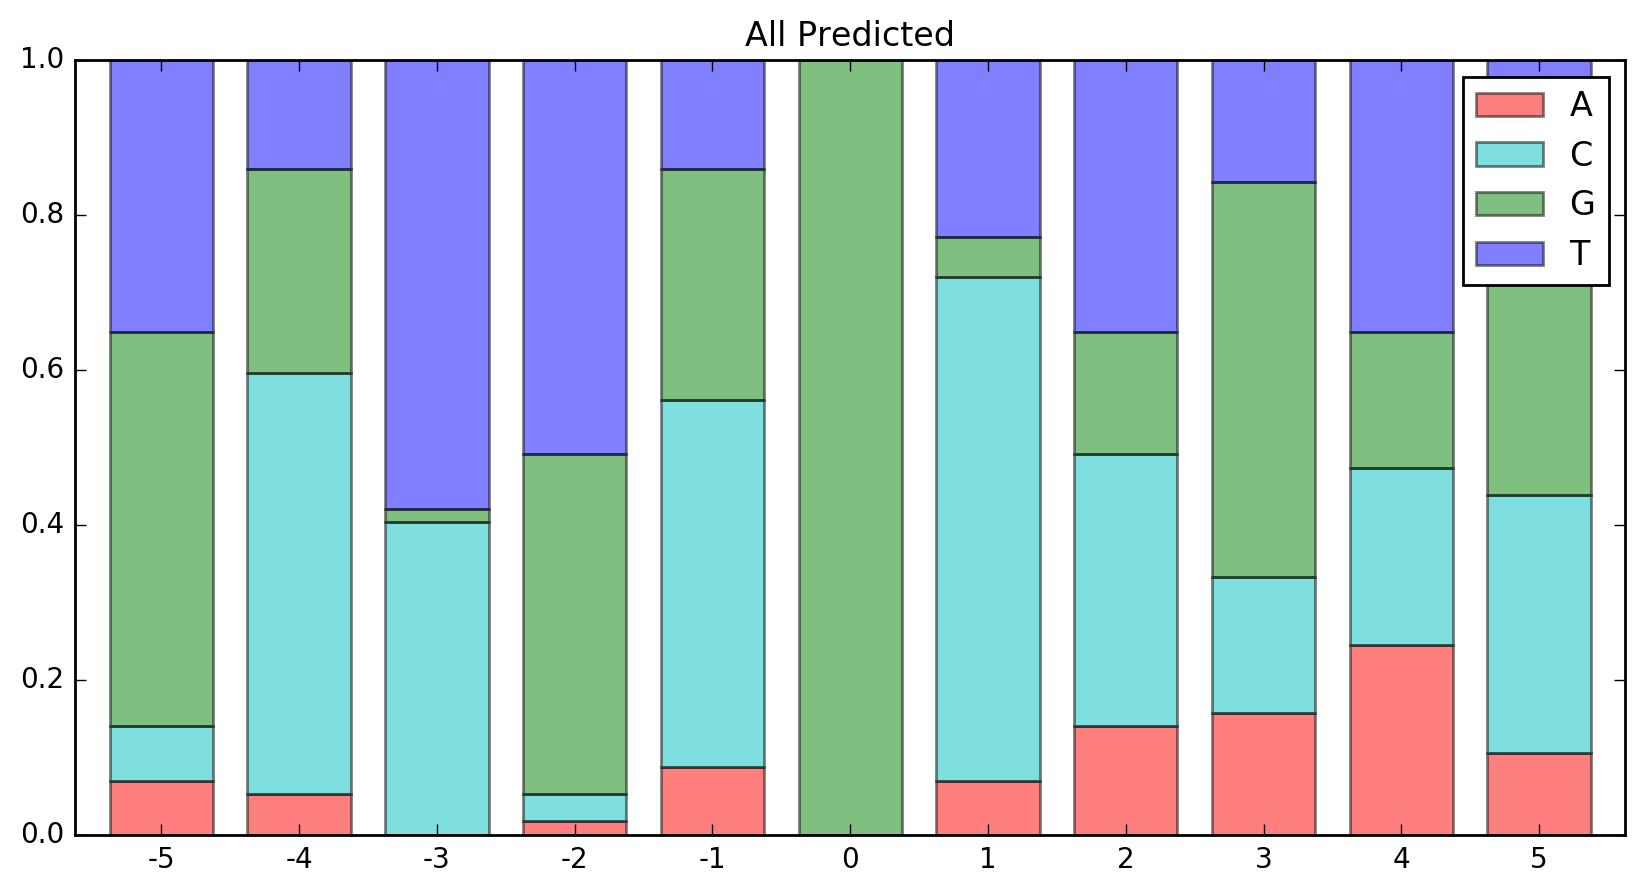

69


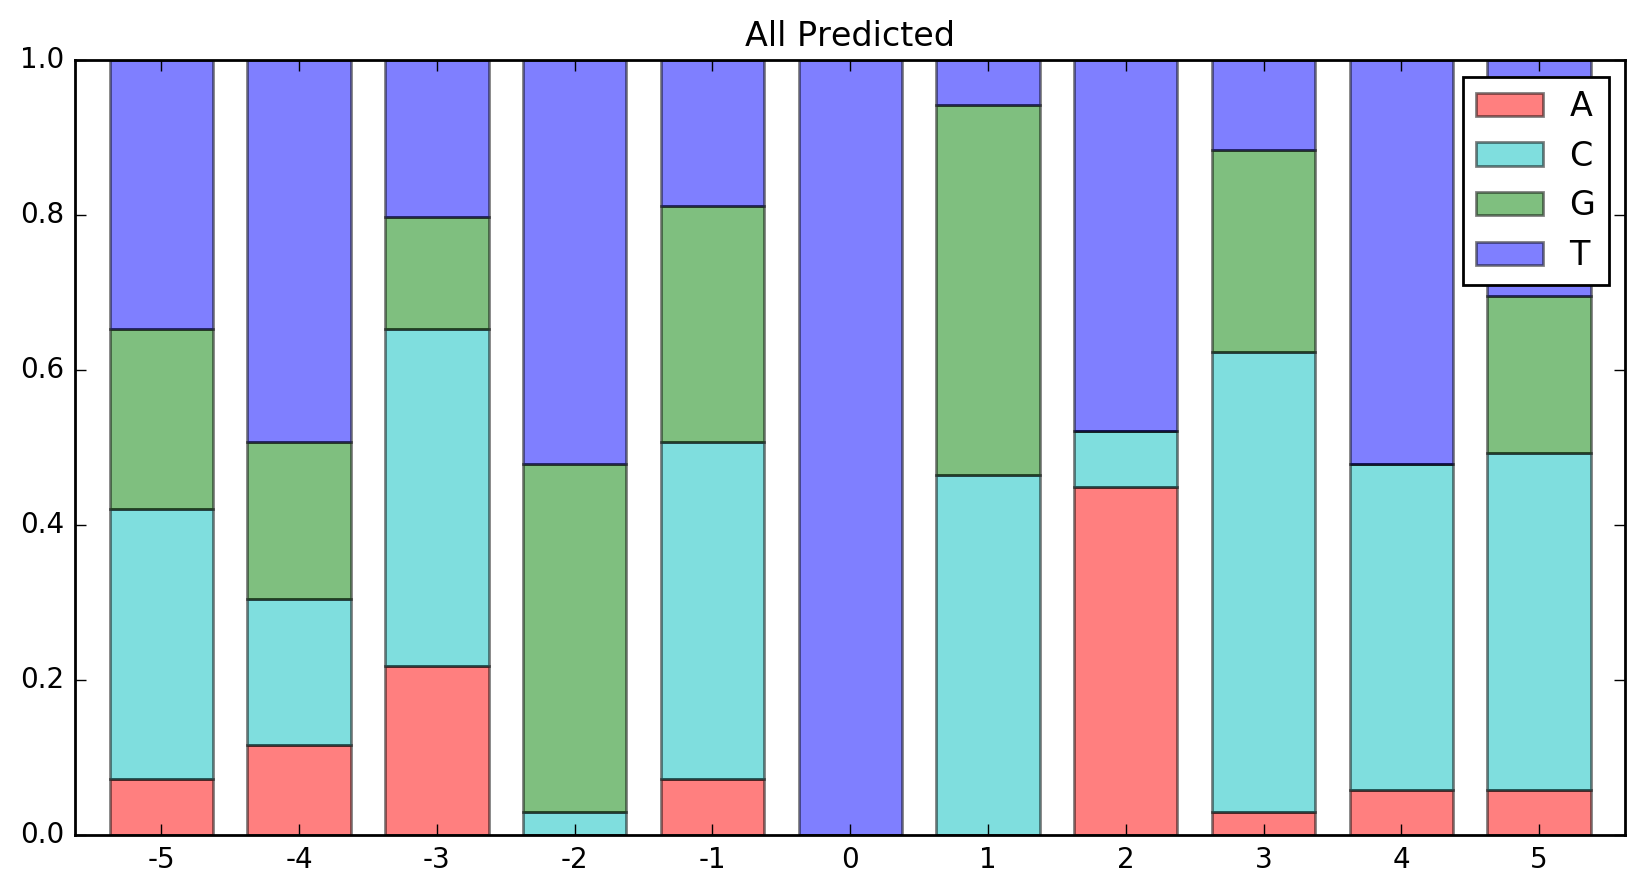

167355


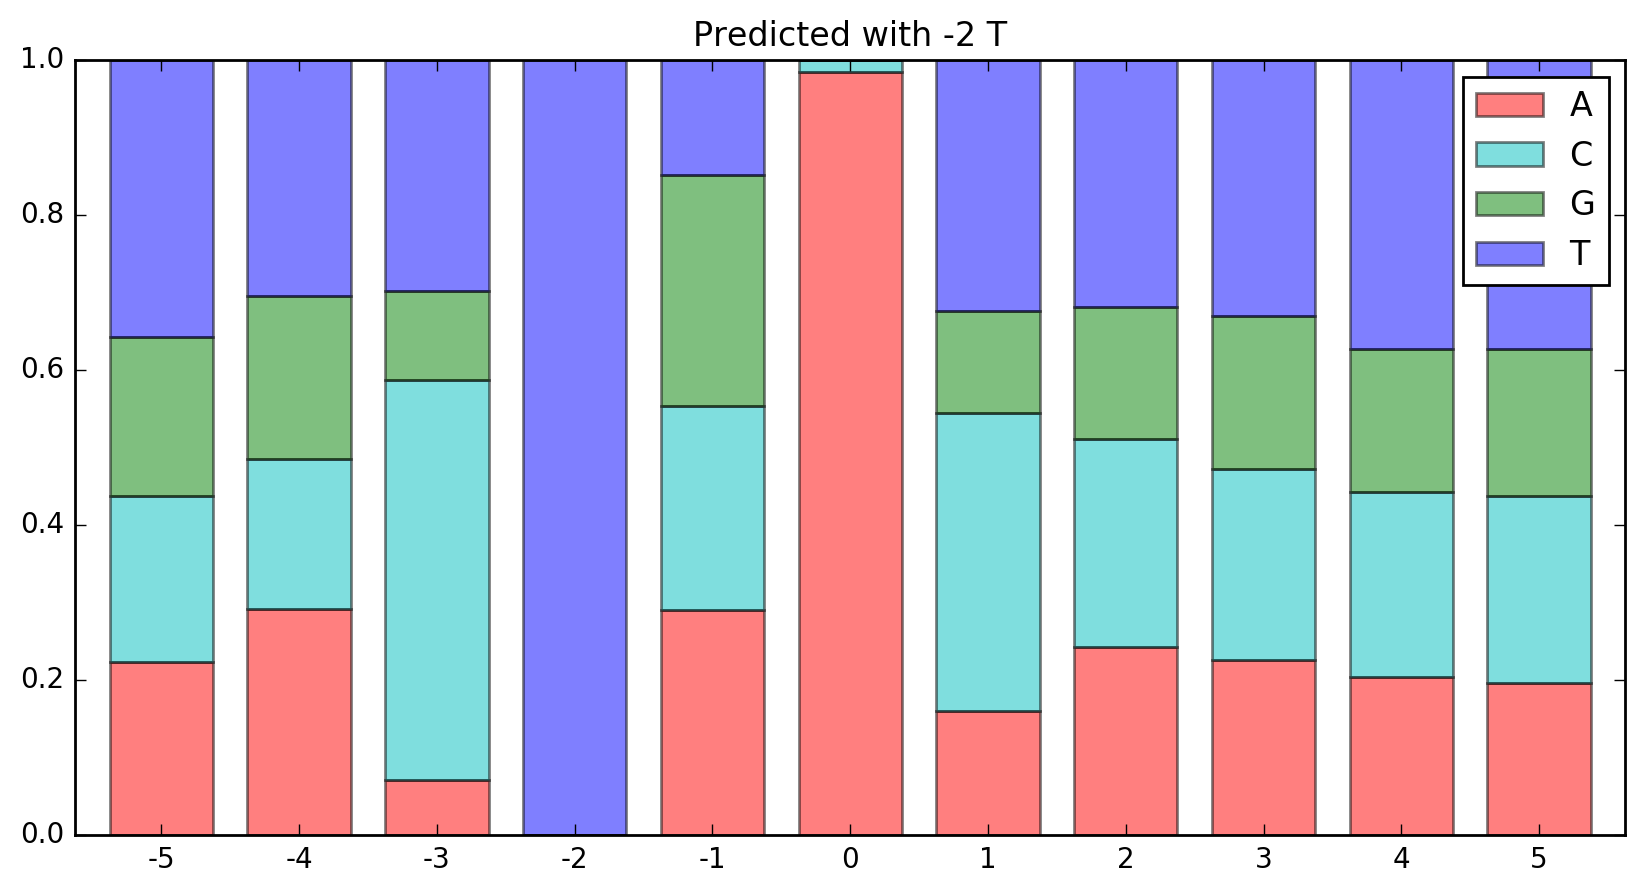

38921


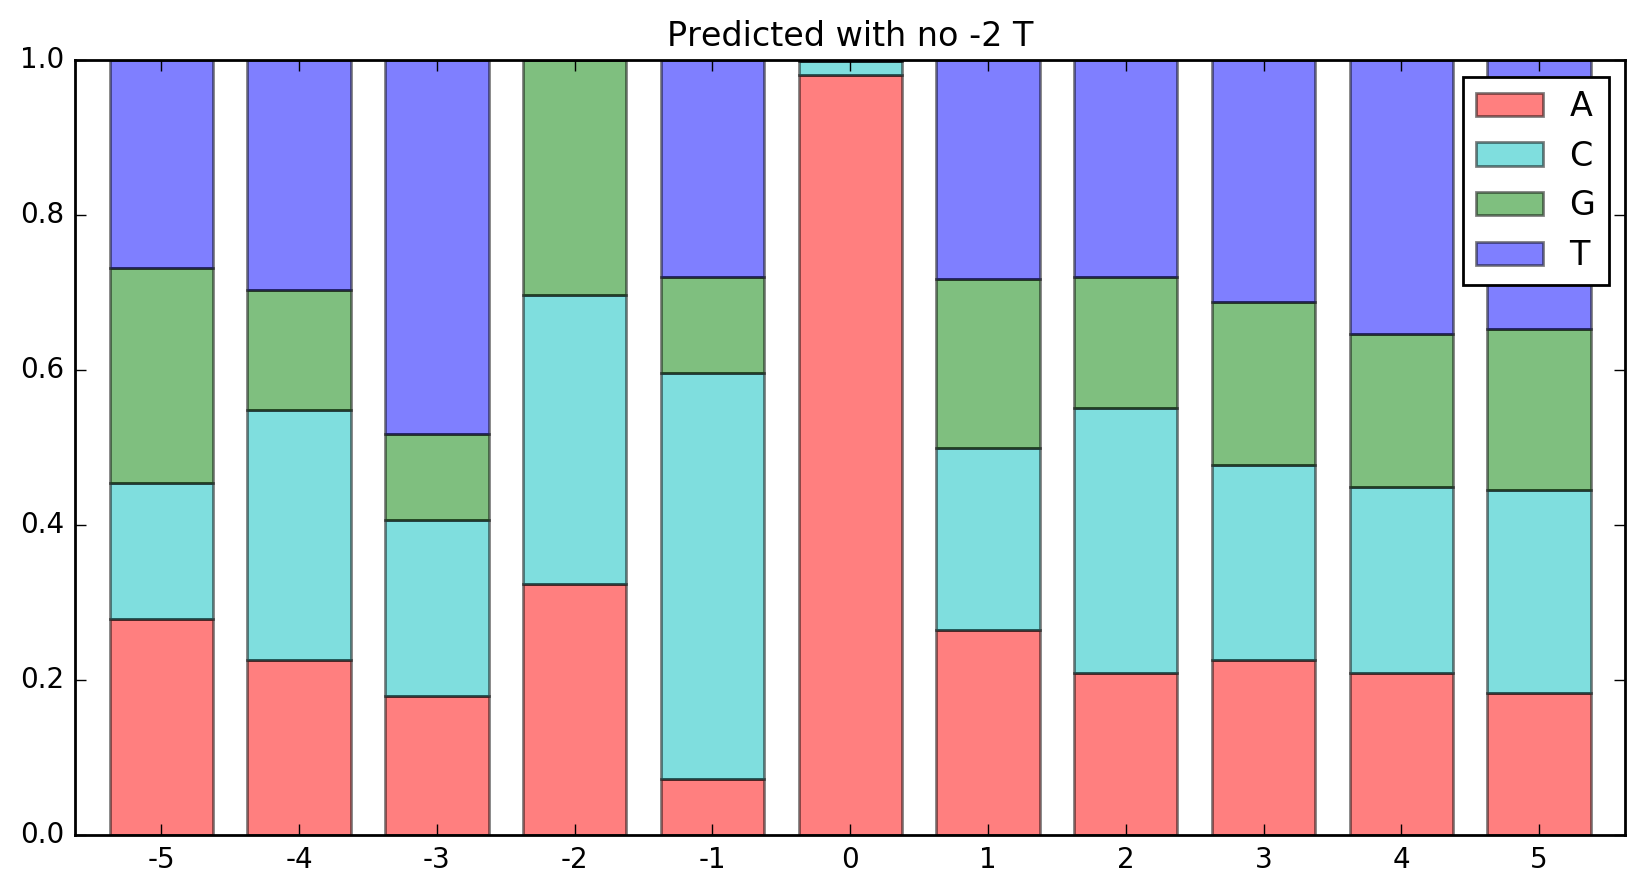

In [33]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_all, X_all):
        bp = np.argmax(target)
        if not seq[bp, i]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
    print total
    pwm_logo(counts / total, 'All Predicted')

# -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'Predicted with -2 T')
# No -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'Predicted with no -2 T')

In [34]:
def CG(title): 
    CCC = []
    GGG = []
    for i in range(41):
        CCC += [sum(bps[:, i, 1]*bps[:, i+1, 1]*bps[:, i+2, 1])]
        GGG += [sum(bps[:, i, 2]*bps[:, i+1, 2]*bps[:, i+2, 2])]
    plt.plot(range(-20, 21),
             np.array(CCC) / float(bps.shape[0]),
             label = 'CCC')
    plt.plot(range(-20, 21),
             np.array(GGG) / float(bps.shape[0]),
             label = 'GGG')
    plt.ylabel('Frequency')
    plt.xlabel('Position relative to branchpoint')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show()
    CC = []
    GG = []
    for i in range(41):
        CC += [sum(bps[:, i, 1]*bps[:, i+1, 1])]
        GG += [sum(bps[:, i, 2]*bps[:, i+1, 2])]
    plt.plot(range(-20, 21),
             np.array(CC) / float(bps.shape[0]),
             label = 'CC')
    plt.plot(range(-20, 21),
             np.array(GG) / float(bps.shape[0]),
             label = 'GG')
    plt.legend(loc = 'best')
    plt.ylabel('Frequency')
    plt.xlabel('Position relative to branchpoint')
    plt.title(title)
    plt.show()

    C = []
    G = []
    for i in range(41):
        C += [sum(bps[:, i, 1])]
        G += [sum(bps[:, i, 2])]
    plt.plot(range(-20, 21),
             np.array(C) / float(bps.shape[0]),
             label = 'C')
    plt.plot(range(-20, 21),
             np.array(G) / float(bps.shape[0]),
             label = 'G')
    plt.legend(loc = 'best')
    plt.ylabel('Frequency')
    plt.xlabel('Position relative to branchpoint')
    plt.title(title)
    plt.show()

(42798, 43, 4)


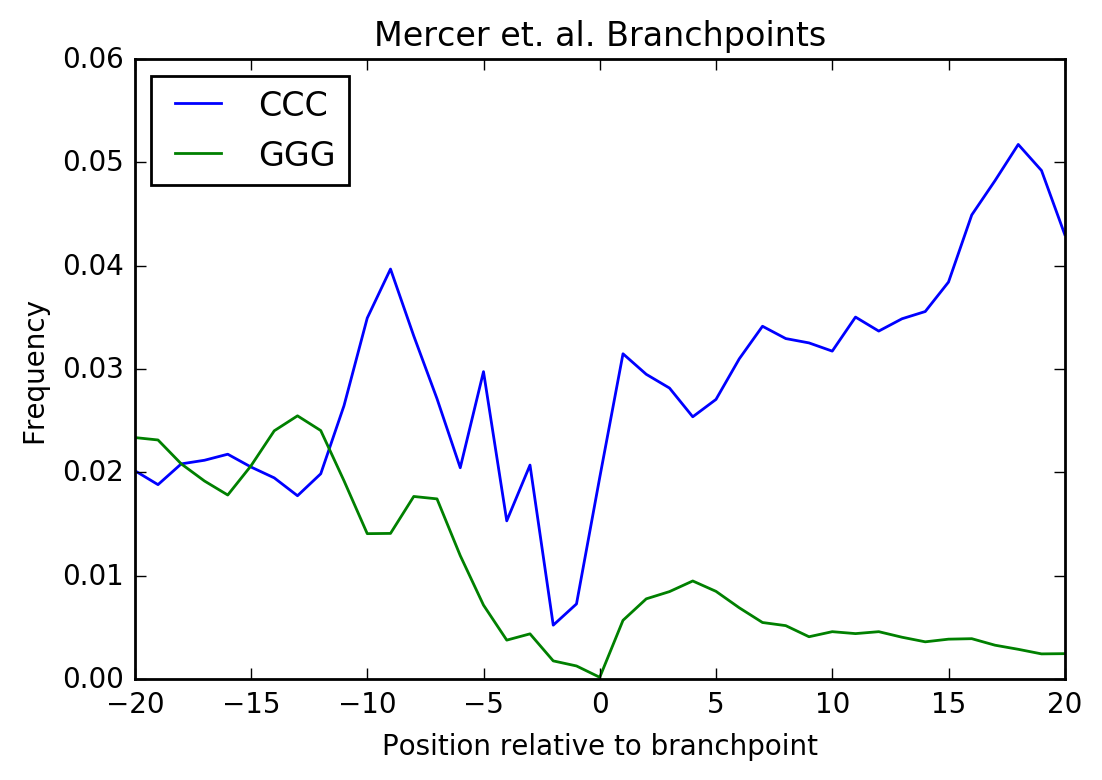

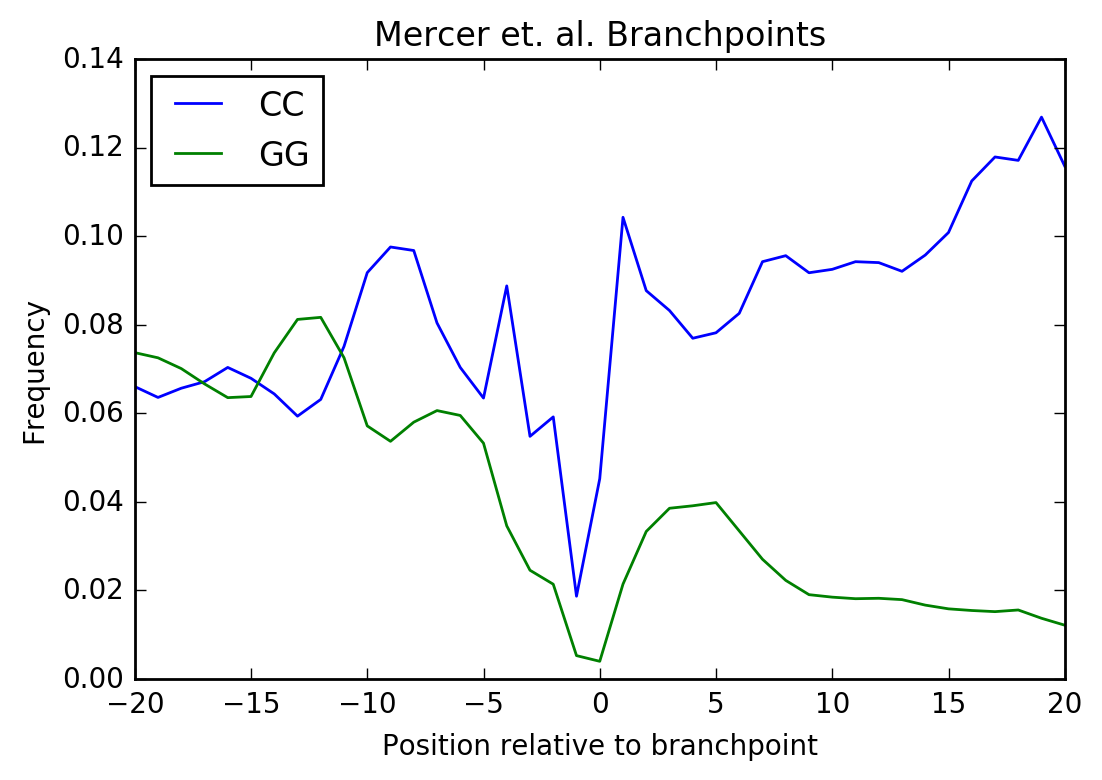

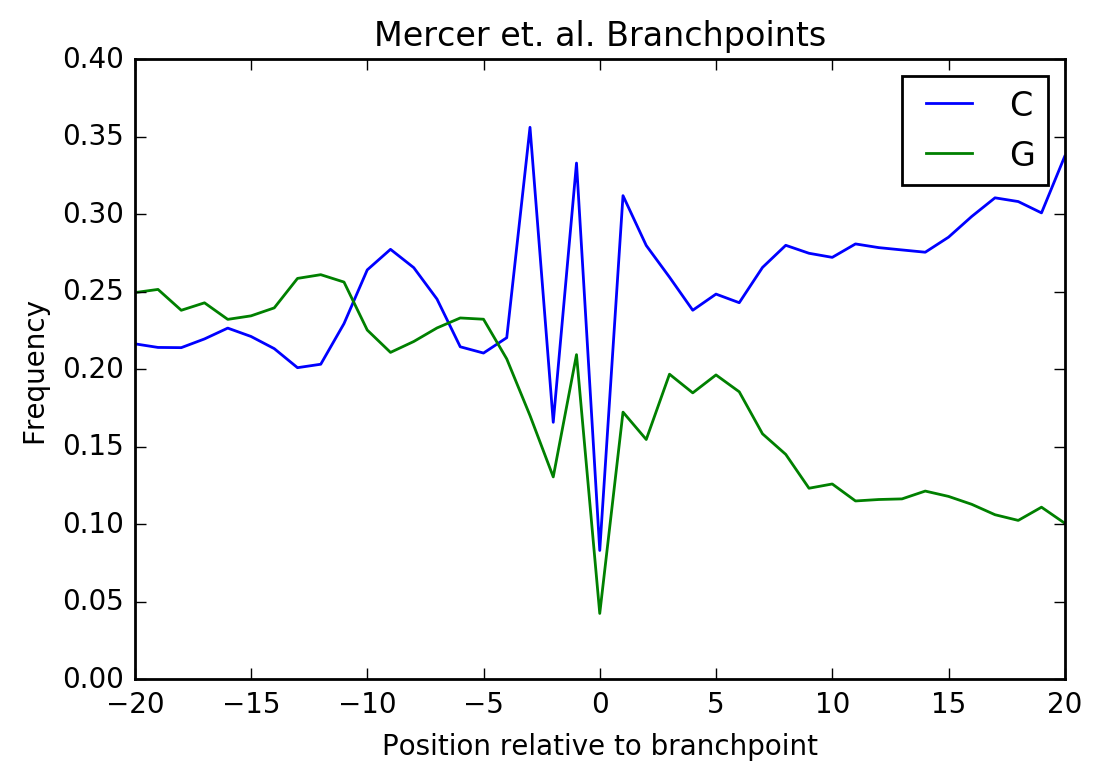

In [124]:
bps = []
for seq, target in zip(X_known, y_known):
    for bp in np.nonzero(target)[0]:
        if bp-20 < 0 or bp+23 > L: continue
        bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG('Mercer et. al. Branchpoints')

(160785, 43, 4)


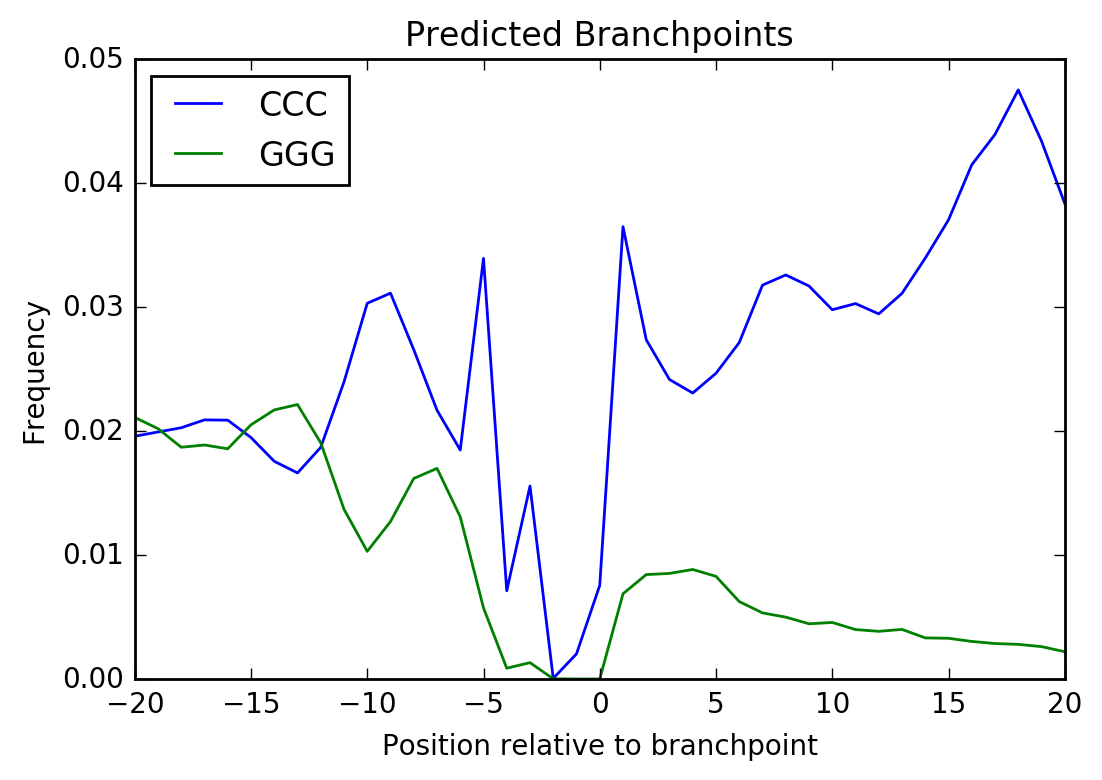

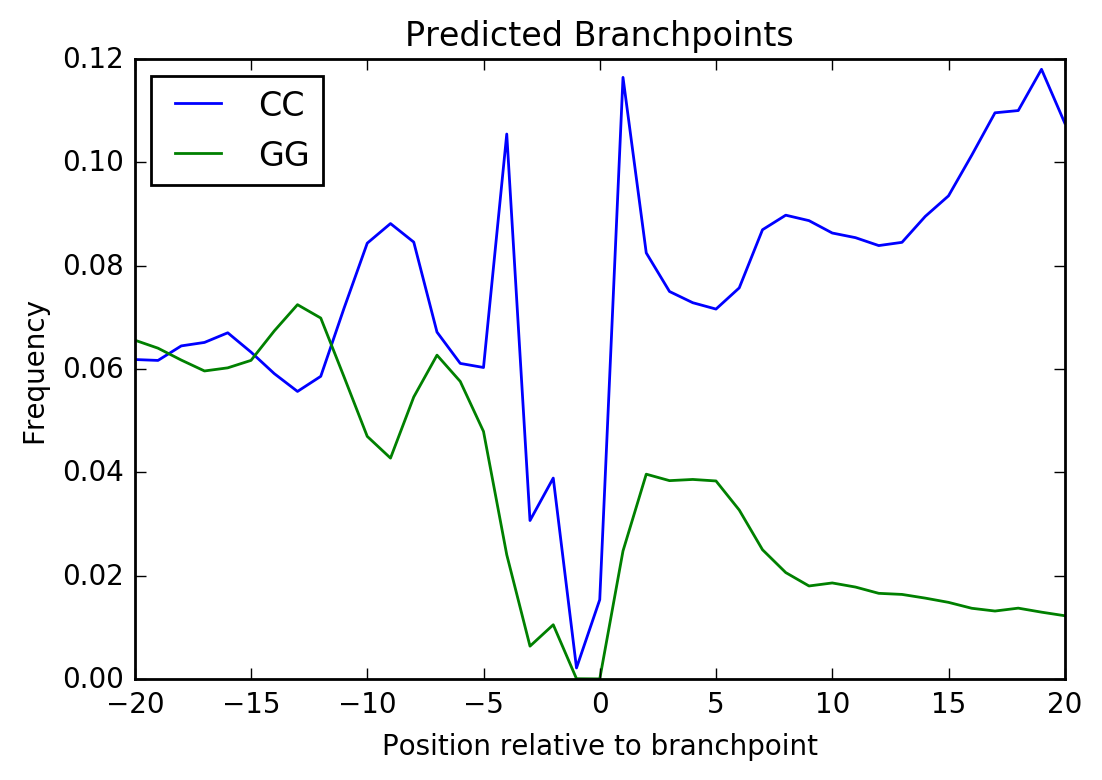

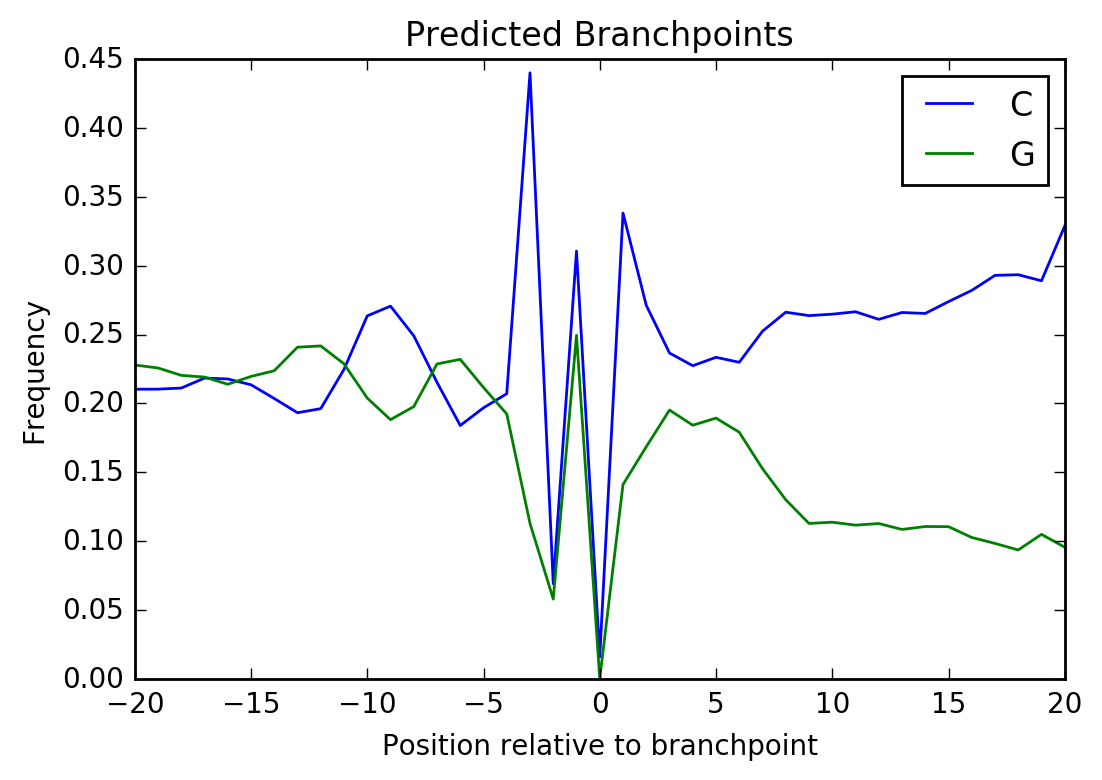

In [125]:
bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG('Predicted Branchpoints')

(17292, 43, 4)


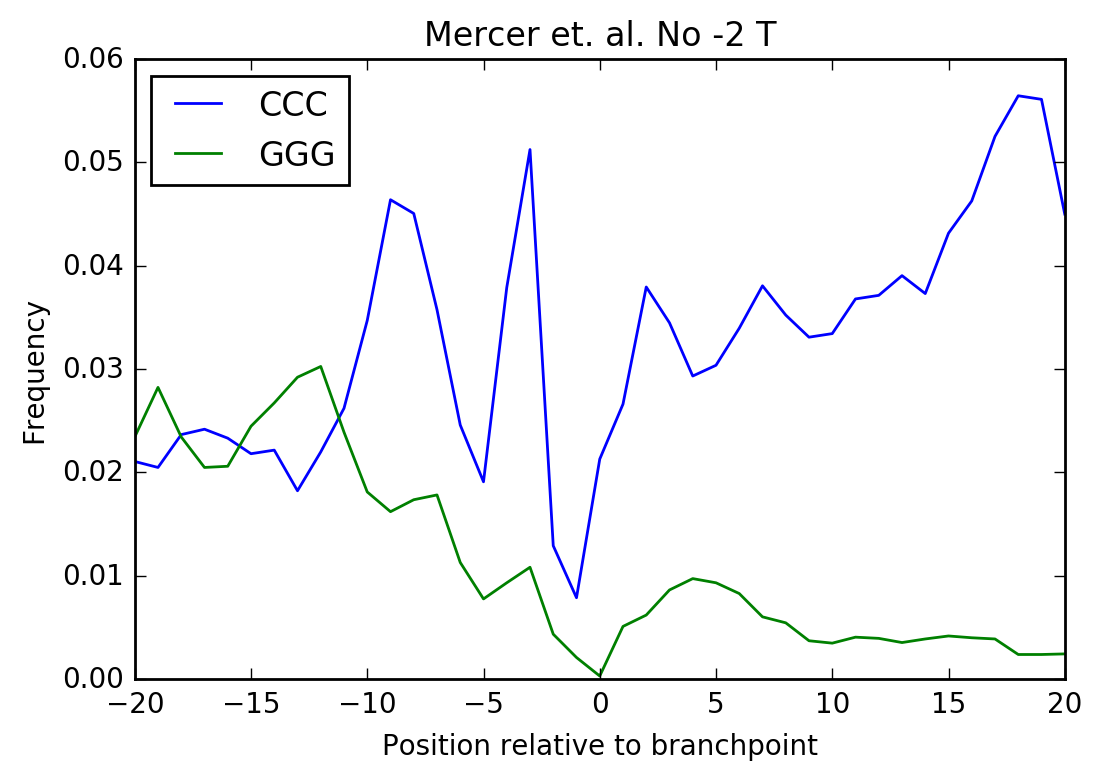

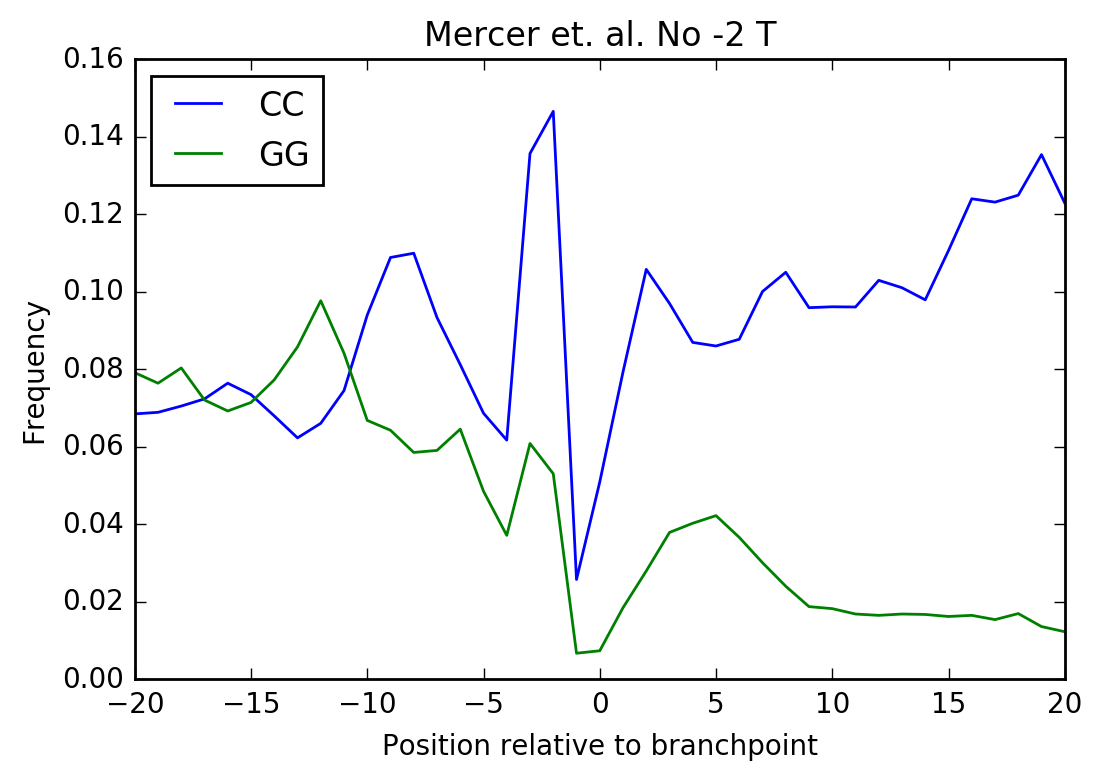

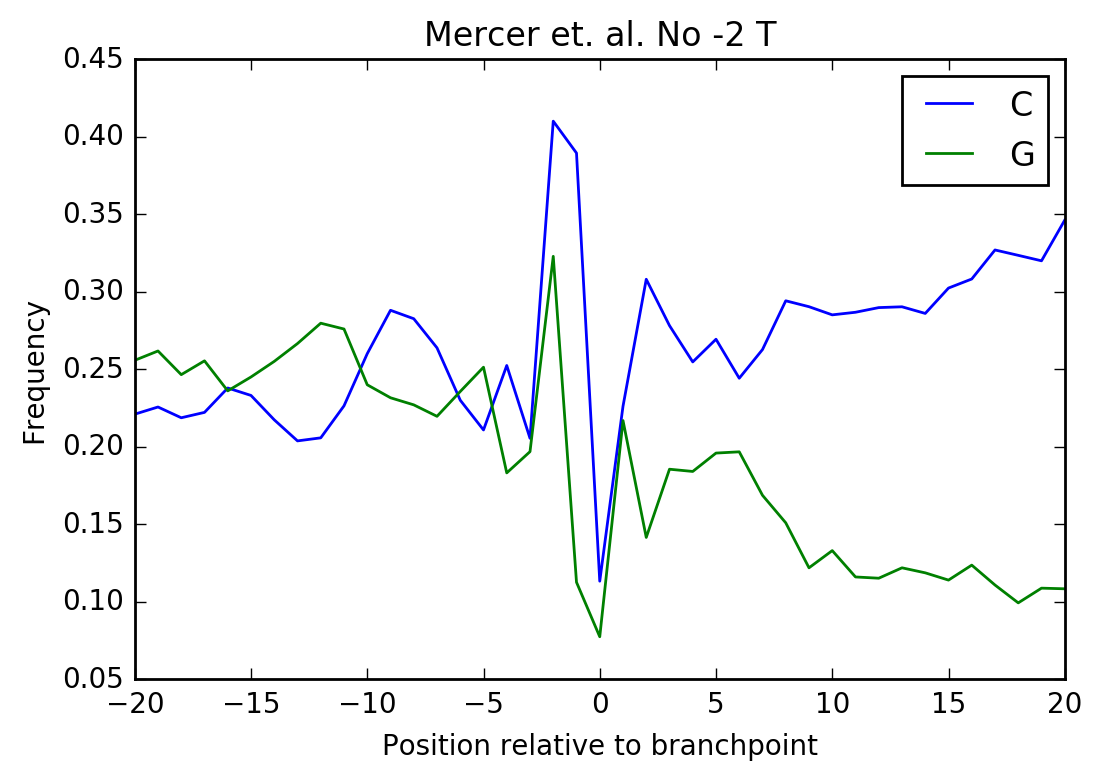

In [126]:
bps = []
for seq, target in zip(X_known, y_known):
    for bp in np.nonzero(target)[0]:
        if bp-20 < 0 or bp+23 > L: continue
        if seq[bp-2, 3]: continue
        bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG('Mercer et. al. No -2 T')

(30840, 43, 4)


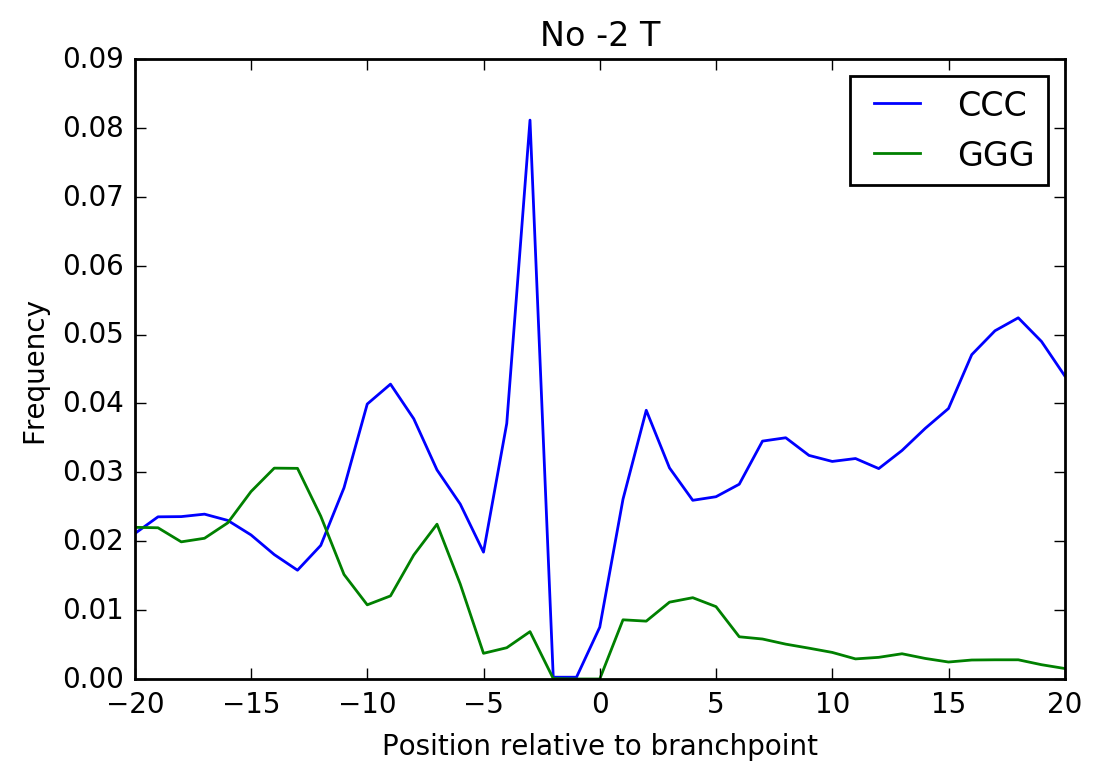

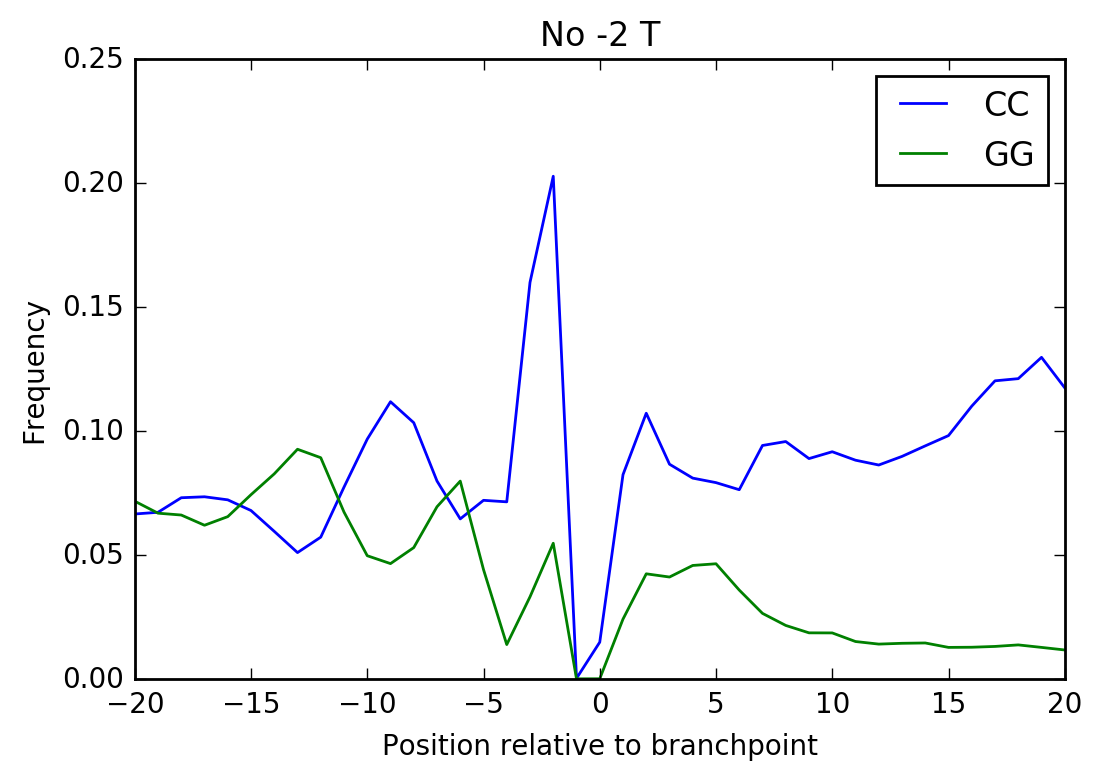

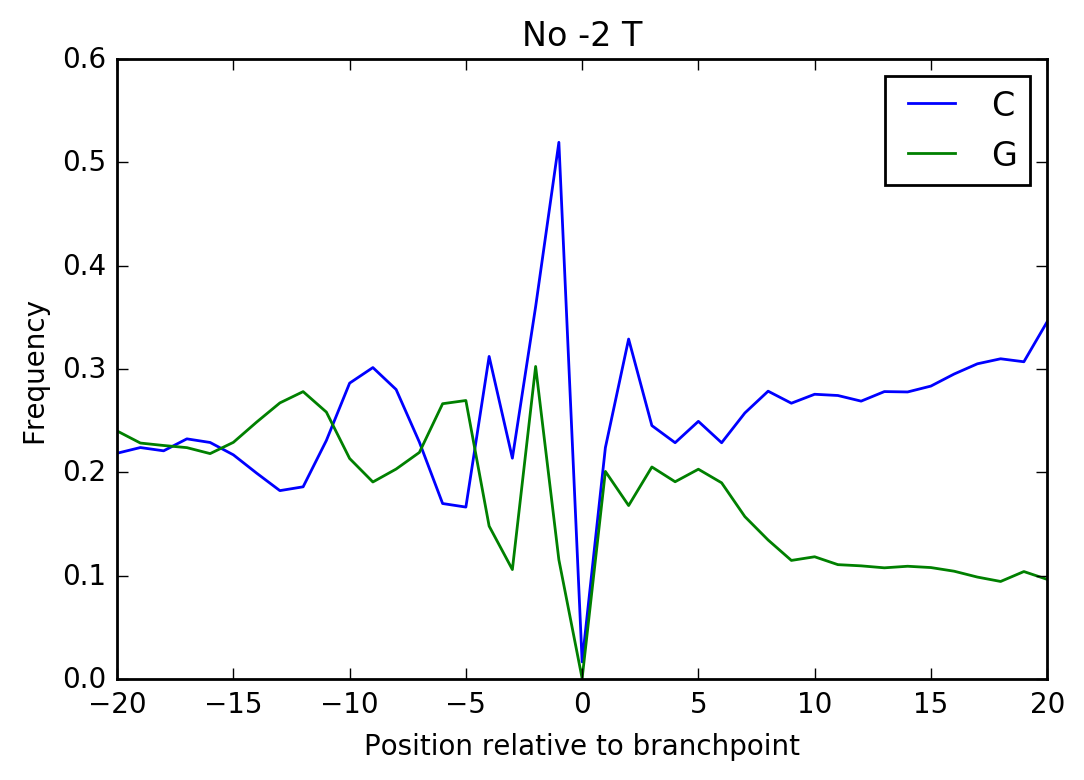

In [127]:
bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    if seq[bp-2, 3]: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG('No -2 T')

(3549, 43, 4)


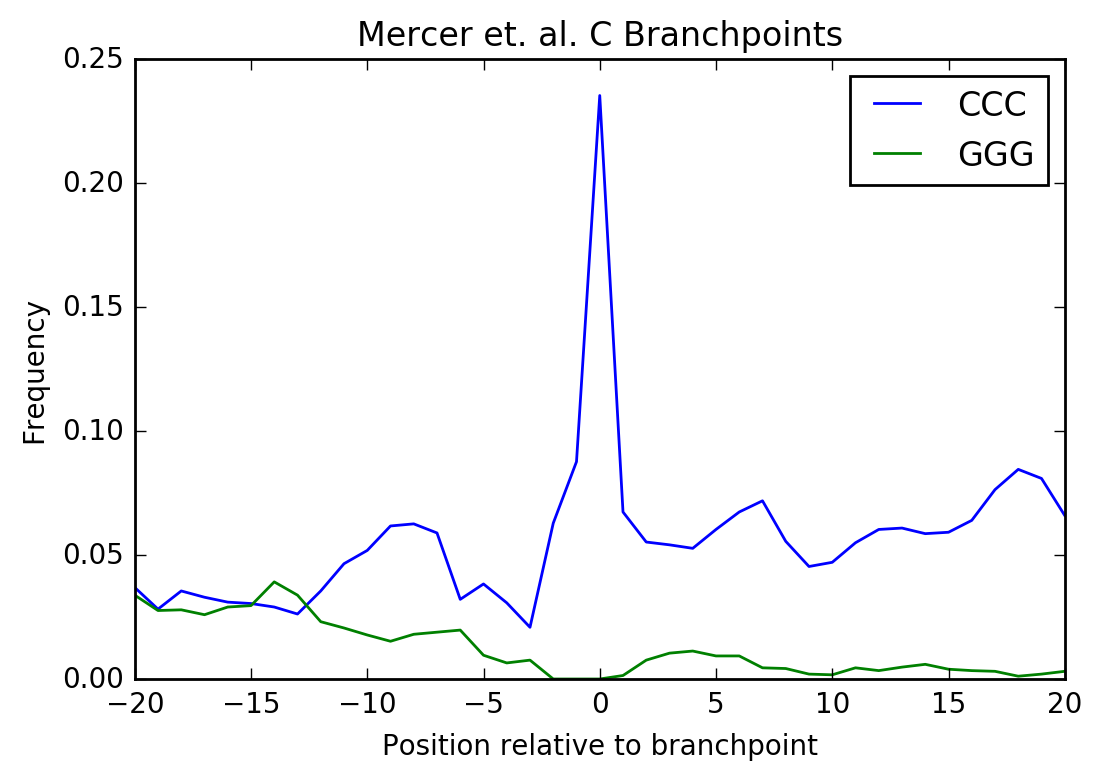

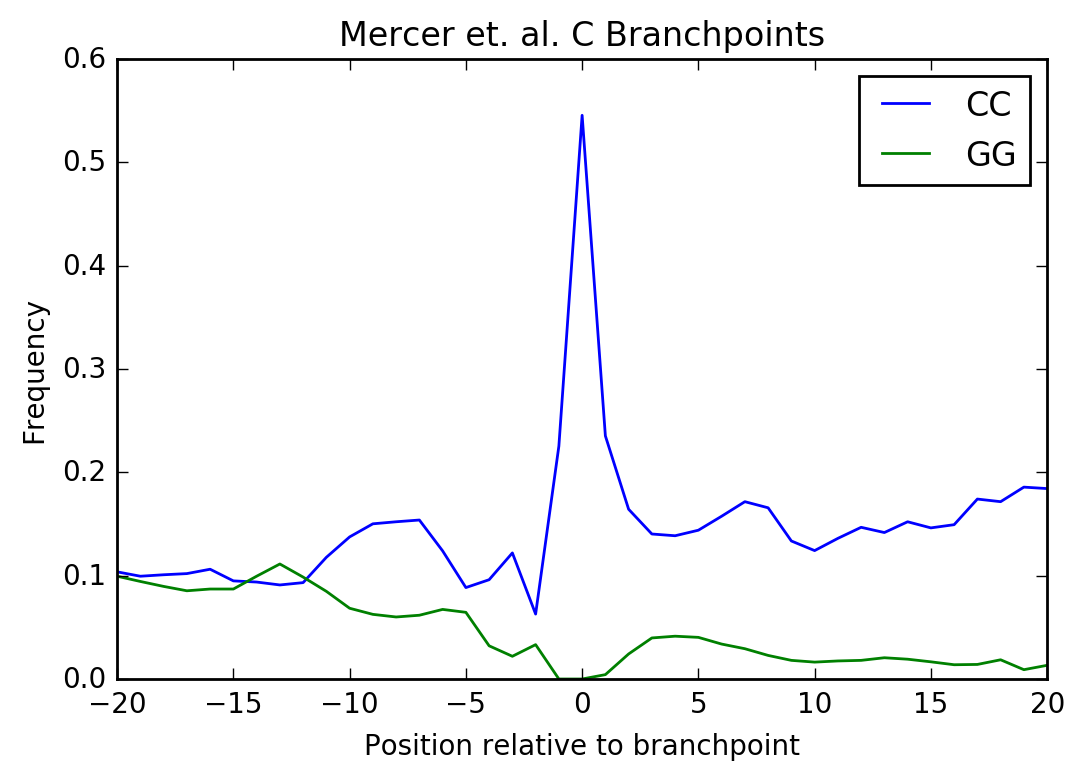

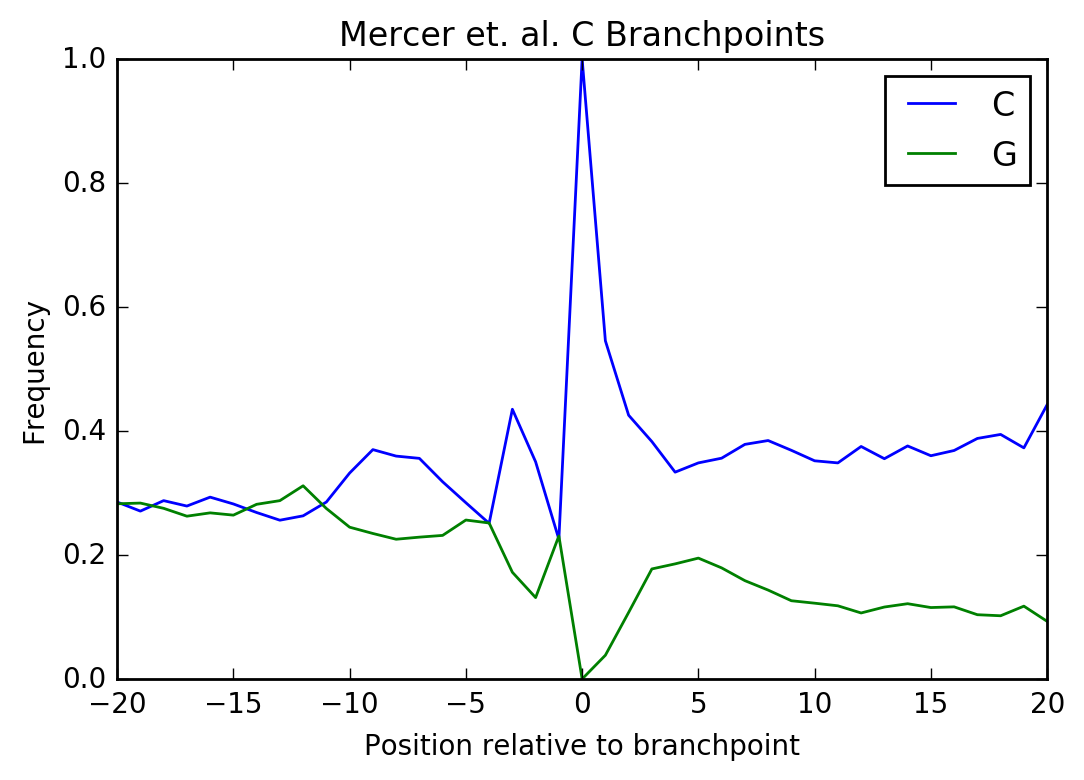

In [128]:
bps = []
for seq, target in zip(X_known, y_known):
    for bp in np.nonzero(target)[0]:
        if bp-20 < 0 or bp+23 > L: continue
        if not seq[bp, 1]: continue
        bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG('Mercer et. al. C Branchpoints')

(2586, 43, 4)


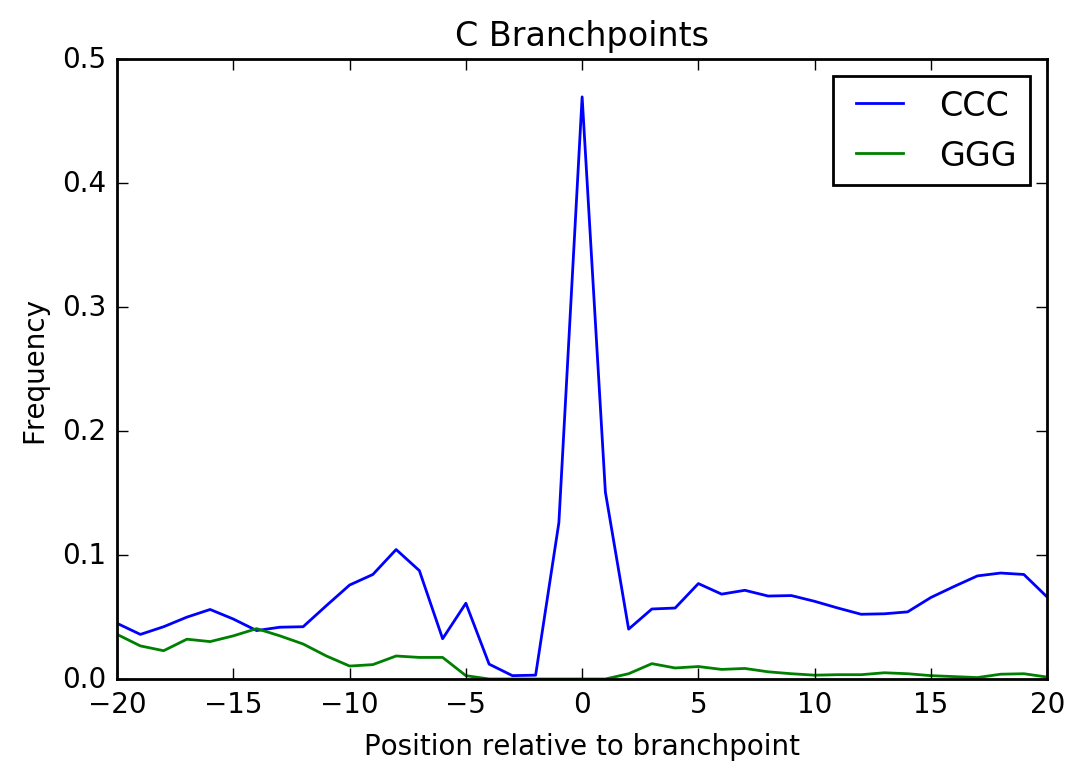

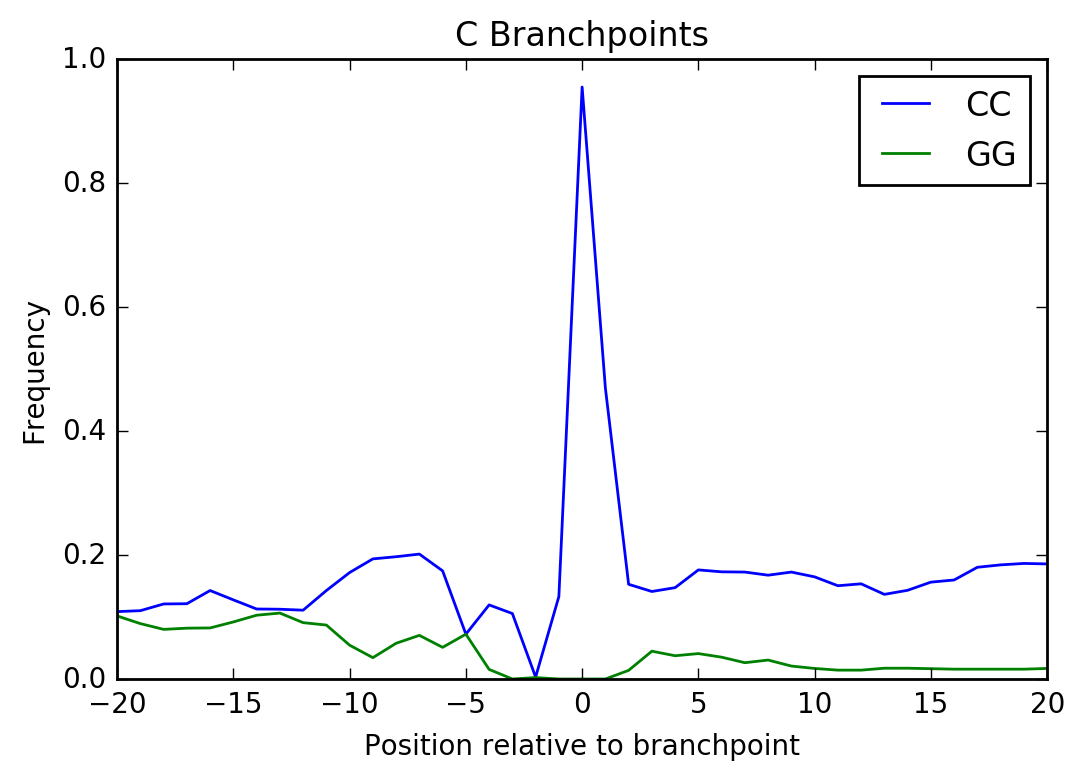

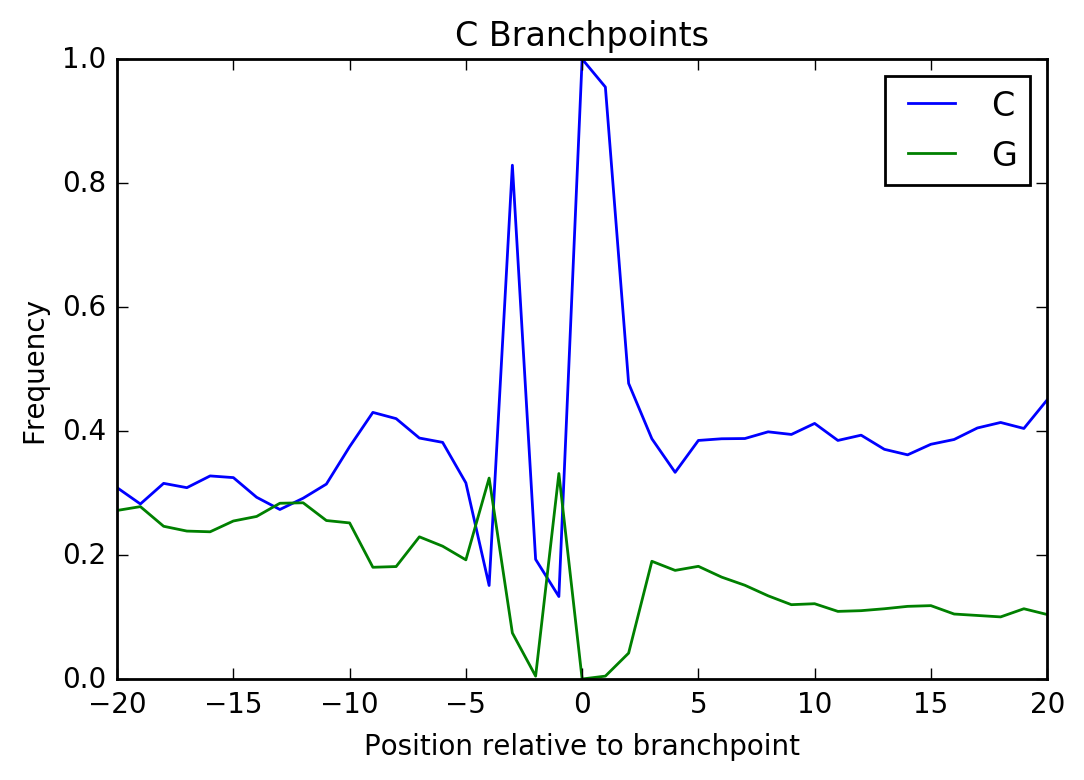

In [129]:
bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    if not seq[bp, 1]: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG('C Branchpoints')

24837
(19309, 43, 4)


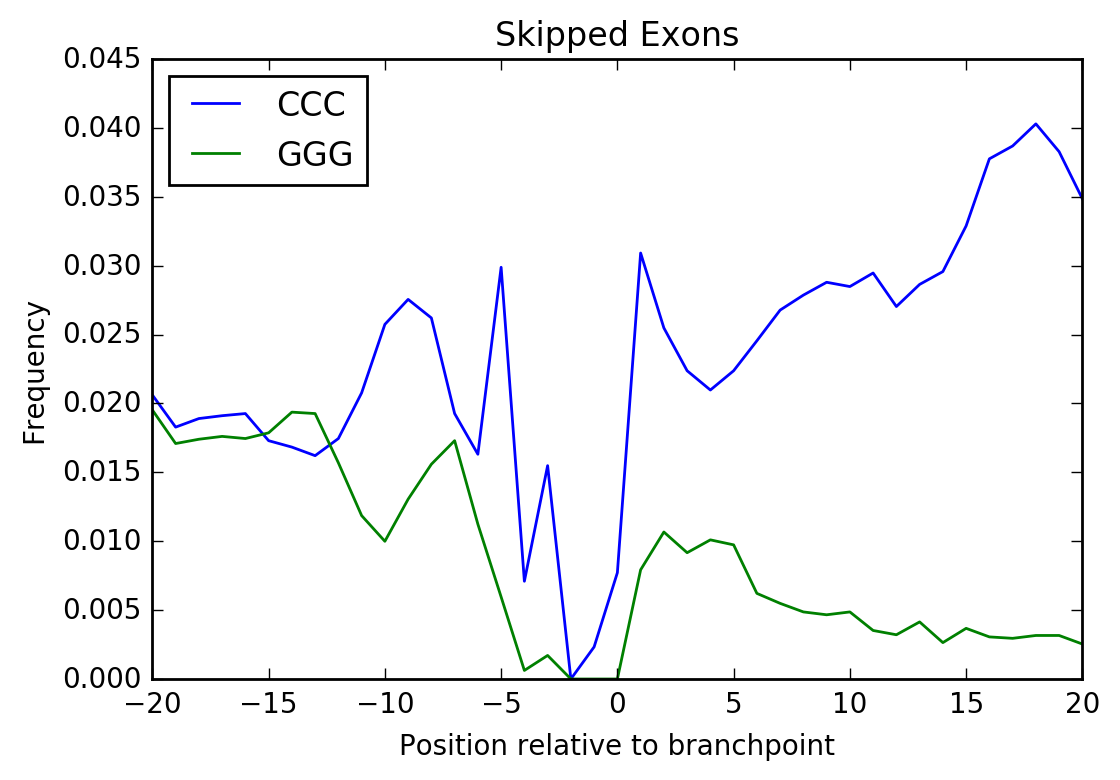

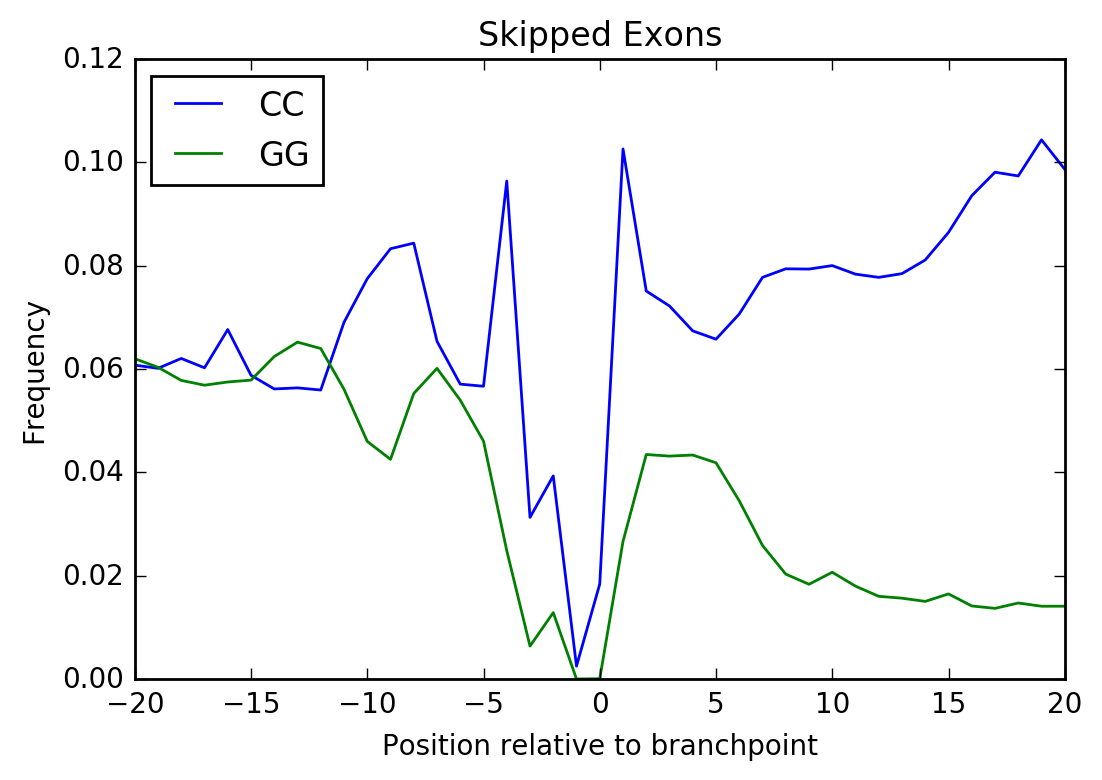

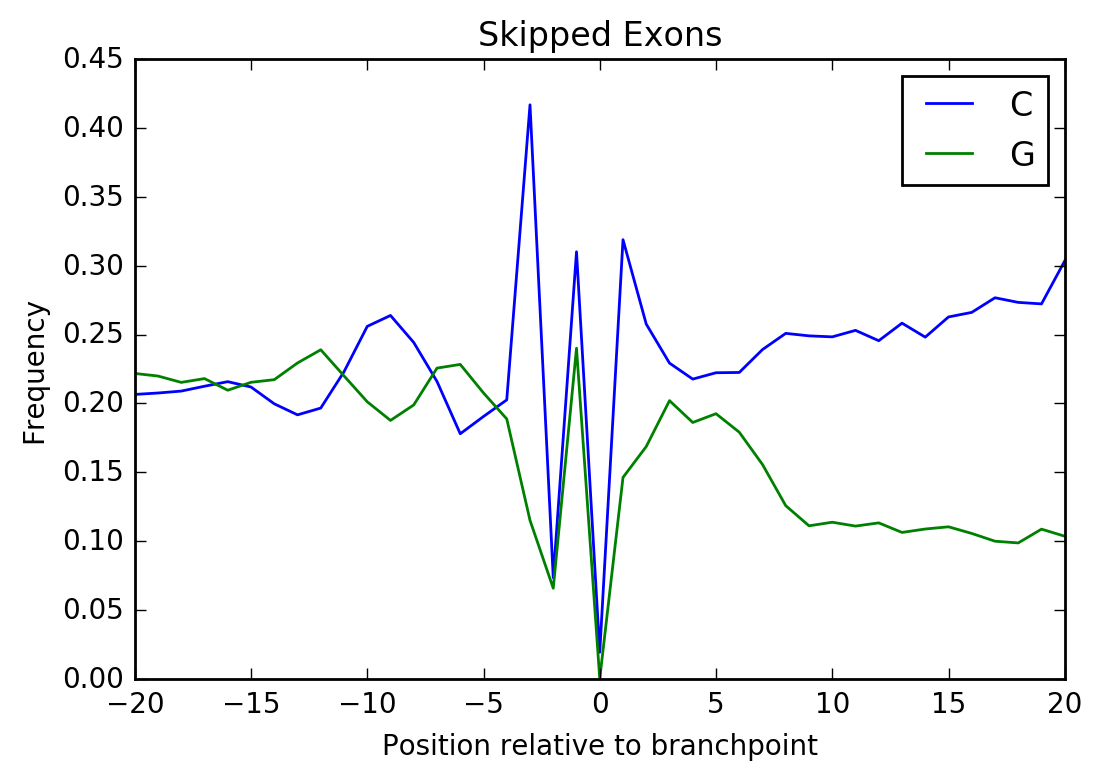

In [131]:
# Look at skipped exons!
skipped_idx = np.array([coord in se[chrom] for chrom, coord in zip(a_chroms, a_coords)])
print sum(skipped_idx)
bps = []
for seq, bp in zip(X_all[skipped_idx], np.argmax(y_all[skipped_idx],axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG('Skipped Exons')

6519
(4486, 43, 4)


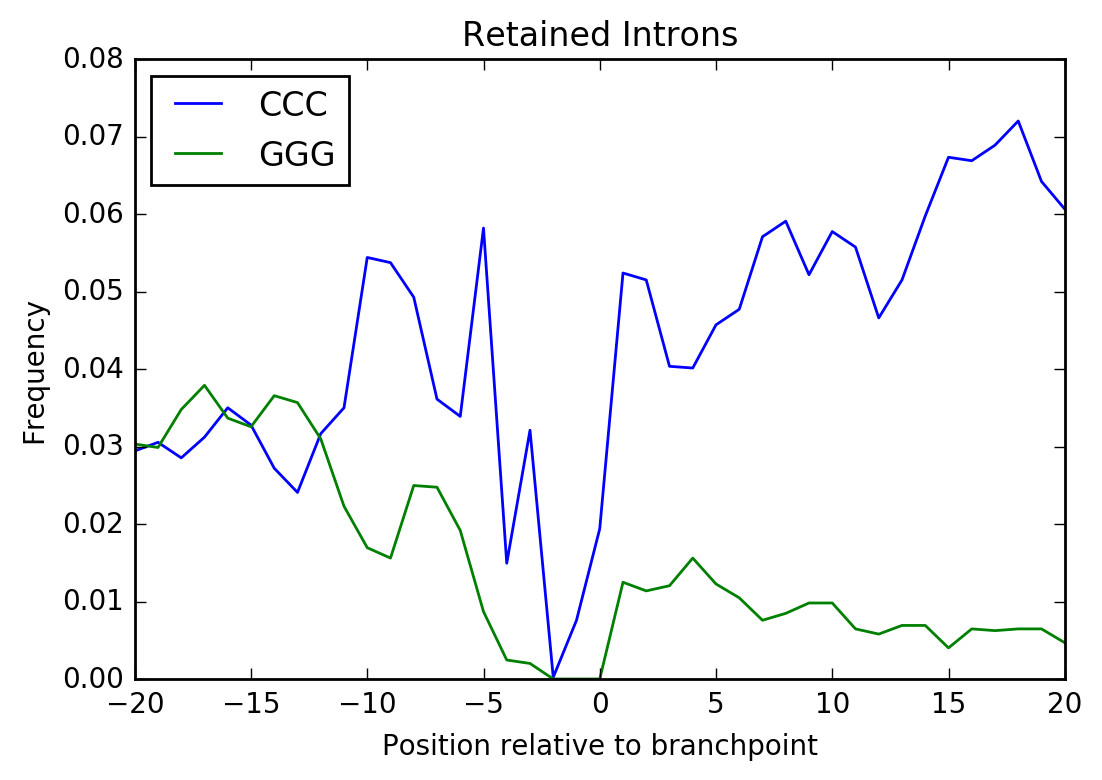

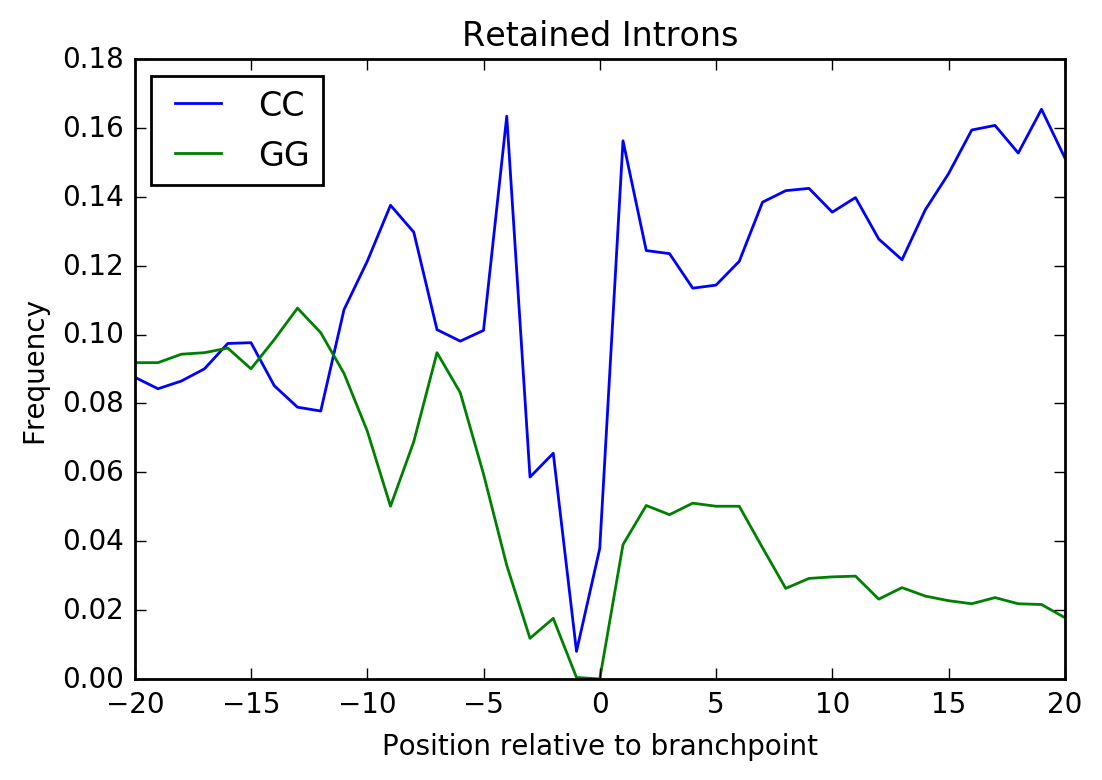

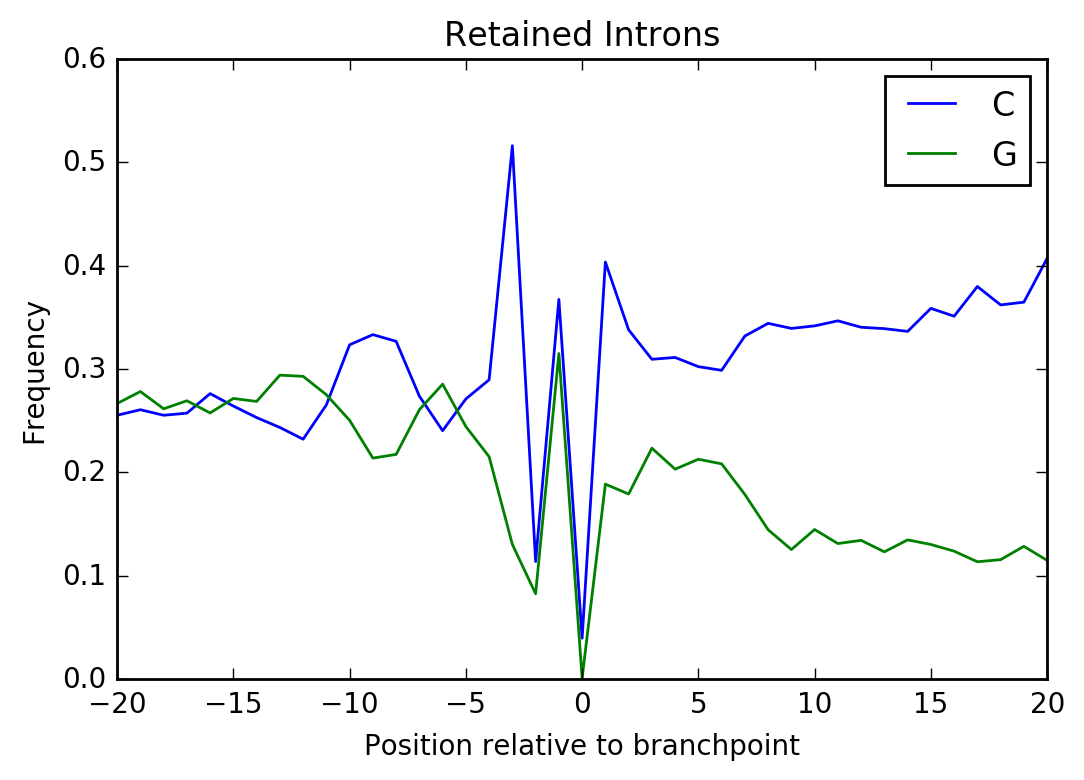

In [132]:
retained_idx = np.array([coord in ri[chrom] for chrom, coord in zip(a_chroms, a_coords)])
print sum(retained_idx)
bps = []
for seq, bp in zip(X_all[retained_idx], np.argmax(y_all[retained_idx],axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG('Retained Introns')

# 3'ss motifs by motif type

3352


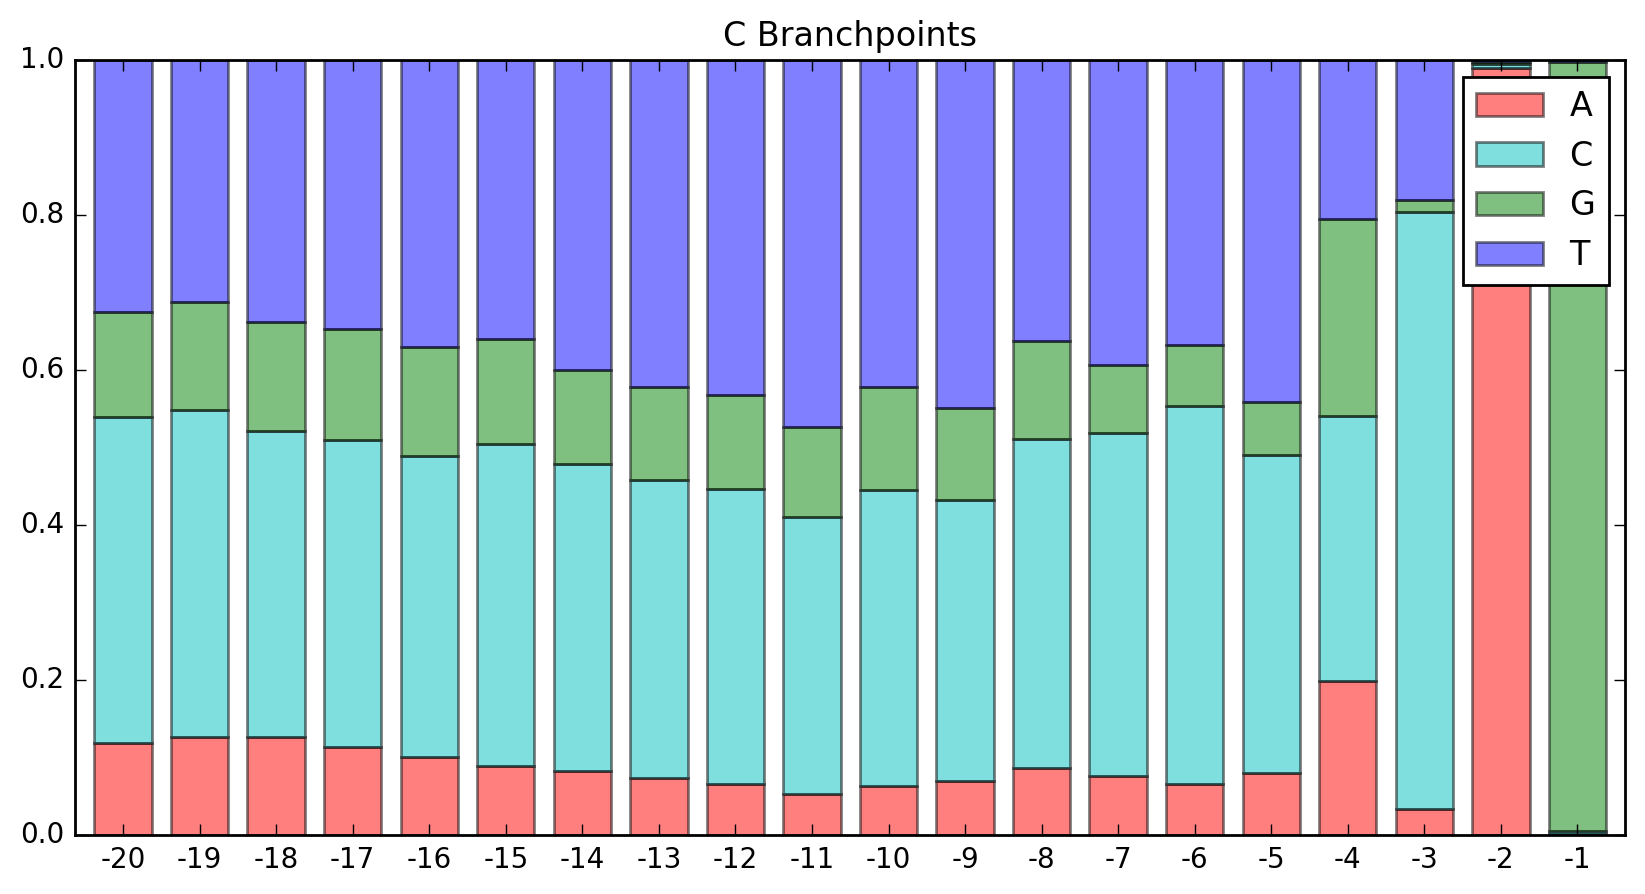

202813


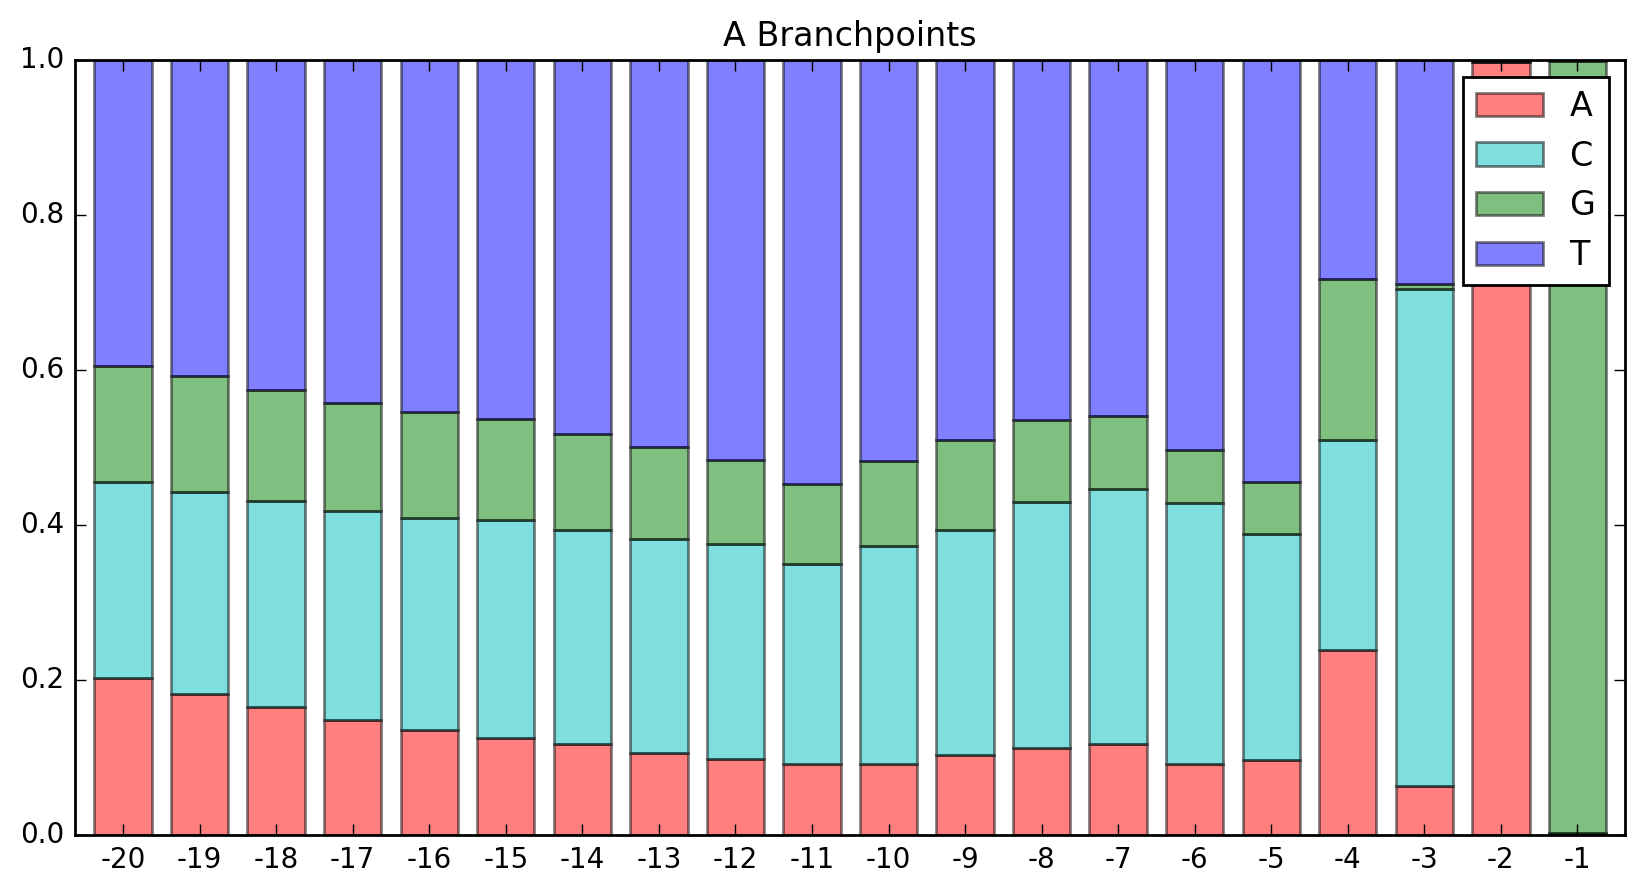

38927


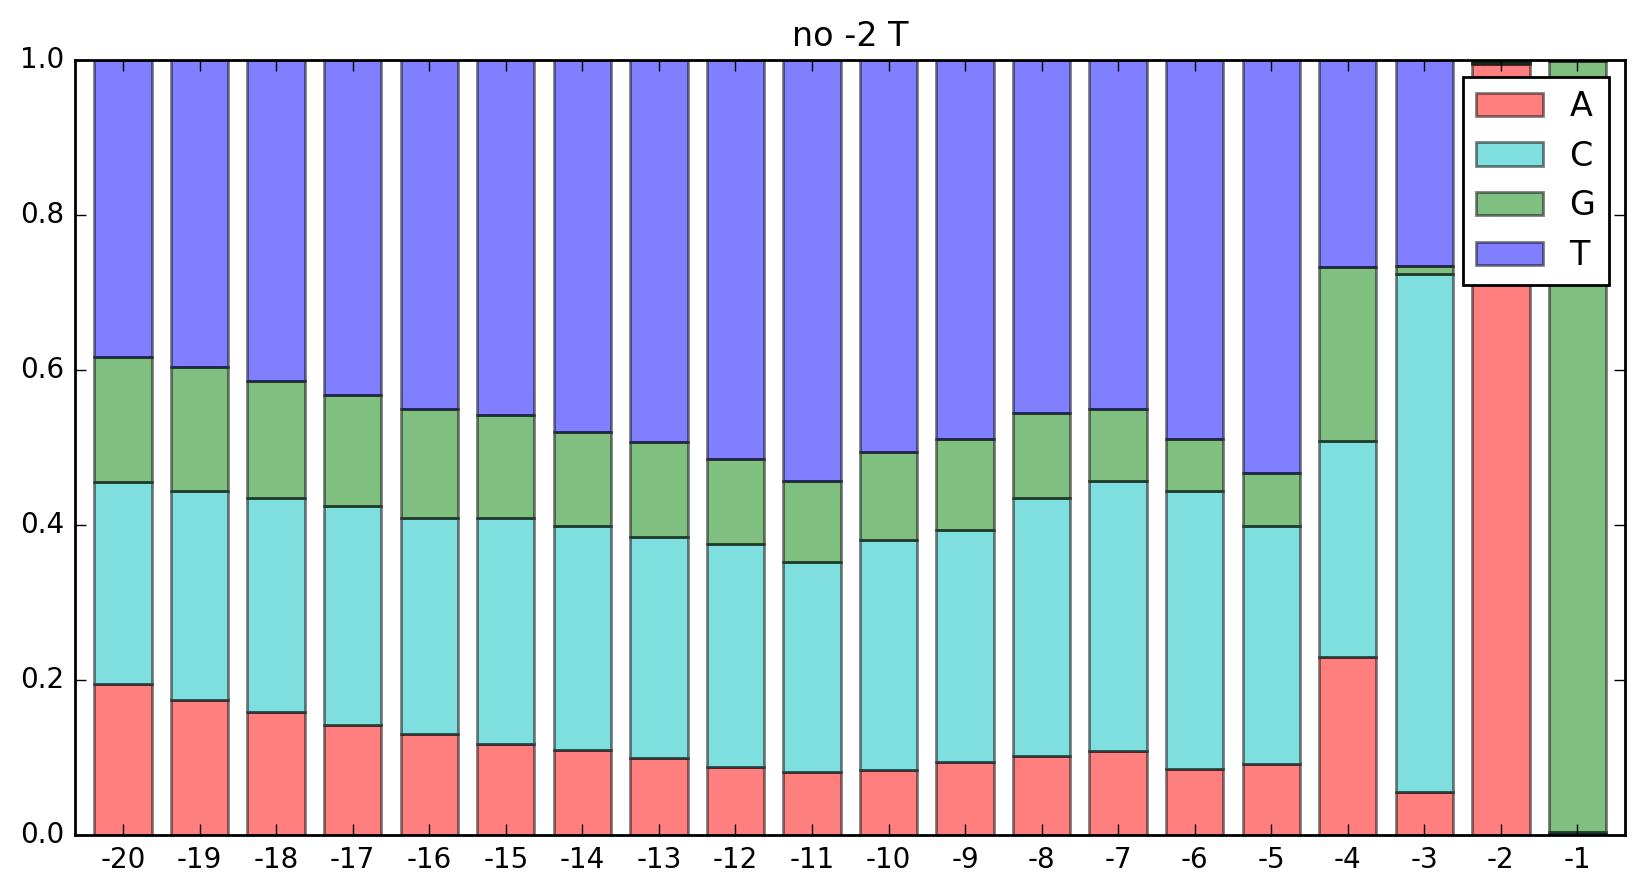

202813


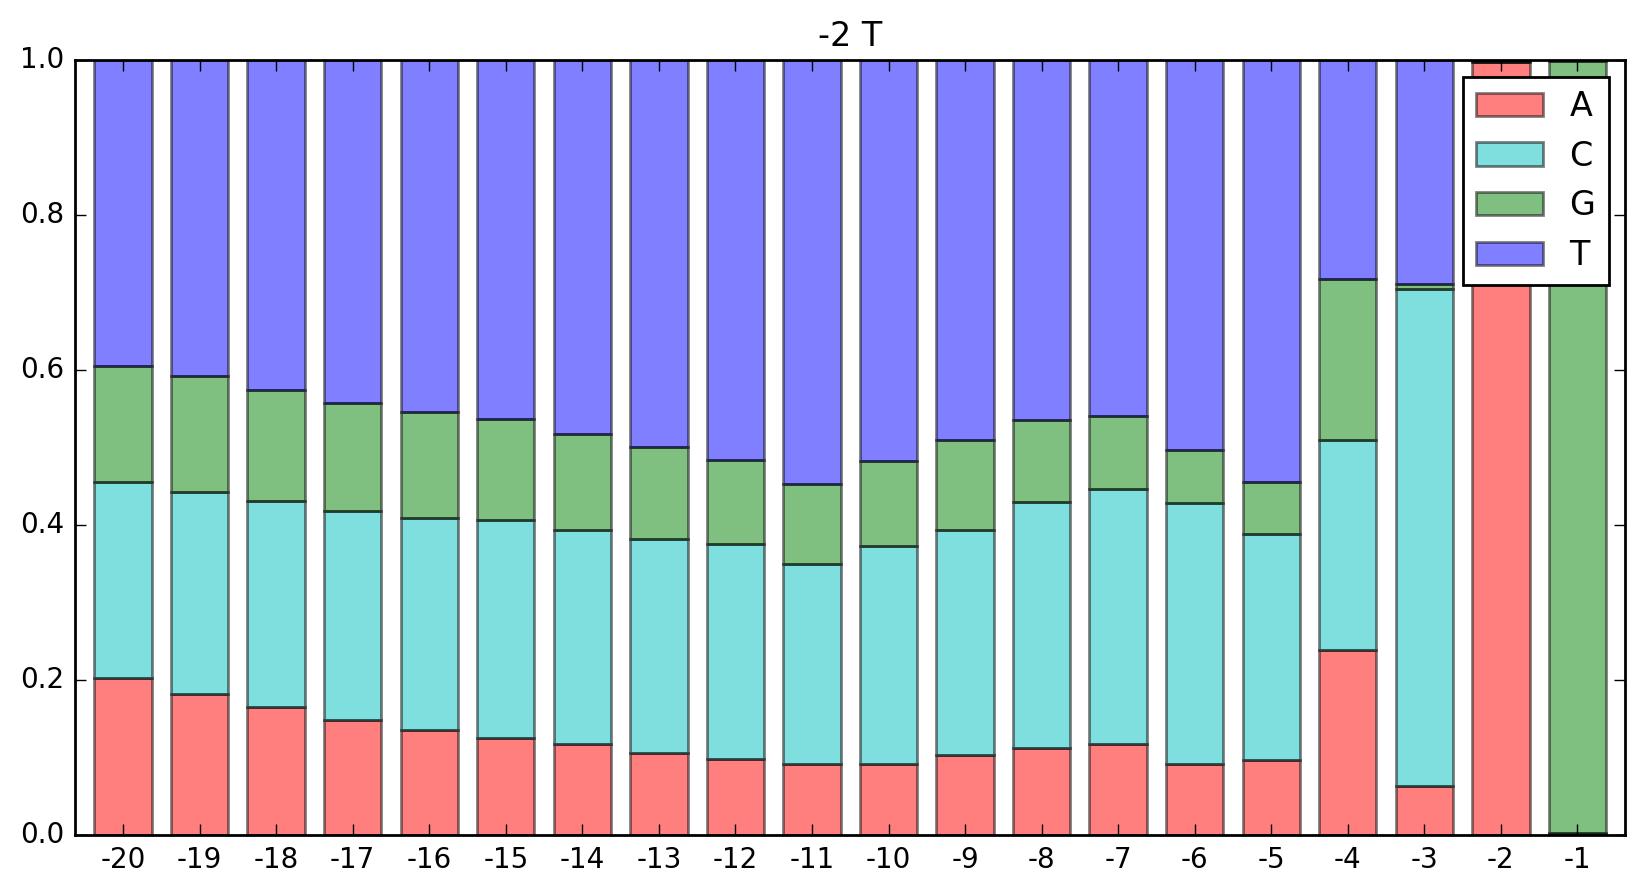

In [41]:
K = 10
counts = np.zeros((20, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp, 1]: continue
    counts += seq[-20:, :4]
    total += 1
print total
pwm_logo(counts / total, 'C Branchpoints', range(-20, 0))

counts = np.zeros((20, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp, 0]: continue
    counts += seq[-20:, :4]
    total += 1
print total
pwm_logo(counts / total, 'A Branchpoints', range(-20, 0))

counts = np.zeros((20, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if seq[bp-2, 3]: continue
    counts += seq[-20:, :4]
    total += 1
print total
pwm_logo(counts / total, 'no -2 T', range(-20, 0))

counts = np.zeros((20, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp, 0]: continue
    counts += seq[-20:, :4]
    total += 1
print total
pwm_logo(counts / total, '-2 T', range(-20, 0))

4840


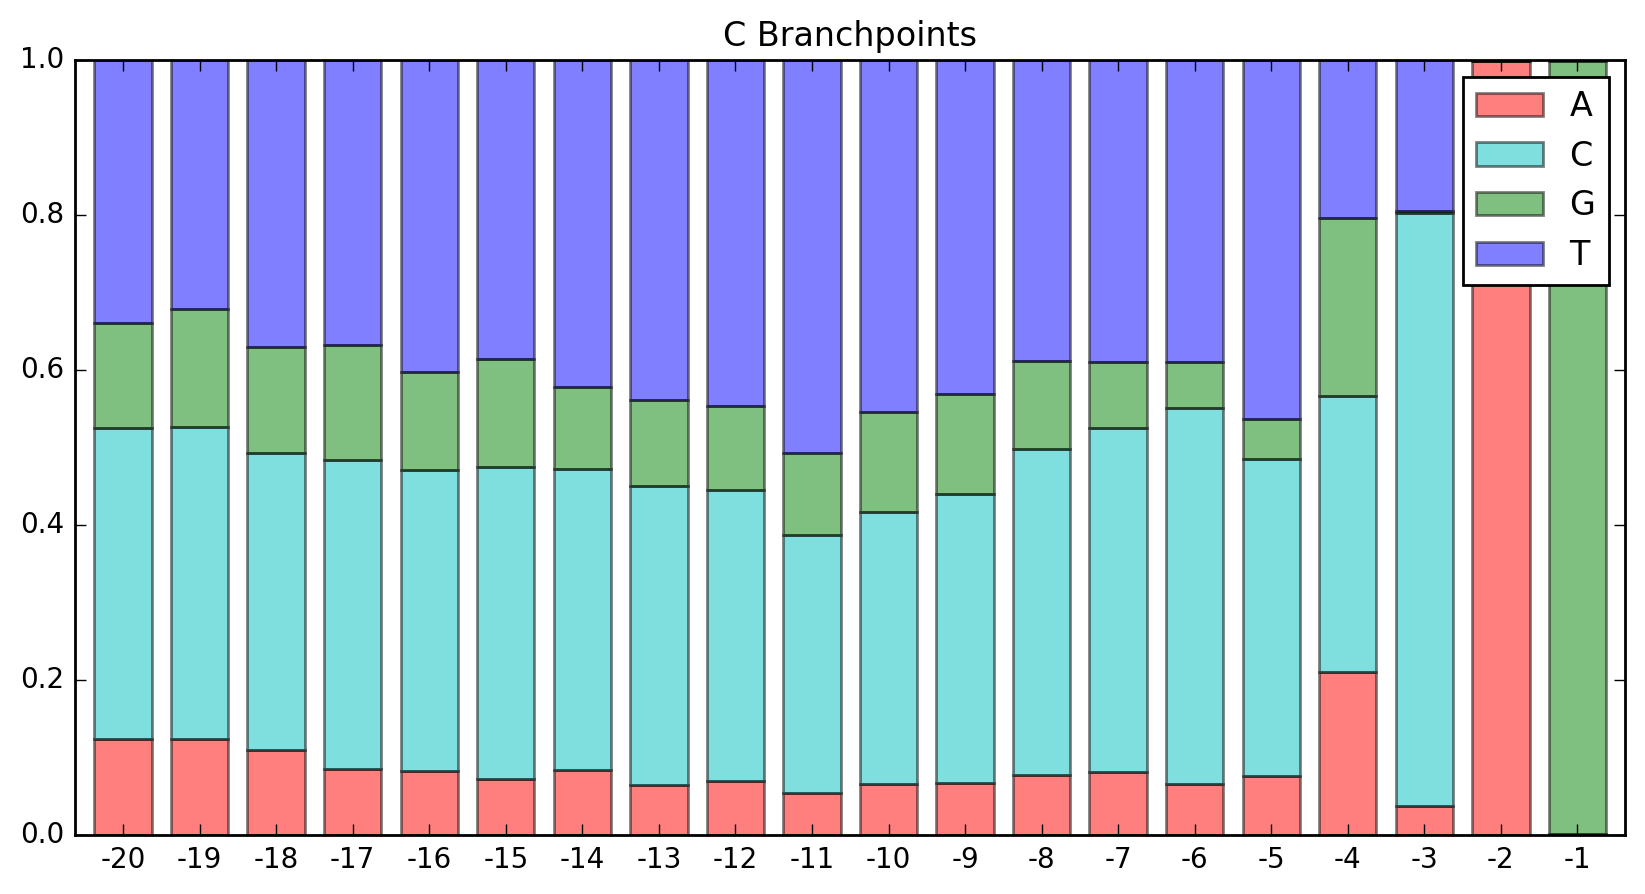

44922


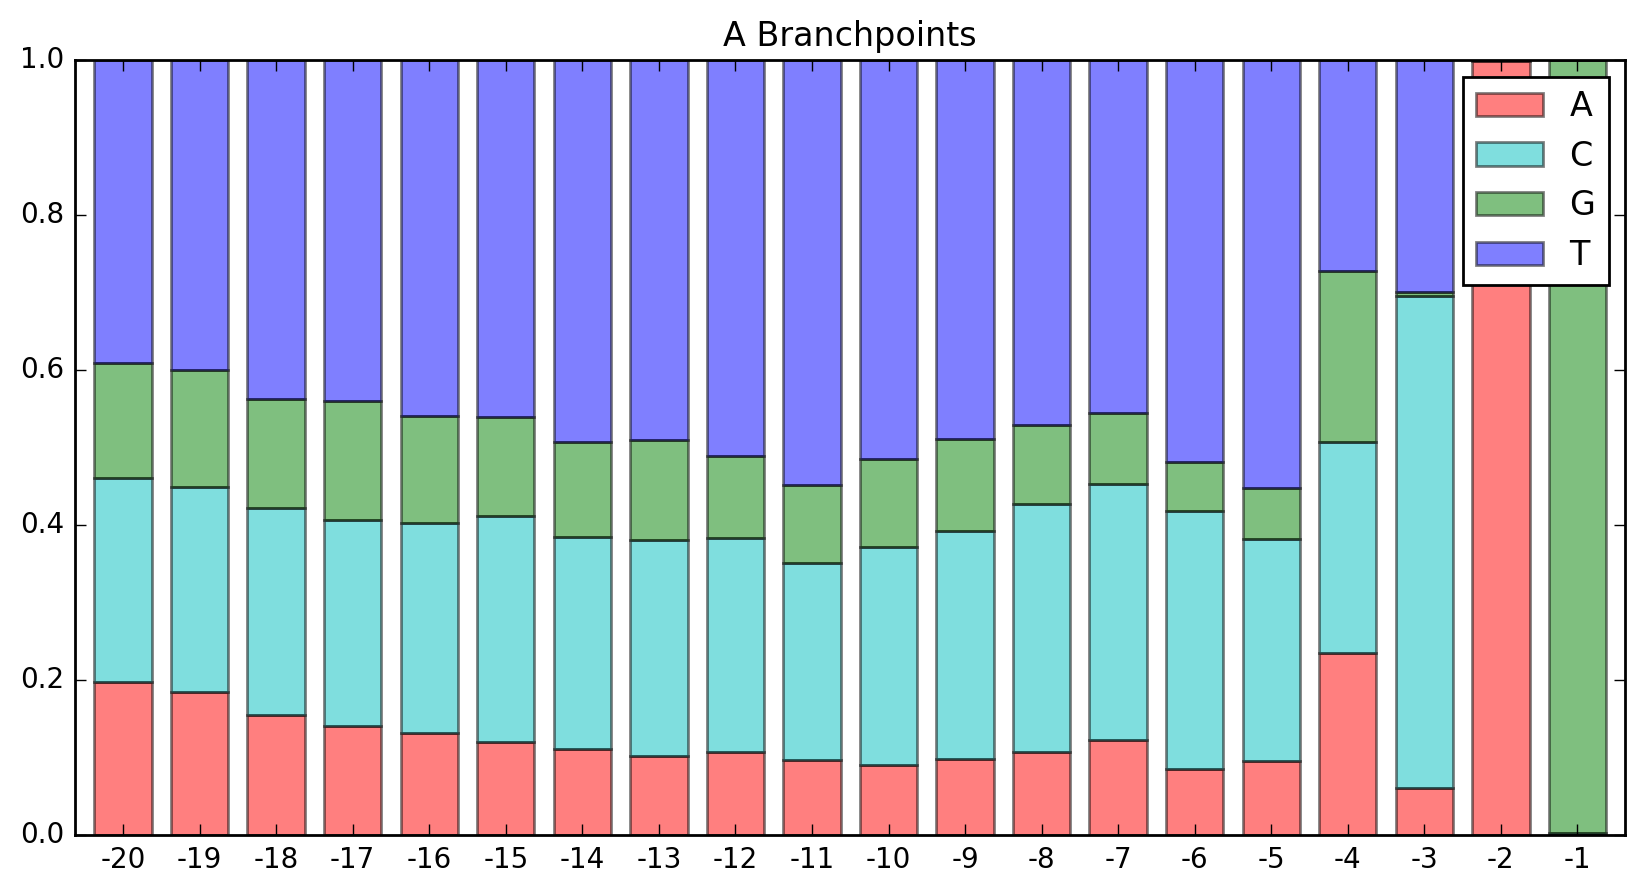

22601


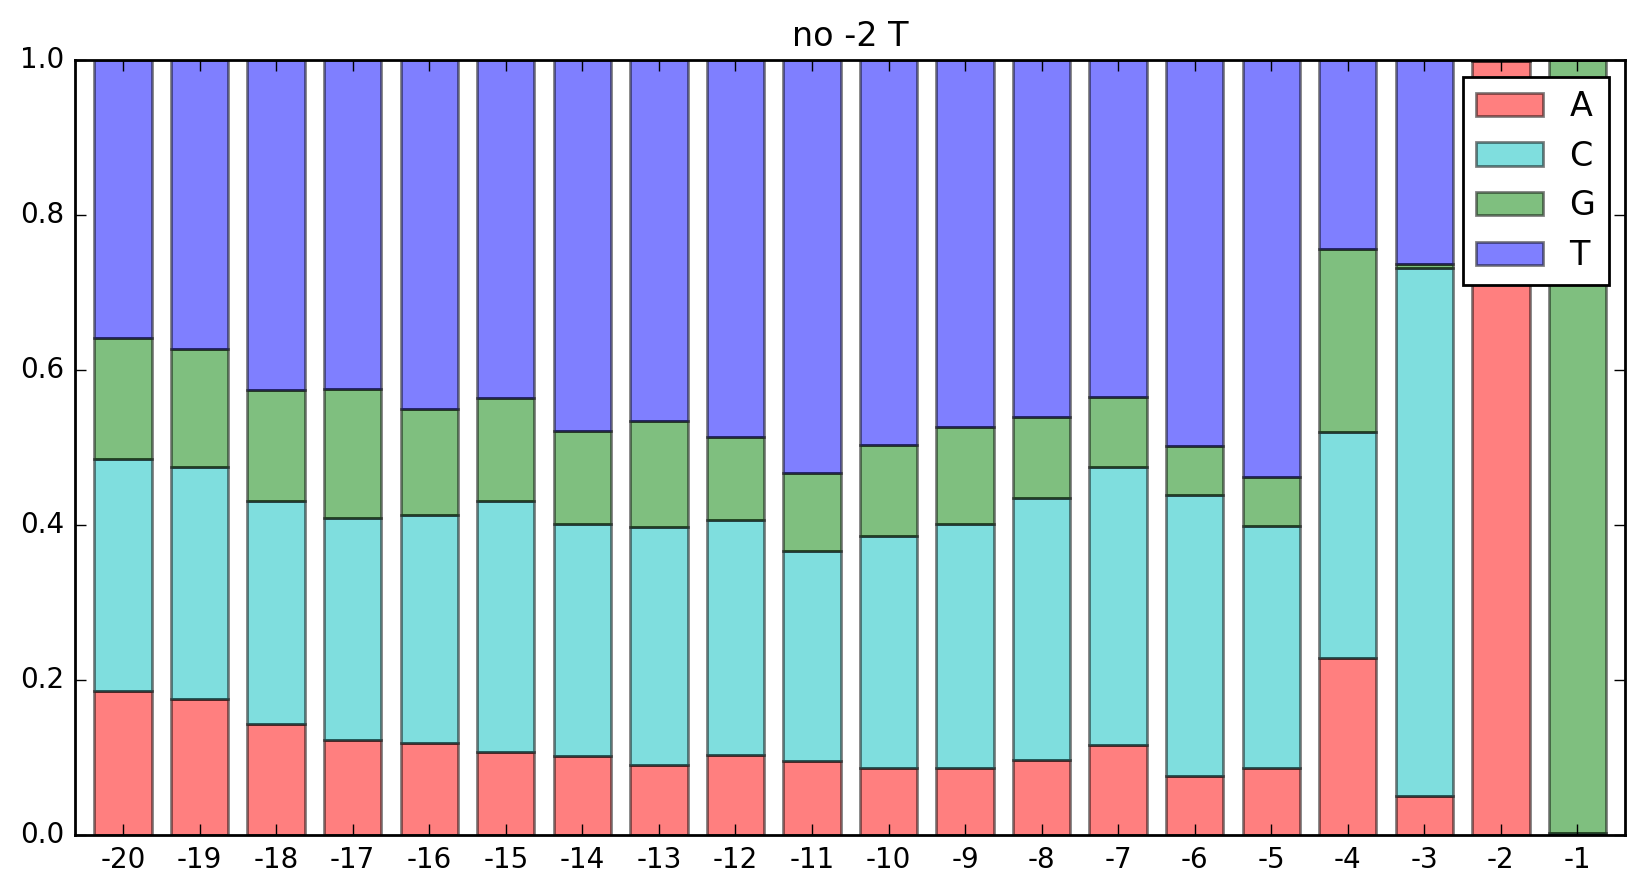

44922


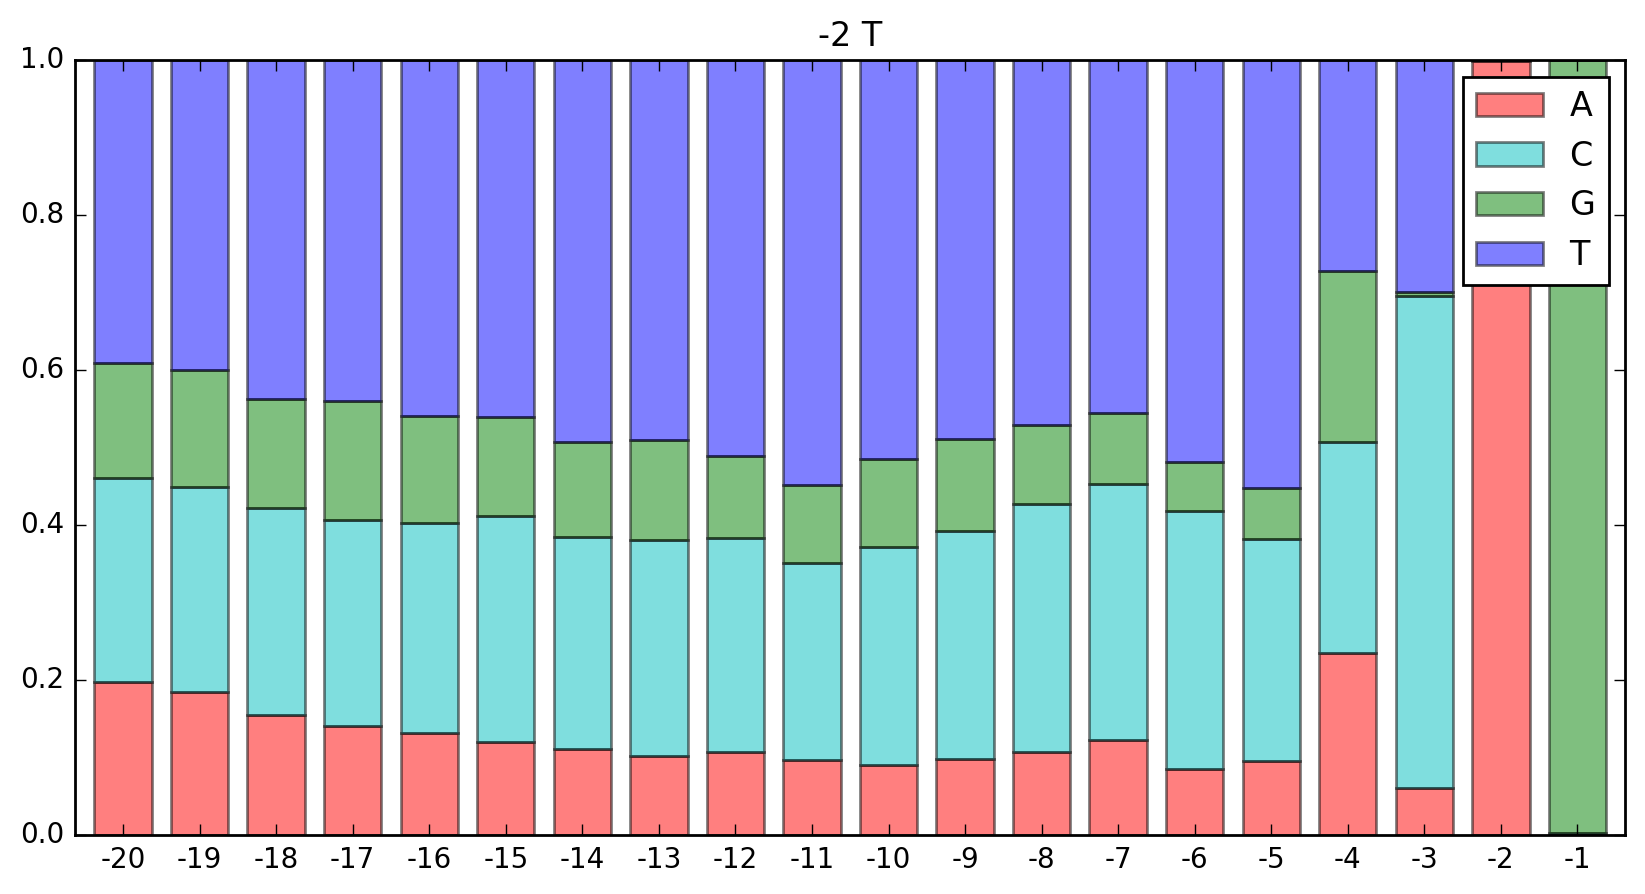

In [42]:
counts = np.zeros((20, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.array(range(L))[target == 1]:
        if not seq[bp, 1]: continue
        counts += seq[-20:, :4]
        total += 1
print total
pwm_logo(counts / total, 'C Branchpoints', range(-20, 0))

counts = np.zeros((20, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.array(range(L))[target == 1]:
        if not seq[bp, 0]: continue
        counts += seq[-20:, :4]
        total += 1
print total
pwm_logo(counts / total, 'A Branchpoints', range(-20, 0))

counts = np.zeros((20, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.array(range(L))[target == 1]:
        if seq[bp-2, 3]: continue
        counts += seq[-20:, :4]
        total += 1
print total
pwm_logo(counts / total, 'no -2 T', range(-20, 0))

counts = np.zeros((20, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.array(range(L))[target == 1]:
        if not seq[bp, 0]: continue
        counts += seq[-20:, :4]
        total += 1
print total
pwm_logo(counts / total, '-2 T', range(-20, 0))